<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Zero-shot-learning" data-toc-modified-id="Zero-shot-learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Zero-shot learning</a></span></li><li><span><a href="#Construct-linear-regressor" data-toc-modified-id="Construct-linear-regressor-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construct linear regressor</a></span><ul class="toc-item"><li><span><a href="#Procrustes" data-toc-modified-id="Procrustes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Procrustes</a></span></li><li><span><a href="#Rigid" data-toc-modified-id="Rigid-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Rigid</a></span></li><li><span><a href="#Least-squares" data-toc-modified-id="Least-squares-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Least squares</a></span></li><li><span><a href="#Zero-shot-learning" data-toc-modified-id="Zero-shot-learning-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Zero-shot learning</a></span></li></ul></li><li><span><a href="#21k" data-toc-modified-id="21k-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>21k</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Linear-classifier" data-toc-modified-id="Linear-classifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Linear classifier</a></span></li></ul></li></ul></div>

# Zero-shot learning
Let's compare different language models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Construct linear regressor

In [3]:
import torch
from torchnlp.word_to_vector import FastText, GloVe, CharNGram

# wordvecs = GloVe(cache='/mnt/fs2/bsorsch/manifold/GloVe', dim=300)
wordvecs = FastText(cache='/mnt/fs2/bsorsch/manifold/FastText/')

In [4]:
import os
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
model = 'resnet50'
save_dir = os.path.join(root, model+'/')
centers = np.load(save_dir + 'centers.npy')
manifolds = np.load(save_dir + 'manifolds.npy',allow_pickle=True)
root_paths = np.load(root + 'root_paths_1k.npy',allow_pickle=True)

ilsvrc_root = '/mnt/fs2/bsorsch/manifold/embeddings/ILSVRC/'
model = 'resnet50'
save_dir = os.path.join(ilsvrc_root, model+'/')
centers_1k = np.load(save_dir + 'centers.npy')
manifolds_1k = np.load(save_dir + 'manifolds.npy')
root_paths_1k = np.load('../manifold_old/data/ILSVRC_root_paths.npy',allow_pickle=True)

In [5]:
# Include only first name
wvs = []
embedding_idx = []
for i,rp in enumerate(root_paths[:1000]):
    wv = []
    name = rp[0]
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)  
    if wv:
        embedding_idx.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs.append(np.stack(wv).mean(0))
wvs = np.stack(wvs)
embedding_idx = np.stack(embedding_idx)
# wvs = wvs[embedding_idx]

In [6]:
# Include only first name
wvs_1k = []
embedding_idx_1k = []
for i,rp in enumerate(root_paths_1k):
    wv = []
    name = rp[0]
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)    
    if wv:
        embedding_idx_1k.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs_1k.append(np.stack(wv).mean(0))
wvs_1k = np.stack(wvs_1k)
embedding_idx_1k = np.stack(embedding_idx_1k)
# wvs_1k = wvs_1k[embedding_idx_1k]                   # keep only wvs with an embedding

In [7]:
# Normalize
WVMEAN = wvs_1k.mean(0)

wvs -= WVMEAN
wvs_1k -= WVMEAN
wvs /= np.linalg.norm(wvs, axis=-1,keepdims=True)
wvs_1k /= np.linalg.norm(wvs_1k, axis=-1,keepdims=True)
wvs = np.nan_to_num(wvs)
wvs_1k = np.nan_to_num(wvs_1k)

In [8]:
# # Normalize
# manifolds_norm = manifolds / np.linalg.norm(manifolds, axis=-1,keepdims=True)
# manifolds_1k_norm = manifolds_1k / np.linalg.norm(manifolds_1k, axis=-1,keepdims=True)
# centers_norm = manifolds_norm.mean(1)
# centers_1k_norm = manifolds_1k_norm.mean(1)

## Procrustes

In [9]:
Xtrain = wvs_1k
Ytrain = centers_1k
Xtest = wvs
Ytest = centers

In [10]:
def procrustes(X,Y):
    bx = X.mean(0)
    by = Y.mean(0)

    ax = 1/np.sqrt(np.sum((X - bx)**2))
    ay = 1/np.sqrt(np.sum((Y - by)**2))

    Xprime = ax*(X - bx)
    Yprime = ay*(Y - by)

    U,S,Vh = np.linalg.svd(Xprime.T@Yprime,full_matrices=False)

    O = U@Vh
    Yhat = Xprime@O / ay + by

    overlap = (Yhat*Y).sum() / np.sqrt(np.sum(Yhat**2))/ np.sqrt(np.sum(Y**2))

    return ax,ay,bx,by,O,overlap


def map_procrustes(X,ax,ay,bx,by,O):
    return ax/ay*(X-bx)@O + by

In [11]:
ax,ay,bx,by,O,overlap = procrustes(Xtrain,Ytrain)

In [12]:
Yhat = map_procrustes(Xtest,ax,ay,bx,by,O)

## Rigid

In [9]:
def rigid(Xtrain,Xtest,Ytrain,Ytest):
    X = Xtrain - Xtrain.mean(0)
    Y = Ytrain - Ytrain.mean(0)
    S = X.T@Y

    U,Sig,V = np.linalg.svd(S)
    V = V.T

    R = V[:,:300]@U.T
    t = Ytrain.mean(0) - R@Xtrain.mean(0)

    Xtest_embed = Xtest@R.T 
    Xtrain_embed = Xtrain@R.T 

    resid1k = np.linalg.norm(Xtrain_embed - Ytrain,axis=-1)
    resid = np.linalg.norm(Xtest_embed - Ytest,axis=-1)
    cos_ang = (Xtest_embed*Ytest).sum(-1)
    cos_ang /= np.linalg.norm(Ytest,axis=-1) * np.linalg.norm(Xtest_embed, axis=-1)
    cos_ang_1k = (Xtrain_embed*Ytrain).sum(-1)
    cos_ang_1k /= np.linalg.norm(Ytrain,axis=-1) * np.linalg.norm(Xtrain_embed, axis=-1)

    return R,t,resid,resid1k,cos_ang,cos_ang_1k
    

/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/bsorsch/.torch3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/bsorsch/.torch3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


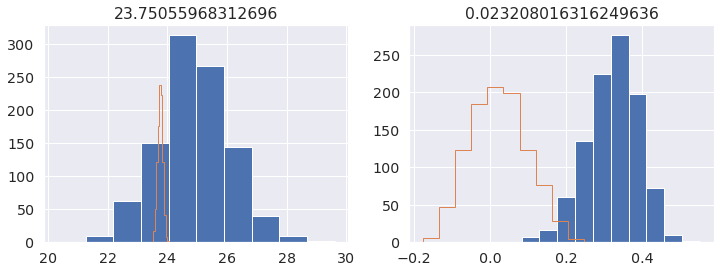

In [10]:
R,t,resid,resid_1k,cos_ang,cos_ang_1k = rigid(wvs_1k,wvs,centers_1k,centers)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

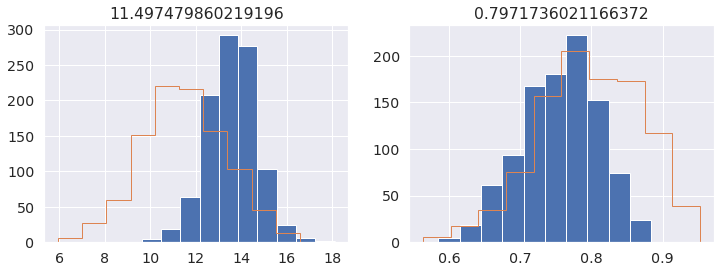

In [15]:
R,t,resid,resid_1k,cos_ang,cos_ang_1k = rigid(wvs_1k,wvs,centers_1k,centers)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

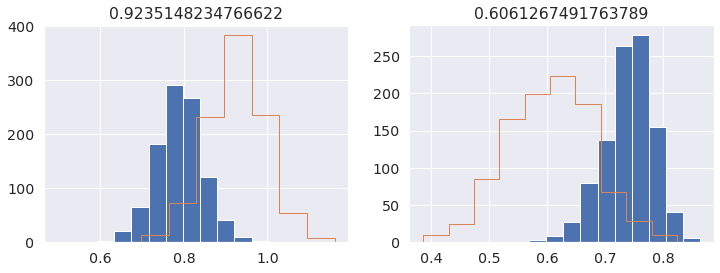

In [16]:
Rnorm,tnorm,resid,resid_1k,cos_ang,cos_ang_1k = rigid(wvs_1k,wvs,centers_1k_norm,centers_norm)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

$$ \|Ax-b\|^2 $$

$$ x = (A^TA)^{-1} A^T b $$

## Least squares

In [17]:
def least_squares(Xtrain,Xtest,Ytrain,Ytest):
    n_classes = len(Xtrain)
    M = wvs.shape[-1]

    A = np.concatenate([Xtrain,np.ones((n_classes,1))],axis=1)
    x = np.linalg.pinv(A.T@A+1e1)@A.T@Ytrain
    W = x[:M]
    b = x[-1]

    # Residuals
    resid_1k = np.linalg.norm(Xtrain@W + b - Ytrain, axis=-1)
    cos_ang_1k = ((Xtrain@W + b)*Ytrain).sum(-1)
    cos_ang_1k /= np.linalg.norm(Xtrain@W + b,axis=-1) * np.linalg.norm(Ytrain, axis=-1)
    
    resid = np.linalg.norm(Xtest@W + b - Ytest, axis=-1)
    cos_ang = ((Xtest@W + b)*Ytest).sum(-1)
    cos_ang /= np.linalg.norm(Xtest@W + b,axis=-1) * np.linalg.norm(Ytest, axis=-1)
    
    return W, b, resid, resid_1k, cos_ang, cos_ang_1k

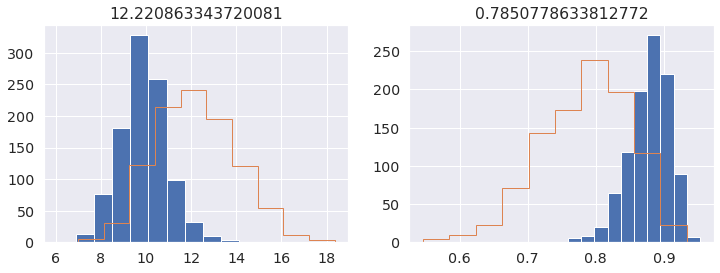

In [18]:
W, b, resid, resid_1k, cos_ang, cos_ang_1k = least_squares(wvs_1k,wvs,centers_1k,centers)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

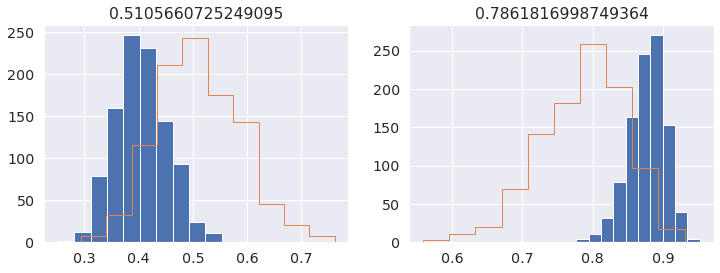

In [19]:
Wnorm, bnorm, resid, resid_1k, cos_ang, cos_ang_1k = least_squares(wvs_1k,wvs,centers_1k_norm,centers_norm)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(resid_1k);
plt.hist(resid, histtype='step');
plt.title(np.nanmean(resid))
plt.subplot(122)
plt.hist(cos_ang_1k);
plt.hist(cos_ang, histtype='step');
plt.title(np.nanmean(cos_ang));

## Zero-shot learning

In [27]:
# @jit
def zero_shot(y1,y2,manifold):
    w = (y1 - y2)
    mu = (y1 + y2) / 2
    h = w@manifold.T - w@mu
    err = (h < 0).mean()
    return err

In [ ]:
zse = []
zse_ls = []
n_classes = 20
for i in tqdm(range(n_classes)):
    manifold = manifolds[i]
    y1 = wvs[i]@R.T + t
    y1_ls = wvs[i]@W + b
    for j in range(n_classes):
        if i!=j:
            y2 = wvs[j]@R.T + t
            y2_ls = wvs[j]@W + b
            zse.append(zero_shot(y1,y2,manifold))
            zse_ls.append(zero_shot(y1_ls,y2_ls,manifold))

zse = np.stack(zse).reshape(n_classes,n_classes-1)
zse_ls = np.stack(zse_ls).reshape(n_classes,n_classes-1)

Accuracy: 90%


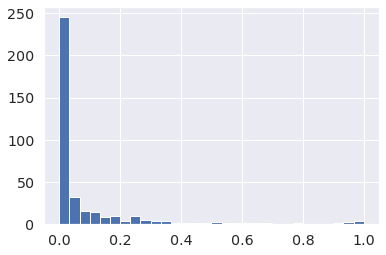

In [20]:
import numpy as npo
print('Accuracy: ' + str(int(100*(1-npo.nanmean(zse))))+'%')
plt.hist(zse.ravel(), bins=30);

Accuracy: 88%


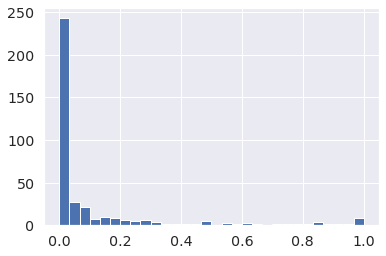

In [21]:
import numpy as npo
print('Accuracy: ' + str(int(100*(1-npo.nanmean(zse_ls))))+'%')
plt.hist(zse_ls.ravel(), bins=30);

# 21k

In [13]:
# Read synset files
import pandas as pd
wnids_21k = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt').to_numpy().squeeze()

In [14]:
# Wordnet tools
import pandas as pd
wordnet = np.load('../manifold_old/data/wordnet_hierarchy.npy', allow_pickle=True)
synset_wnids = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
synset_wnids = synset_wnids.to_numpy()

def class_from_wnid(wnid):
    return  synset_wnids[np.where(synset_wnids==wnid)[0], 1][0]

In [15]:
# Read synset files
synset_list = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt')
synset_list = synset_list.to_numpy().squeeze()

# from utils import class_from_wnid
labels_21k = np.array([class_from_wnid(wnid) for wnid in synset_list])

In [16]:
# Keep only classes not in ILSVRC
ilsvrc_names = np.load('../manifold_old/data/ILSVRC_classes.npy')
# names = np.stack([name for name in names if not np.isin(name,ilsvrc_names)])

heldout_idxs = [i for i,name in enumerate(labels_21k) if not np.isin(name,ilsvrc_names)]

labels_20k = labels_21k[heldout_idxs]
wnids_20k = wnids_21k[heldout_idxs]

In [17]:
# Include only first name
wvs = []
embedding_idxs_all = []
for i,name in enumerate(labels_20k):
    wv = []
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)  
    if wv:
        embedding_idxs_all.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs.append(np.stack(wv).mean(0))
wvs = np.stack(wvs)
embedding_idxs_all = np.stack(embedding_idxs_all)

In [18]:
# # Keep only words with embeddings
# wvs = wvs[embedding_idxs_all]
# names = names[embedding_idxs_all]

In [19]:
# Normalize
wvs -= WVMEAN
wvs /= np.linalg.norm(wvs, axis=-1,keepdims=True)
wvs = np.nan_to_num(wvs)

In [20]:
# Procrustes
wve = map_procrustes(wvs,ax,ay,bx,by,O)

# # Rigid
# wve = wvs@R.T + t

# wve_norm = wvs@Rnorm.T + tnorm
# # Least squares
# wve_ls = wvs@W + b
# wve_ls_norm = wvs@Wnorm + bnorm

In [21]:
# Make sure wvs with no embedding are set to nan
bad_idxs = np.setxor1d(np.arange(len(wve)),embedding_idxs_all)
for i in bad_idxs:
    wve[i] = np.nan*np.ones(2048)

## Data

In [22]:
# Find number of classes
path = '/mnt/fs2/bsorsch/manifold/held_out_imagenet/'
top_classes = np.load('/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/names.npy')

In [23]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
img_dir = '/mnt/fs0/datasets/ImageNet21k/'
from PIL import Image

def get_batch(i, wnid_dir, imgs, batch_size):
    xbatch = []
    for img in imgs[i*batch_size:(i+1)*batch_size]:
        try:
            x = Image.open(os.path.join(wnid_dir, img)).convert('RGB')
            xbatch.append(preprocess(x))
        except:
            pass
    if len(xbatch)==0:
        return None
    else:
        return torch.stack(xbatch)

In [25]:
from torchvision.utils import make_grid
def show_grid(im_tensor, nrow=8, title=None):
    im_grid = make_grid(im_tensor, nrow=nrow, padding=2)
    im_grid = im_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im_grid = std * im_grid + mean
    im_grid = np.clip(im_grid, 0, 1)
    
    plt.figure(figsize=(15,2*len(input_tensor)//nrow))
    plt.imshow(im_grid)
    plt.axis('off')
    plt.title(title)

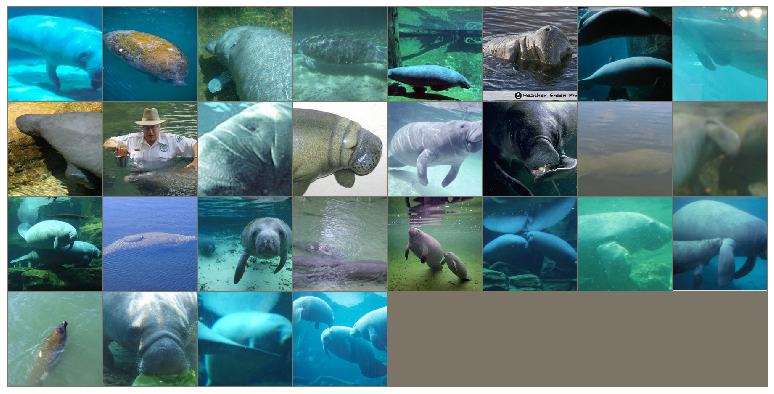

In [26]:
batch_size = 32
wnid = wnids_20k[12]
wnid_dir = os.path.join(img_dir, wnid)
imgs = os.listdir(wnid_dir)

input_tensor = get_batch(0, wnid_dir, imgs, batch_size)

show_grid(input_tensor)

## Model

In [27]:
import torch

In [28]:
model_name = 'resnet50'
# model_name = 'tf_efficientnet_l2_ns_475'
repo = 'pytorch/vision:v0.6.0'
# repo = 'rwightman/gen-efficientnet-pytorch'
model = torch.hub.load(repo, model_name, pretrained=True)

# model_dir = '/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/'+model_name+'_heldout/'

Using cache found in /home/bsorsch/.cache/torch/hub/pytorch_vision_v0.6.0


In [29]:
class WideResNetBackbone(torch.nn.Module):
    def __init__(self, model, module_idx):
        super(WideResNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.features = torch.nn.Sequential(*list(model.children())[:-module_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

In [30]:
backbone = WideResNetBackbone(model, 1)
backbone = backbone.cuda().eval();

In [31]:
# wve = wve[heldout_idxs]
# wve_norm = wve_norm[heldout_idxs]
# wve_ls = wve_ls[heldout_idxs]
# wve_ls_norm = wve_ls_norm[heldout_idxs]

In [32]:
wve = torch.tensor(wve).cuda().float()
# wve_norm = torch.tensor(wve_norm).cuda().float()
# wve_ls = torch.tensor(wve_ls).cuda().float()
# wve_ls_norm = torch.tensor(wve_ls_norm).cuda().float()

In [37]:
def acc(i,output,wv):
    preds1 = []
    preds5 = []
    preds10 = []
#     preds1_cos = []
#     preds5_cos = []
#     preds10_cos = []
    for xi in output:
        dists = ((xi - wv)**2).sum(-1)
        neighbors = torch.argsort(dists).cpu().numpy()
        preds1.append(np.isin(i,neighbors[0]))
        preds5.append(np.isin(i,neighbors[:5]))
        preds10.append(np.isin(i,neighbors[:10]))

#         cos_ang = wv@xi / torch.norm(xi) / torch.norm(wv, dim=-1)
#         neighbors = torch.argsort(1-cos_ang).cpu().numpy()
#         preds1_cos.append(np.isin(i,neighbors[0]))
#         preds5_cos.append(np.isin(i,neighbors[:5]))
#         preds10_cos.append(np.isin(i,neighbors[:10]))
    acc1 = np.mean(preds1)
    acc5 = np.mean(preds5)
    acc10 = np.mean(preds10)
#     acc1_cos = np.mean(preds1_cos)
#     acc5_cos = np.mean(preds5_cos)
#     acc10_cos = np.mean(preds10_cos)
#     return acc1,acc5,acc10,acc1_cos,acc5_cos,acc10_cos
    return acc1,acc5,acc10

In [40]:
def zero_shot_acc(i,class_dir,imgs,batch_size,wv,ks,norm=False):
    ''' Compute zero shot accuracy for a given class '''

    # Ensure batch size does not exceed num images    
    tmp_batch_size = np.minimum(len(imgs),batch_size)

    neighbors = []
    neighbors_cos = []
    accs = {}
#     accs_cos = {}
    for j in range(1+len(imgs)//tmp_batch_size):
        # Get input batch
        input_tensor = get_batch(j, class_dir, imgs, tmp_batch_size)
        if input_tensor is not None:
            # Get model ouput
            with torch.no_grad():
                output = backbone(input_tensor.cuda())

            # Normalize
            if norm:
                output /= torch.norm(output, dim=-1, keepdim=True)

            for xi in output:
                dists = ((xi - wv)**2).sum(-1)
                neighbors.append(torch.argsort(dists)[:20])
#                 cos_ang = wv@xi / torch.norm(xi) / torch.norm(wv, dim=-1)
#                 neighbors_cos.append(torch.argsort(1-cos_ang)[:20])
            
    if len(neighbors) == 0:
        return None,None,None
    else:
        neighbors = torch.stack(neighbors)
#         neighbors_cos = torch.stack(neighbors_cos)

        # Compute accuracies
        for k in ks:
            acc = torch.sum(i==neighbors[:,:k],dtype=torch.float32) / len(neighbors)
            accs[k] = acc.item()
#             acc_cos = torch.sum(i==neighbors_cos[:,:k],dtype=torch.float32) / len(neighbors_cos)
#             accs_cos[k] = acc_cos.item()

        # Most common guesses
        uniq, counts = torch.unique(neighbors,return_counts=True)
        guesses = uniq[torch.argsort(-counts)[:5]].cpu().numpy()

        nimgs = len(neighbors)

        return accs, guesses, nimgs

In [48]:
batch_size = 32
n_avg = 1000
ks = [1,2,5,10,20]

# Set up accuracy dicts
accs_rigid = {}
accs_rigid_norm = {}
accs_ls = {}
accs_ls_norm = {}
accs_rigid_cos = {}
accs_rigid_norm_cos = {}
accs_ls_cos = {}
accs_ls_norm_cos = {}
for k in ks:
    accs_rigid[k] = []
    accs_rigid_norm[k] = []
    accs_ls[k] = []
    accs_ls_norm[k] = []
    accs_rigid_cos[k] = []
    accs_rigid_norm_cos[k] = []
    accs_ls_cos[k] = []
    accs_ls_norm_cos[k] = []

nimgs = []
wnids = []
idxs = []
perm = np.random.permutation(len(wnids_20k))    # proceed in random order
for i in tqdm(range(len(wnids_20k))):
    idx = perm[i]
    wnid = wnids_20k[idx]
    wnid_dir = os.path.join(img_dir, wnid)
    imgs = os.listdir(wnid_dir)

    # Rigid
    acc_tmp, guesses, nimgs_tmp = zero_shot_acc(idx,wnid_dir,imgs,batch_size,wve,ks)
    if acc_tmp:
        for k in ks:
            accs_rigid[k].append(acc_tmp[k])
#             accs_rigid_cos[k].append(acc_cos_tmp[k])
        print('Class: ' + str(labels_20k[idx]))
        guessnames = labels_20k[guesses]
        guessnames = [gn.split(',')[0] for gn in guessnames]
        print('Top guesses: ' + '; '.join(guessnames))

#         # LS
#         (acc_tmp, acc_cos_tmp,
#          guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,tmp_batch_size,wve_ls,ks)
#         if acc_tmp:
#             for k in ks:
#                 accs_ls[k].append(acc_tmp[k])
#                 accs_ls_cos[k].append(acc_cos_tmp[k])

#     # Rigid norm
#     (acc_tmp, acc_cos_tmp,
#      guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,batch_size,wve_norm,ks,norm=False)
#     if acc_tmp:
#         for k in ks:
#             accs_rigid_norm[k].append(acc_tmp[k])
#             accs_rigid_norm_cos[k].append(acc_cos_tmp[k])
        
#         # Ls norm
#         (acc_tmp, acc_cos_tmp,
#          guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,tmp_batch_size,wve_ls_norm,ks,norm=True)
#         if acc_tmp:
#             for k in ks:
#                 accs_ls_norm[k].append(acc_tmp[k])
#                 accs_ls_norm_cos[k].append(acc_cos_tmp[k])

    if acc_tmp:
        wnids.append(wnid)
        idxs.append(idx)
        nimgs.append(nimgs_tmp)

    if i % 10 == 9:
        print('acc1= {:.2f}%, acc5={:.2f}%, acc10={:.2f}%'.format(
                100*np.sum(np.stack(accs_rigid[1])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_rigid[5])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_rigid[10])*np.stack(nimgs)) / np.sum(nimgs)))

Class: Boletus pulcherrimus
Top guesses: Frost's bolete; sandy mushroom; olive-tree agaric; Tricholoma pessundatum; meadow mushroom
Class: Boletus pulcherrimus
Top guesses: Frost's bolete; sandy mushroom; olive-tree agaric; Tricholoma pessundatum; meadow mushroom
Class: marang, marang tree, Artocarpus odoratissima
Top guesses: jackfruit; soursop; coral bean tree; coco plum; marmalade tree
Class: marang, marang tree, Artocarpus odoratissima
Top guesses: jackfruit; soursop; coral bean tree; coco plum; marmalade tree
Class: scanner, electronic scanner
Top guesses: laser printer; xerographic printer; wire matrix printer; Xerox; scanner
Class: scanner, electronic scanner
Top guesses: laser printer; xerographic printer; wire matrix printer; Xerox; scanner
Class: cleaners, dry cleaners
Top guesses: drugstore; street; street; showroom; supermarket
Class: cleaners, dry cleaners
Top guesses: drugstore; street; street; showroom; supermarket
Class: yellow salsify, Tragopogon dubius
Top guesses: ta

Class: lemon balm, garden balm, sweet balm, bee balm, beebalm, Melissa officinalis
Top guesses: cabbage; wild cabbage; skunk cabbage; cauliflower; white snakeroot
Class: polypody
Top guesses: richweed; jade vine; sorrel tree; skunk cabbage; scarlet wisteria tree
Class: polypody
Top guesses: richweed; jade vine; sorrel tree; skunk cabbage; scarlet wisteria tree
Class: swamp oak, Viminaria juncea, Viminaria denudata
Top guesses: moth bean; giant chinkapin; jade vine; potato tree; scarlet wisteria tree
acc1= 0.13%, acc5=0.64%, acc10=1.76%
Class: swamp oak, Viminaria juncea, Viminaria denudata
Top guesses: moth bean; giant chinkapin; jade vine; potato tree; scarlet wisteria tree
acc1= 0.13%, acc5=0.64%, acc10=1.76%
Class: matchlock
Top guesses: rifle grenade; pistol grip; sniper rifle; bayonet; submachine gun
Class: matchlock
Top guesses: rifle grenade; pistol grip; sniper rifle; bayonet; submachine gun
Class: newt, triton
Top guesses: spotted salamander; mole salamander; slender salamande

/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


Class: bennet, white avens, Geum virginianum
Top guesses: white snakeroot; richweed; skunk cabbage; sorrel tree; honey mushroom
Class: bennet, white avens, Geum virginianum
Top guesses: white snakeroot; richweed; skunk cabbage; sorrel tree; honey mushroom
Class: butte
Top guesses: escarpment; gorge; escarpment; outcrop; defile
Class: butte
Top guesses: escarpment; gorge; escarpment; outcrop; defile
Class: contact, contact lens
Top guesses: domino; welder's mask; catcher's mask; glasses case; face mask
acc1= 0.10%, acc5=0.56%, acc10=1.56%
Class: contact, contact lens
Top guesses: domino; welder's mask; catcher's mask; glasses case; face mask
acc1= 0.10%, acc5=0.56%, acc10=1.56%
Class: drive
Top guesses: small computer system interface; erasable programmable read-only memory; optical disk; wire matrix printer; CD-ROM
acc1= 2.26%, acc5=4.27%, acc10=5.85%
Class: sharkskin
Top guesses: dress suit; necktie; vest; frock coat; flannel
Class: lion cub
Top guesses: leopard cat; leopard; caracal;

Class: pillar, mainstay
Top guesses: attire; bridal gown; ecclesiastical attire; dinner dress; dress suit
Class: striped button quail, Turnix sylvatica
Top guesses: bobwhite; tinamou; flycatching warbler; sage grouse; white-throated sparrow
Class: gin and tonic
Top guesses: catsup bottle; bottle; liqueur glass; lemon juice; soda water
Class: cannonball, cannon ball, round shot
Top guesses: mound; mound; revetment; squash ball; custard apple
acc1= 2.06%, acc5=6.28%, acc10=9.47%
Class: ragged robin, cuckoo flower, Lychnis flos-cuculi, Lychins floscuculi
Top guesses: butterfly flower; oxeye daisy; oncidium; scarlet wisteria tree; snowdrop anemone
Class: convertible, sofa bed
Top guesses: convertible; sofa; daybed; bed; bed
Class: spade bit
Top guesses: hand tool; tool; toolbox; shaping tool; cutter
Class: pigsticking
Top guesses: mule deer; roe deer; wisent; boar; hog badger
Class: blacktail prairie dog, Cynomys ludovicianus
Top guesses: rabbit-eared bandicoot; chevrotain; otter shrew; ho

Class: baryon, heavy particle
Top guesses: web; web; World Wide Web; locus of infection; web spinner
Class: koto
Top guesses: woodwind; bass fiddle; bowed stringed instrument; bass clarinet; percussion instrument
Class: outside mirror
Top guesses: cable car; car; used-car; car seat; rearview mirror
Class: orchid, orchidaceous plant
Top guesses: oxeye daisy; painted daisy; violet-flowered petunia; strawflower; butterfly flower
Class: soutache
Top guesses: stopper knot; prolonge knot; surgeon's knot; love knot; fisherman's knot
Class: stock trader
Top guesses: law student; computer store; computer screen; home computer; academic costume
Class: beast of burden, jument
Top guesses: cattle; cavalry horse; wild horse; plow horse; ox
Class: spectacle
Top guesses: ballroom; music hall; funeral home; choir loft; choir
Class: allspice, allspice tree, pimento tree, Pimenta dioica
Top guesses: scarlet wisteria tree; sorrel tree; satinleaf; cattley guava; sorrel tree
Class: niqaabi
Top guesses: att

Class: Bloody Mary
Top guesses: cream sauce; catsup bottle; coffee liqueur; dessert spoon; cream soda
Class: hexahedron
Top guesses: object ball; wire matrix printer; ball; ball; blackboard eraser
Class: night latch
Top guesses: binding; book agent; document; web; toggle switch
Class: giant bamboo, kyo-chiku, Dendrocalamus giganteus
Top guesses: pahautea; sorrel tree; silver-bell tree; woodhewer; titi
Class: pina cloth
Top guesses: gown; dress; nightgown; taffeta; shirtdress
Class: Allen screw
Top guesses: screw wrench; screw key; Phillips screw; screw eye; machine screw
Class: bobcat, bay lynx, Lynx rufus
Top guesses: leopard cat; ocelot; jungle cat; margay; bassarisk
acc1= 2.78%, acc5=7.07%, acc10=10.11%
Class: blue poppy, Meconopsis betonicifolia
Top guesses: scarlet wisteria tree; violet-flowered petunia; oxeye daisy; tahoka daisy; strawflower
Class: echinoderm
Top guesses: sea scallop; edible sea urchin; sea slug; sea spider; bryozoan
Class: fire-eater, hothead
Top guesses: blowto

Class: Maksutov telescope
Top guesses: gunsight; camera tripod; sniper rifle; repeating firearm; condenser microphone
Class: marquis, marquess
Top guesses: dress suit; bridal gown; attire; necktie; dinner dress
Class: doeskin
Top guesses: dress suit; vest; apparel; dress; dress shirt
Class: flower cluster
Top guesses: oxeye daisy; camphor daisy; scarlet wisteria tree; painted daisy; violet-flowered petunia
Class: head gate
Top guesses: dry dock; river boat; pontoon; pier arch; cantilever bridge
acc1= 2.38%, acc5=6.64%, acc10=10.02%
Class: dwarf tulip, Tulipa armena, Tulipa suaveolens
Top guesses: oxeye daisy; carnation; marguerite; showy sunflower; strawflower
Class: retsina
Top guesses: whiskey bottle; bottle; wine vinegar; catsup bottle; sparkling wine
Class: legatee
Top guesses: dinner dress; dress uniform; dress shirt; gown; bridal gown
Class: blueberry, blueberry bush
Top guesses: scarlet wisteria tree; silver-bell tree; custard apple; satinleaf; sycamore
Class: drum printer
Top g

Class: sulfur paintbrush, Castilleja sulphurea
Top guesses: richweed; white-leaved rockrose; painted daisy; butterfly pea; glade mallow
Class: hand
Top guesses: caveman; finger paint; beach towel; skin diving; transdermal patch
Class: aalii
Top guesses: scarlet wisteria tree; sorrel tree; satinleaf; sweetleaf; butterfly pea
Class: cape aloe, Aloe ferox
Top guesses: pineapple; anemone; stapelia; snowdrop anemone; scarlet wisteria tree
Class: black-eyed Susan, black-eyed Susan vine, Thunbergia alata
Top guesses: oxeye daisy; tahoka daisy; marguerite; violet-flowered petunia; camphor daisy
Class: scanner
Top guesses: xerographic printer; laser printer; Xerox; computer; scanner
Class: chorus frog
Top guesses: frog; American green toad; leopard frog; southwestern toad; green frog
Class: attire, garb, dress
Top guesses: dress; blouse; gown; nightgown; dressing gown
Class: diabetic diet
Top guesses: potato salad; tomato sauce; bread sauce; chili sauce; pasta salad


/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 770 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Class: parnassia, grass-of-Parnassus
Top guesses: painted daisy; oxeye daisy; tahoka daisy; flowering wintergreen; fragrant orchid
acc1= 2.44%, acc5=6.89%, acc10=10.17%
Class: anchovy pear, river pear
Top guesses: sweet lemon; lemon; citrus; custard apple; coco plum
Class: appropriator
Top guesses: dinner dress; dress suit; dinner jacket; pants suit; blouse
Class: archer, bowman
Top guesses: fiddlestick; archery; bow; jew's harp; riding
Class: potential divider, voltage divider
Top guesses: computer; erasable programmable read-only memory; portable computer; optical disk; optical device
Class: lanceolate spleenwort, Asplenium billotii
Top guesses: skunk cabbage; richweed; jade vine; leafy spurge; white snakeroot
Class: spring
Top guesses: screw wrench; screw; screw key; screw eye; cap screw
Class: loser
Top guesses: apparel; dress shirt; liqueur glass; jersey; dinner jacket
Class: typhoid bacillus, Salmonella typhosa, Salmonella typhi
Top guesses: sponge; polypore; gill fungus; jelly f

Class: hip boot, thigh boot
Top guesses: breeches; vest; pants suit; dress; dress shirt
Class: cinnabar chanterelle, Cantharellus cinnabarinus
Top guesses: sandy mushroom; oyster mushroom; meadow mushroom; olive-tree agaric; Gyromitra esculenta
Class: push button, push, button
Top guesses: ignition switch; erasable programmable read-only memory; digital voltmeter; optical device; potentiometer
Class: pomelo, pomelo tree, pummelo, shaddock, Citrus maxima, Citrus grandis, Citrus decumana
Top guesses: lemon; sweet lemon; sapote; sweet orange; gamboge
Class: lever
Top guesses: adjustable wrench; bicycle wheel; bicycle; screw wrench; brake pedal
Class: scarlet plume, Euphorbia fulgens
Top guesses: oxeye daisy; scarlet wisteria tree; violet-flowered petunia; camphor daisy; carnation
acc1= 2.33%, acc5=6.54%, acc10=9.65%
Class: osprey, fish hawk, fish eagle, sea eagle, Pandion haliaetus
Top guesses: black-capped chickadee; swallow-tailed kite; osprey; white-tailed kite; black vulture
Class: wo

Class: Arenaviridae
Top guesses: jelly fungus; sponge; glass sponge; polypore; loofah
Class: little golden zinnia, Zinnia grandiflora
Top guesses: oxeye daisy; marguerite; daisy fleabane; camphor daisy; tahoka daisy
Class: anklet
Top guesses: pendant earring; stopper knot; love knot; bracelet; fisherman's knot
Class: vower
Top guesses: dress suit; dress blues; necktie; blouse; dress shirt
Class: grenadine
Top guesses: catsup bottle; sparkling wine; coffee liqueur; bottle; liqueur glass
Class: college
Top guesses: mansion; church tower; gazebo; tower; building
acc1= 2.72%, acc5=7.23%, acc10=10.41%
Class: trouser cuff
Top guesses: pants suit; vest; dress shirt; denim; breeches
Class: jack, jackass
Top guesses: aoudad; cattle; domestic sheep; goat antelope; wisent
Class: wireworm
Top guesses: fluke; peanut worm; helminth; polychaete; house centipede
Class: temple orange
Top guesses: orange marmalade; orange soda; orange; orange juice; bitter orange
Class: pari-mutuel machine, totalizer, t

Class: beard lichen, beard moss, Usnea barbata
Top guesses: richweed; tree lupine; pahautea; woolly alder aphid; brown pine
Class: dormer window
Top guesses: gazebo; mansion; roof; terraced house; roof
Class: nightgown, gown, nightie, night-robe, nightdress
Top guesses: dress; nightgown; blouse; gown; dressing gown
Class: lime, lime tree, Citrus aurantifolia
Top guesses: sweet orange; lemon; sweet lemon; gamboge; sour orange
acc1= 2.61%, acc5=7.21%, acc10=10.54%
Class: roux
Top guesses: soup ladle; bread sauce; bread dough; butter dish; sour bread
Class: raceway, race
Top guesses: rowing boat; sailboat; boat; outrigger canoe; kayak
Class: electrostatic generator, electrostatic machine, Wimshurst machine, Van de Graaff generator
Top guesses: altazimuth; handwheel; handwheel; pendulum clock; brass
Class: mascot
Top guesses: basketball; professional basketball; ice hockey; field hockey; rugby
Class: finery
Top guesses: dress; attire; bridal gown; dressing gown; gown
Class: dessert, sweet,

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33 bytes but only got 20. Skipping tag 42016
  " Skipping tag %s" % (size, len(data), tag)


Class: checkout, checkout counter
Top guesses: drugstore; shop; slopshop; hardware store; convenience store
Class: flatterer, adulator
Top guesses: hair shirt; bridal gown; dress blues; attire; apparel
Class: spectator, witness, viewer, watcher, looker
Top guesses: attire; dinner dress; bridal gown; dress suit; academic costume
Class: sputnik
Top guesses: fipple flute; bass horn; contrabassoon; bowed stringed instrument; bass fiddle
Class: ribbon tree, ribbonwood, Plagianthus regius, Plagianthus betulinus
Top guesses: sorrel tree; scarlet wisteria tree; pahautea; mountain ebony; titi
Class: Culex quinquefasciatus, Culex fatigans
Top guesses: hymenopterous insect; trichopterous insect; orthopterous insect; hemipterous insect; heteropterous insect
Class: miter box, mitre box
Top guesses: stamping machine; plane; cutter; toolbox; miller
Class: black ash, basket ash, brown ash, hoop ash, Fraxinus nigra
Top guesses: sorrel tree; scarlet wisteria tree; titi; hillside; sorrel tree
Class: agle

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Class: punter
Top guesses: outrigger canoe; rowing boat; sailboat; paddle steamer; boat
Class: yellowtail, Seriola dorsalis
Top guesses: yellowfin croaker; yellowfin; mackerel shark; surfperch; driftfish
Class: western blind snake, Leptotyphlops humilis
Top guesses: milk snake; blind snake; grass snake; colubrid snake; whip-snake
Class: shellac, shellac varnish
Top guesses: bowed stringed instrument; sideboard; cupboard; floorboard; dining-room table
acc1= 2.87%, acc5=7.39%, acc10=10.70%
Class: webbing
Top guesses: drawstring bag; shoulder holster; sling; shoulder bag; adhesive bandage
Class: Barberton daisy, Transvaal daisy, Gerbera jamesonii
Top guesses: oxeye daisy; violet-flowered petunia; Easter daisy; strawflower; marguerite
Class: glove
Top guesses: breeches; perspirer; snap-brim hat; vest; bloomers
Class: caribou, reindeer, Greenland caribou, Rangifer tarandus
Top guesses: aoudad; goat antelope; pronghorn; domestic sheep; common eland
Class: flowering ash, Fraxinus cuspidata
To

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Class: bypass condenser, bypass capacitor
Top guesses: erasable programmable read-only memory; computer; small computer system interface; cartridge extractor; disk controller
Class: originator, conceiver, mastermind
Top guesses: formalwear; apparel; dinner dress; bridal gown; academic costume
Class: basket, basketball hoop, hoop
Top guesses: basketball; backboard; basketball equipment; basketball court; professional basketball
Class: cheval-de-frise, chevaux-de-frise
Top guesses: fence; fence; cattleship; eatage; rail fence
Class: vegetable, veggie, veg
Top guesses: potato salad; tomato sauce; plum tomato; plum tomato; tomato
Class: yagi, Yagi aerial
Top guesses: mooring tower; mast; mast; mast; range pole
Class: purple apricot, black apricot, Prunus dasycarpa
Top guesses: scarlet wisteria tree; Nepal trumpet flower; oxeye daisy; Madagascar jasmine; sorrel tree
Class: marine iguana, Amblyrhynchus cristatus
Top guesses: caiman lizard; lizard; earless lizard; desert iguana; legless lizar

Class: recovery room
Top guesses: diaper; baby bed; swaddling clothes; neonate; hospital bed
Class: velociraptor
Top guesses: desert iguana; tree lizard; caiman lizard; lizard; sand lizard
Class: handbow
Top guesses: breechcloth; headdress; bow; jewelled headdress; regalia
Class: broth, stock
Top guesses: bread sauce; curry sauce; spaghetti sauce; lentil soup; chili sauce
Class: Pearmain
Top guesses: sweet lemon; pomegranate; lemon; grapefruit; citrus
Class: rod
Top guesses: ball-peen hammer; dowel; carpenter's hammer; pistol grip; screw wrench
Class: Truncocolumella citrina
Top guesses: oyster mushroom; Boletus pulcherrimus; Boletus luridus; Boletus subvelutipes; Iowa crab
Class: tobacco moth, cacao moth, Ephestia elutella
Top guesses: orthopterous insect; trichopterous insect; hymenopterous insect; hemipterous insect; dipterous insect
Class: pinch bar
Top guesses: carpenter's hammer; belaying pin; knife blade; hand tool; ball-peen hammer
acc1= 2.72%, acc5=7.27%, acc10=10.74%
Class: d

Class: herb
Top guesses: skunk cabbage; sorrel tree; richweed; jade vine; wild cabbage
Class: yellow chamomile, golden marguerite, dyers' chamomile, Anthemis tinctoria
Top guesses: oxeye daisy; tahoka daisy; marguerite; camphor daisy; daisy fleabane
Class: firebug
Top guesses: bee beetle; darkling beetle; melolonthid beetle; beetle; Asian longhorned beetle
Class: castor bean
Top guesses: staghorn sumac; smooth sumac; soursop; shellflower; almond
Class: Old World flycatcher, true flycatcher, flycatcher
Top guesses: white-throated sparrow; flycatching warbler; blue-headed vireo; wren warbler; solitary vireo
Class: cormorant, Phalacrocorax carbo
Top guesses: white pelican; pied-billed grebe; goosander; American merganser; policeman bird
Class: sunniness
Top guesses: shoreline; hillside; escarpment; knoll; escarpment
acc1= 2.72%, acc5=7.45%, acc10=10.99%
Class: chandler
Top guesses: softball; softball; soccer player; baseball; rugby
Class: scarlet wisteria tree, vegetable hummingbird, Sesb

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Class: poteen
Top guesses: whiskey bottle; bottle; wine vinegar; sparkling wine; mulled wine
Class: work animal
Top guesses: cavalry horse; plow horse; carthorse; draft horse; vaulting horse
Class: bowed stringed instrument, string
Top guesses: fiddlestick; bass fiddle; mandolin; bass clarinet; cellist
Class: stinking goosefoot, Chenopodium vulvaria
Top guesses: richweed; sorrel tree; skunk cabbage; wild cabbage; kohlrabi
Class: macrotus, Macrotus californicus
Top guesses: bassarisk; musteline mammal; fossorial mammal; red squirrel; feline
Class: squash
Top guesses: butternut squash; squash; cymling; pattypan squash; pumpkin
Class: crow pheasant, Centropus sinensis
Top guesses: white-throated sparrow; black-billed cuckoo; missel thrush; wood thrush; New World flycatcher
Class: rheumatologist
Top guesses: dress suit; necktie; dinner dress; dinner jacket; gown
acc1= 2.66%, acc5=7.33%, acc10=10.79%
Class: airhead
Top guesses: dressing gown; dress suit; attire; document; pitch apple
Class:

Class: Australian magpie
Top guesses: black-capped chickadee; blue jay; bobwhite; American magpie; white-throated sparrow
Class: easy chair, lounge chair, overstuffed chair
Top guesses: easy chair; recliner; sofa; Eames chair; electric chair
Class: purple onion, red onion
Top guesses: pomegranate; fruit salad; cucumber; potato salad; plum tomato
Class: palomino
Top guesses: cattle; cavalry horse; plow horse; ox; aoudad
Class: Ethiopian
Top guesses: headdress; attire; jewelled headdress; bandanna; hair shirt
Class: ramekin, ramequin
Top guesses: bread sauce; cheese sauce; hot-fudge sauce; sour bread; spaghetti sauce
Class: armilla
Top guesses: soil horizon; patch pocket; slip ring; elbow pad; handcuff
acc1= 2.70%, acc5=7.45%, acc10=10.85%
Class: wainscoting, wainscotting
Top guesses: living room; dining-room table; dining-room furniture; child's room; men's room
Class: draft horse, draught horse, dray horse
Top guesses: cavalry horse; plow horse; draft horse; carthorse; saddle horse
Cla

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Class: dachshund, dachsie, badger dog
Top guesses: coonhound; pinscher; hound; wirehair; retriever
Class: Corynebacterium diphtheriae, C. diphtheriae, Klebs-Loeffler bacillus
Top guesses: planktonic algae; sponge; clown anemone fish; potato wart fungus; wood anemone
Class: scull
Top guesses: rowing boat; sailboat; outrigger canoe; boat; kayak
Class: charger, battery charger
Top guesses: earphone; scanner; erasable programmable read-only memory; condenser microphone; headset
Class: earplug
Top guesses: earphone; directional microphone; condenser microphone; potentiometer; headset
Class: European roller, Coracias garrulus
Top guesses: white-throated sparrow; blue-headed vireo; scarlet tanager; tanager; red-eyed vireo
Class: Brussels carpet
Top guesses: cathedral; cathedral; palace; palace; religious residence
Class: cooker
Top guesses: toaster oven; potentiometer; drip pot; oven thermometer; oven
Class: noctuid moth, noctuid, owlet moth
Top guesses: hymenopterous insect; hemipterous inse

Class: Arctic ground squirrel, parka squirrel, Citellus parryi
Top guesses: prairie vole; antelope squirrel; rabbit-eared bandicoot; western grey squirrel; red squirrel
Class: greengage, greengage plum
Top guesses: sweet lemon; plum tomato; plum tomato; custard apple; sweetsop
Class: softball, softball game
Top guesses: softball; baseball; soccer player; professional baseball; baseball coach
Class: lectern, reading desk
Top guesses: altar; dining-room table; dining-room furniture; vestry; pedestal table
Class: sectional
Top guesses: sofa; Murphy bed; bedroom; convertible; daybed
Class: bottom-feeder
Top guesses: pipefish; lizardfish; European flatfish; pigfish; goosefish
Class: cottonseed
Top guesses: honey mushroom; barnacle goose; white turnip; spider mite; Gymnopilus validipes
Class: difflugia
Top guesses: potato wart fungus; jelly bean; bladder worm; sponge; peanut worm
acc1= 2.02%, acc5=6.05%, acc10=9.38%
Class: Atlantic halibut, Hippoglossus hippoglossus
Top guesses: mackerel sha

Class: drey
Top guesses: woodhewer; mantled ground squirrel; tree squirrel; black pine; white mountain ash
Class: anoa, dwarf buffalo, Anoa depressicornis
Top guesses: wisent; blackbuck; aoudad; cattle; goat antelope
Class: refracting telescope
Top guesses: gunsight; artillery; sniper rifle; rifle grenade; Gatling gun
Class: solitary vireo, Vireo solitarius
Top guesses: white-throated sparrow; flycatching warbler; black-capped chickadee; linnet; yellow warbler
Class: American sycamore, American plane, buttonwood, Platanus occidentalis
Top guesses: hillside; knoll; sorrel tree; pahautea; Wollemi pine
Class: Aztec
Top guesses: jewelled headdress; headdress; bullfighter; panty girdle; millinery
Class: Lochaber ax
Top guesses: case knife; knife blade; sword cane; hammer; carpenter's hammer
Class: cybercafe
Top guesses: home computer; computer screen; computer store; personal computer; computer monitor
Class: panty girdle
Top guesses: shirtdress; tights; singlet; blouse; binding
acc1= 2.02%

Class: narc, nark, narcotics agent
Top guesses: ecclesiastical attire; dress suit; necktie; attire; full-dress uniform
Class: tomboy, romp, hoyden
Top guesses: pants suit; hair shirt; dress shirt; apparel; tights
Class: supertanker
Top guesses: bottom; cargo ship; sailing vessel; warship; ship
acc1= 2.00%, acc5=5.98%, acc10=9.26%
Class: basket weave
Top guesses: basket weave; drawstring bag; bushel basket; clothes hamper; wicker basket
Class: jug wine
Top guesses: whiskey bottle; bottle; wine cask; wine vinegar; jug wine
Class: voltage regulator
Top guesses: erasable programmable read-only memory; computer; teletypewriter; data input device; microwave diathermy machine
Class: car battery, automobile battery
Top guesses: tape recorder; erasable programmable read-only memory; teletypewriter; magnetic tape; stamping machine
Class: plastic laminate
Top guesses: dining-room table; kitchen table; dining room; living room; dining-room furniture
Class: thermonuclear reactor, fusion reactor
Top

Class: presbytery
Top guesses: church tower; chapel; cathedral; cathedral; basilica
Class: guan
Top guesses: black-billed cuckoo; policeman bird; tinamou; black-capped chickadee; white-throated sparrow
Class: painted turtle, painted terrapin, painted tortoise, Chrysemys picta
Top guesses: turtle; hawksbill turtle; green turtle; red-bellied terrapin; loggerhead
Class: mallow
Top guesses: oxeye daisy; violet-flowered petunia; strawflower; scarlet wisteria tree; painted daisy
Class: revenant
Top guesses: attire; minibike; apparel; street clothes; hair shirt
Class: World Wide Web, WWW, web
Top guesses: web; World Wide Web; computer network; web; document
Class: archaist
Top guesses: safety match; binding; key; web spinner; green alder
Class: thermos, thermos bottle, thermos flask
Top guesses: smelling bottle; bottle; vacuum flask; atomizer; drip coffee
Class: console
Top guesses: digital computer; portable computer; computer; computer screen; personal computer
Class: wall
Top guesses: reve

Class: bunchberry, dwarf cornel, crackerberry, pudding berry, Cornus canadensis
Top guesses: pink fivecorner; sorrel tree; butterfly flower; strawflower; oxeye daisy
Class: lentil, lentil plant, Lens culinaris
Top guesses: bread sauce; onion bread; garlic bread; sour bread; potato salad
Class: carpenter ant
Top guesses: bee beetle; darkling beetle; scarabaeid beetle; flea beetle; melolonthid beetle
Class: asserter, declarer, affirmer, asseverator, avower
Top guesses: dress suit; necktie; ecclesiastical attire; attire; academic costume
Class: taro, taro plant, dalo, dasheen, Colocasia esculenta
Top guesses: scarlet wisteria tree; wild cabbage; cabbage palm; cabbage palm; cabbage
Class: lawgiver, lawmaker
Top guesses: dinner dress; academic costume; ecclesiastical attire; dress suit; bridal gown
Class: rearview mirror
Top guesses: car; cable car; car seat; used-car; car train
Class: hog-nosed skunk, hognosed skunk, badger skunk, rooter skunk, Conepatus leuconotus
Top guesses: spotted sku

Class: suitor, suer, wooer
Top guesses: attire; bridal gown; dress suit; dinner dress; dress
Class: tung tree, tung, tung-oil tree, Aleurites fordii
Top guesses: scarlet wisteria tree; pansy orchid; strawflower; oxeye daisy; flowering wintergreen
Class: snow gum, ghost gum, white ash, Eucalyptus coriacea, Eucalyptus pauciflora
Top guesses: knoll; pahautea; hillside; escarpment; escarpment
Class: masjid, musjid
Top guesses: church tower; cathedral; cathedral; minaret; synagogue
acc1= 1.97%, acc5=5.97%, acc10=9.23%
Class: hygroscope
Top guesses: analog watch; pendulum clock; caesium clock; clock pendulum; timepiece
Class: entrenching tool, trenching spade
Top guesses: knife blade; case knife; knife; knife; hand shovel
Class: graniteware
Top guesses: drip pot; crock; bone-ash cup; potentiometer; crucible
Class: exponent
Top guesses: academic costume; dinner dress; clarinet; law student; dress suit
Class: cabbage palm, Euterpe oleracea
Top guesses: sorrel tree; scarlet wisteria tree; coral

Class: sugar candy
Top guesses: sweet; vanilla pudding; lemon curd; candy; candy corn
acc1= 1.96%, acc5=5.90%, acc10=9.12%
Class: boutonniere
Top guesses: dinner dress; attire; dress; gift wrapping; bridal gown
Class: rocket engineer, rocket scientist
Top guesses: sanitary napkin; milling; blazer; grocery bag; surgical knife
Class: fringe-toed lizard, Uma notata
Top guesses: agamid; earless lizard; zebra-tailed lizard; sand lizard; spiny lizard
Class: chunga, seriema, Chunga burmeisteri
Top guesses: policeman bird; pied-billed grebe; cattle egret; black-necked grebe; dabchick
Class: imperialist
Top guesses: necktie; dress suit; ecclesiastical attire; law student; academic costume
Class: European hornbeam, Carpinus betulus
Top guesses: sorrel tree; scarlet wisteria tree; sorrel tree; titi; cabbage palm
Class: anomaly, unusual person
Top guesses: hair shirt; pants suit; domino; welder's mask; catcher's mask
Class: vigil light, vigil candle
Top guesses: vigil light; glow lamp; flashlight;

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly

Class: aphid lion, aphis lion
Top guesses: trichopterous insect; orthopterous insect; hymenopterous insect; hemipterous insect; heteropterous insect
Class: wild celery, Apium graveolens
Top guesses: cabbage; cauliflower; broccoli; wild cabbage; kohlrabi
Class: yellow, yellowness
Top guesses: painted daisy; oxeye daisy; tahoka daisy; violet-flowered petunia; marguerite
Class: bass drum, gran casa
Top guesses: brake drum; percussion instrument; drum; snare drum; drum brake
Class: nympholept
Top guesses: hair shirt; dress suit; tights; pants suit; leotard
Class: skidder
Top guesses: bulldozer; wheeled vehicle; tank engine; diesel-hydraulic locomotive; truck
Class: California sea lion, Zalophus californianus, Zalophus californicus
Top guesses: sea otter; walrus; sea cow; Steller sea lion; shark
Class: hill
Top guesses: escarpment; hillside; escarpment; ridge; gorge
Class: Temperate Zone
Top guesses: mountain ash; hillside; escarpment; escarpment; Western mountain ash
acc1= 1.95%, acc5=5.89

Class: false deathcap, Amanita mappa
Top guesses: sandy mushroom; Frost's bolete; agaric; meadow mushroom; olive-tree agaric
Class: setter
Top guesses: spaniel; English toy spaniel; toy spaniel; field spaniel; setter
Class: saurischian, saurischian dinosaur
Top guesses: ceratopsian; ornithopod; protoceratops; ceratosaur; sauropod
Class: manipulator
Top guesses: winch; bicycle; bicycle wheel; motorized wheelchair; ski tow
Class: firebrick
Top guesses: plaster; revetment; lamination; chipboard; dry wall
Class: migrator
Top guesses: white-throated sparrow; white pelican; swallow-tailed kite; osprey; black-capped chickadee
acc1= 1.97%, acc5=5.93%, acc10=9.15%
Class: roadblock, barricade
Top guesses: bus; cruiser; car; car train; car
Class: blackberry
Top guesses: honey mushroom; lemon curd; vanilla pudding; Carolina allspice; salad cream
Class: tammy
Top guesses: pants suit; blouse; hair shirt; dress shirt; dinner jacket
Class: jigsaw, scroll saw, fretsaw
Top guesses: power saw; accelerato

Class: troll
Top guesses: needle; phonograph needle; needle; darning needle; crochet needle
Class: dressing gown, robe-de-chambre, lounging robe
Top guesses: dress; blouse; nightgown; gown; shirtdress
Class: gas turbine
Top guesses: diesel-hydraulic locomotive; reciprocating engine; tank engine; hydraulic brake; traction engine
Class: cream sauce
Top guesses: bread sauce; spaghetti sauce; cheese sauce; sour bread; remoulade sauce
Class: Grand Inquisitor
Top guesses: necktie; dress suit; string tie; academic costume; hair shirt
Class: carnation
Top guesses: violet-flowered petunia; painted daisy; oxeye daisy; carnation; flowering wintergreen
acc1= 1.99%, acc5=5.95%, acc10=9.17%
Class: giant ryegrass, Elymus condensatus, Leymus condensatus
Top guesses: snowberry; gorse; bog bilberry; common privet; richweed
Class: diggings, digs, domiciliation, lodgings, pad
Top guesses: terraced house; building; gazebo; mansion; bungalow
Class: yellow spiny daisy, Haplopappus spinulosus
Top guesses: oxe

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21418 bytes but only got 11888. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21270 bytes but only got 20845. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21190 bytes but only got 16236. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21138 bytes but only got 12140. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffIm

Class: common four-o'clock, marvel-of-Peru, Mirabilis jalapa, Mirabilis uniflora
Top guesses: scarlet wisteria tree; flowering wintergreen; oxeye daisy; butterfly flower; lemon lily
Class: paster
Top guesses: Eton jacket; dinner jacket; skiing; flannel; string tie
Class: sassafras, sassafras tree, Sassafras albidum
Top guesses: sorrel tree; scarlet wisteria tree; jade vine; titi; sorrel tree
Class: student center
Top guesses: auditorium; conservatory; theater; mezzanine; concert grand
Class: square knot
Top guesses: overhand knot; stopper knot; surgeon's knot; barrel knot; bowline
Class: sweet, confection
Top guesses: bread sauce; chocolate pudding; salad cream; hot-fudge sauce; cream sauce
acc1= 2.00%, acc5=5.97%, acc10=9.18%
Class: renegade
Top guesses: bass clarinet; bass horn; bass fiddle; percussion instrument; bass guitar
Class: mahogany, mahogany tree
Top guesses: pahautea; sorrel tree; hillside; knoll; brown pine
Class: dispenser
Top guesses: dispenser; vacuum flask; smelling b

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 24 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 17 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 305
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possi

Class: skin diving, skin-dive
Top guesses: snorkeling; scuba diving; whitetip shark; dive; skin-diver
Class: accessory fruit, pseudocarp
Top guesses: sweet lemon; cherry tomato; lemon juice; pineapple juice; strawberry jam
Class: regalia
Top guesses: headdress; jewelled headdress; horseman; attire; riding
Class: star
Top guesses: pinwheel; pinwheel roll; hexagon; dark lantern; window envelope
Class: gringo
Top guesses: hair shirt; dress blues; attire; dress shirt; dress suit
Class: marrow, bone marrow
Top guesses: bread sauce; cheese sauce; sour bread; grated cheese; spaghetti sauce
Class: bodywork
Top guesses: touring car; car train; cab; roadster; car
Class: syllabub, sillabub
Top guesses: cream sauce; chocolate pudding; dessert spoon; salad cream; chocolate fondue
acc1= 1.99%, acc5=5.97%, acc10=9.19%
Class: European turkey oak, turkey oak, Quercus cerris
Top guesses: sorrel tree; scarlet wisteria tree; knoll; hillside; pahautea
Class: common dandelion, Taraxacum ruderalia, Taraxacum

Class: soul mate
Top guesses: attire; dress blues; bridal gown; dinner dress; hair shirt
Class: wash
Top guesses: minibike; motorcycle; bicycle; touring car; jaunting car
Class: hansom, hansom cab
Top guesses: horse-drawn vehicle; carthorse; vaulting horse; plow horse; draft horse
Class: snapdragon
Top guesses: oxeye daisy; painted daisy; violet-flowered petunia; scarlet wisteria tree; flowering wintergreen
Class: overshoe
Top guesses: breeches; shoulder holster; handwear; vest; brogan
acc1= 1.99%, acc5=5.92%, acc10=9.09%
Class: pass-through
Top guesses: upstairs; men's room; room; shower room; living room
Class: ramjet, ramjet engine, atherodyde, athodyd, flying drainpipe
Top guesses: reciprocating engine; brake cylinder; supercharger; hydraulic brake; tank engine
Class: kepi, peaked cap, service cap, yachting cap
Top guesses: pith hat; cocked hat; headgear; snap-brim hat; headdress
Class: Nahuatl
Top guesses: attire; bridal gown; dress; formalwear; apparel
Class: fingerstall, cot
Top

Class: yellowfin mojarra, Gerres cinereus
Top guesses: European flatfish; driftfish; spotted sunfish; yellowfin; yellowfin mojarra
acc1= 2.00%, acc5=5.91%, acc10=9.08%
Class: surplice
Top guesses: dress; attire; gown; nightgown; bridal gown
Class: millet
Top guesses: common corn salad; bread dough; corn earworm; onion bread; garlic bread
Class: seaside daisy, beach aster, Erigeron glaucous
Top guesses: oxeye daisy; Easter daisy; marguerite; camphor daisy; tahoka daisy
Class: delayed action
Top guesses: camera lens; telephoto lens; camera; autofocus; flash camera
Class: scarabaeid beetle, scarabaeid, scarabaean
Top guesses: scarabaeid beetle; darkling beetle; beetle; lamellicorn beetle; click beetle
Class: assenter
Top guesses: dress suit; necktie; dress blues; dressing gown; clothing
Class: cleaner
Top guesses: bicycle pump; motorized wheelchair; minibike; bicycle wheel; motorcycle
Class: citron, citron tree, Citrus medica
Top guesses: sweet orange; sweet lemon; lemon; gamboge; citrus


Class: trail bike, dirt bike, scrambler
Top guesses: motorcycle; minibike; trail bike; bicycle; motorcycling
Class: plum tomato
Top guesses: tomato juice; plum tomato; plum tomato; sweet lemon; cherry tomato
Class: skybox
Top guesses: arcade; dining car; club car; pavilion; mezzanine
Class: pedal, treadle, foot pedal, foot lever
Top guesses: bicycle wheel; bicycle; motorcycle; push-bike; trail bike
Class: aquavit, akvavit
Top guesses: whiskey bottle; catsup bottle; bottle; wine vinegar; beer
Class: red maids, redmaids, Calandrinia ciliata
Top guesses: oxeye daisy; adobe lily; daisy fleabane; butterfly flower; violet-flowered petunia
acc1= 1.97%, acc5=5.91%, acc10=9.09%
Class: stinging nettle, Urtica dioica
Top guesses: richweed; canarybird flower; scarlet wisteria tree; skunk cabbage; white snakeroot
Class: freedom rider
Top guesses: Fleet Street; bus; motorcyclist; towpath; picket boat
Class: high-pass filter
Top guesses: Phillips screwdriver; hypodermic needle; atomizer; cartridge ex

Class: guano bat, Mexican freetail bat, Tadarida brasiliensis
Top guesses: bassarisk; pouched mouse; musteline mammal; opossum rat; golden hamster
Class: gun emplacement, weapons emplacement
Top guesses: artillery; gun emplacement; gun enclosure; Gatling gun; turret
acc1= 1.97%, acc5=5.94%, acc10=9.16%
Class: sidecar
Top guesses: minibike; motorcycle; auto racing; car; hydroplane racing
Class: spider
Top guesses: onion butter; condiment; pepper pot; chili powder; electric frying pan
Class: waltzer
Top guesses: dressing gown; dinner dress; gown; ecclesiastical attire; bridal gown
Class: ogee arch, keel arch
Top guesses: cathedral; narthex; narthex; basilica; vestry
Class: small computer system interface, SCSI
Top guesses: erasable programmable read-only memory; small computer system interface; personal computer; computer; portable computer
Class: parrotfish, polly fish, pollyfish
Top guesses: driftfish; surfperch; scorpaenid; ribbonfish; yellowfin croaker
Class: earthwork
Top guesses: e

Class: ivorybill, ivory-billed woodpecker, Campephilus principalis
Top guesses: white-throated sparrow; black-capped chickadee; white-breasted nuthatch; black-billed cuckoo; hooded merganser
Class: robotics equipment
Top guesses: accelerator; reciprocating engine; wheeled vehicle; tank; outboard motor
Class: matrimony vine, boxthorn
Top guesses: scarlet wisteria tree; cabbage palm; lemon lily; cabbage palm; orange-blossom orchid
Class: palm, palm tree
Top guesses: coralwood; bird of paradise; seaside centaury; knoll; gazebo
Class: grid, gridiron
Top guesses: chipboard; casing; toaster oven; carpet pad; erasable programmable read-only memory
Class: common eel, freshwater eel
Top guesses: lizardfish; pipefish; common eel; blacktip shark; European catfish
acc1= 2.00%, acc5=5.93%, acc10=9.13%
Class: klystron
Top guesses: cartridge extractor; atomizer; reciprocating engine; diesel-hydraulic locomotive; turbogenerator
Class: friendship plant, panamica, panamiga, Pilea involucrata
Top guesses

Class: body armor, body armour, suit of armor, suit of armour, coat of mail, cataphract
Top guesses: armor; body armor; helmet; helmet; armor plate
Class: tail, tail end
Top guesses: white-throated sparrow; black-capped chickadee; puffbird; tanager; blue-headed vireo
Class: spoor
Top guesses: sand; dune; shoreline; beach; sand snake
Class: boardroom, council chamber
Top guesses: dining-room table; dining-room furniture; dining room; living room; dinner theater
Class: squash, squash racquets, squash rackets
Top guesses: tennis racket; racquetball; racquetball; volleyball; backboard
acc1= 1.99%, acc5=5.95%, acc10=9.18%
Class: prosimian
Top guesses: lemur; bassarisk; flying lemur; woolly indris; talapoin
Class: taro, taro root, cocoyam, dasheen, edda
Top guesses: cabbage tree; scarlet wisteria tree; wild cabbage; cabbage; cabbage palm
Class: semigloss
Top guesses: aspirin powder; smelling bottle; soda water; bottle; whiskey bottle
Class: spike rush
Top guesses: marsh hare; pine-barren san

Class: sweet William, Dianthus barbatus
Top guesses: oxeye daisy; violet-flowered petunia; strawflower; scarlet wisteria tree; Nepal trumpet flower
Class: American bison, American buffalo, buffalo, Bison bison
Top guesses: wisent; goat antelope; American bison; cattle; mule deer
Class: yellow adder's tongue, trout lily, amberbell, Erythronium americanum
Top guesses: scarlet wisteria tree; sorrel tree; orange milkwort; butterfly pea; satinleaf
Class: pyx, pix
Top guesses: chalice; crock; talcum; bone-ash cup; earthenware
Class: clever Dick, clever clogs
Top guesses: dress suit; necktie; dress uniform; ecclesiastical attire; dress blues
Class: ice machine
Top guesses: public toilet; microwave diathermy machine; teletypewriter; telephone booth; laundry truck
Class: gag, muzzle
Top guesses: welder's mask; catcher's mask; domino; fencing mask; face mask
Class: crane fly, daddy longlegs
Top guesses: comb-footed spider; hymenopterous insect; trichopterous insect; orthopterous insect; ichneumo

Class: wraparound
Top guesses: dress; attire; blouse; apparel; frock coat
Class: balsam willow, Salix pyrifolia
Top guesses: sorrel tree; titi; scarlet wisteria tree; mountain heath; jade vine
Class: archaeopteryx, archeopteryx, Archaeopteryx lithographica
Top guesses: Egyptian vulture; policeman bird; white pelican; blue peafowl; pied-billed grebe
Class: neon lamp, neon induction lamp, neon tube
Top guesses: theater light; music hall; light filter; stroboscope; theater
Class: blue cheese dressing, Roquefort dressing
Top guesses: bread sauce; spaghetti sauce; garlic butter; tomato sauce; potato salad
Class: boat train
Top guesses: passenger ship; passenger train; locomotive; boat train; diesel locomotive
Class: slope, incline, side
Top guesses: escarpment; ridge; escarpment; gorge; hillside
Class: coastal rein orchid, Habenaria greenei
Top guesses: scarlet wisteria tree; satinleaf; butterfly pea; moth bean; kohlrabi
acc1= 1.98%, acc5=5.91%, acc10=9.12%
Class: redpoll, Carduelis flammea

Class: escarpment, scarp
Top guesses: escarpment; escarpment; gorge; defile; outcrop
Class: broom grass
Top guesses: grassland; woodland caribou; prairie cordgrass; red grouse; broom grass
Class: typewriter
Top guesses: keyboard; QWERTY keyboard; typewriter; keyboard instrument; teletypewriter
Class: hypertensive
Top guesses: associate; bass; toxicologist; interphone; bass guitar
Class: flat bench
Top guesses: swivel chair; adjustable wrench; wing chair; straight chair; pivot
acc1= 1.99%, acc5=5.95%, acc10=9.15%
Class: spider orchid
Top guesses: butterfly flower; spider orchid; butterfly orchid; scarlet wisteria tree; butterfly orchid
Class: closet queen
Top guesses: leotard; sweat suit; dress suit; hair shirt; gym suit
Class: storage battery, accumulator
Top guesses: erasable programmable read-only memory; tape recorder; tape; teletypewriter; magnetic tape
Class: backstairs
Top guesses: railing; veranda; mezzanine; stairwell; anteroom
Class: stickball, stickball game
Top guesses: soft

Class: air cushion, air spring
Top guesses: shoe; shoe; walking shoe; brake shoe; footwear
acc1= 1.99%, acc5=5.91%, acc10=9.10%
Class: pantyhose
Top guesses: pants suit; tights; leotard; shirtdress; apparel
Class: satin bowerbird, satin bird, Ptilonorhynchus violaceus
Top guesses: white-throated sparrow; Eurasian kingfisher; bobwhite; black-capped chickadee; New World flycatcher
Class: cell, electric cell
Top guesses: analog computer; digital computer; small computer system interface; computer; peripheral
Class: sweet buckeye
Top guesses: sorrel tree; scarlet wisteria tree; titi; jade vine; sorrel tree
Class: breathalyzer, breathalyser
Top guesses: erasable programmable read-only memory; optical device; digitizer; digital voltmeter; analog computer
Class: yam, yam plant
Top guesses: cucumber; sorrel tree; scarlet wisteria tree; sorrel tree; skunk cabbage
Class: vibist, vibraphonist
Top guesses: woodwind; glockenspiel; percussion instrument; bass fiddle; bowed stringed instrument
Class:

Class: corn mint, field mint, Mentha arvensis
Top guesses: scarlet wisteria tree; skunk cabbage; cabbage; richweed; wild cabbage
Class: belting
Top guesses: shoulder holster; belt buckle; drawstring bag; cheekpiece; waist pack
Class: telpherage, telferage
Top guesses: tramway; footbridge; lookout; car; freight elevator
Class: winner
Top guesses: sportswear; attire; bridal gown; formalwear; professional basketball
Class: Khedive
Top guesses: dress uniform; dress suit; attire; full-dress uniform; necktie
Class: catechu, Jerusalem thorn, Acacia catechu
Top guesses: sorrel tree; scarlet wisteria tree; titi; bird of paradise; jade vine
Class: nationalist
Top guesses: academic costume; dress suit; dinner dress; law student; ecclesiastical attire
Class: black mangrove, Avicennia marina
Top guesses: sorrel tree; marsh hare; swamp cottonwood; shoreline; swamp dewberry
acc1= 2.00%, acc5=5.91%, acc10=9.10%
Class: critter
Top guesses: rabbit-eared bandicoot; bassarisk; red squirrel; opossum rat; r

Class: pea soup
Top guesses: bread sauce; curry sauce; lentil soup; spaghetti sauce; sour bread
Class: fairy bluebird, bluebird
Top guesses: white-throated sparrow; blue-headed vireo; yellowhammer; blue jay; tanager
Class: Zairese, Zairean
Top guesses: necktie; dress uniform; dress blues; leotard; dress suit
Class: turret clock
Top guesses: church tower; tower; bell tower; clock tower; church bell
acc1= 1.97%, acc5=5.83%, acc10=8.99%
Class: macule, macula
Top guesses: pink disease fungus; white fungus; potato wart fungus; woodlouse; green smut fungus
Class: black calla, Arum palaestinum
Top guesses: Hottentot fig; potato vine; cucumber; honey mushroom; fairy-ring mushroom
Class: proof spirit
Top guesses: whiskey bottle; bottle; catsup bottle; sparkling wine; alcohol
Class: victim, dupe
Top guesses: singlet; hair shirt; blouse; dinner jacket; alcohol
Class: motor vehicle, automotive vehicle
Top guesses: touring car; subcompact; cab; roadster; sedan
Class: white dipladenia, Mandevilla bo

Class: drone
Top guesses: bee beetle; Africanized bee; bee fly; hymenopterous insect; bee moth
acc1= 1.96%, acc5=5.79%, acc10=8.93%
Class: Delaware
Top guesses: rugby; dress suit; professional basketball; lacrosse ball; attire
Class: downstage
Top guesses: concert grand; music hall; theater; ensemble; glockenspiel
Class: bisexual, bisexual person
Top guesses: bikini pants; swimsuit; tights; dressing gown; apparel
Class: raceabout
Top guesses: automobile engine; touring car; wheeled vehicle; driving wheel; hydroplane racing
Class: Mexican-American, Mexicano
Top guesses: dress shirt; hair shirt; bridal gown; attire; dress suit
Class: dill seed
Top guesses: common corn salad; wood anemone; sand dropseed; staghorn coral; scarlet wisteria tree
Class: edge tool
Top guesses: knife blade; knife; case knife; knife; switchblade
Class: injector
Top guesses: screw wrench; screw; screw eye; magnetic bottle; barrel
Class: balsa raft, Kon Tiki
Top guesses: tugboat; mainmast; cargo ship; abandoned shi

Class: helleborine
Top guesses: scarlet wisteria tree; flowering wintergreen; butterfly flower; showy milkweed; satinleaf
Class: woolly indris, Avahi laniger
Top guesses: lemur; woolly indris; tailless tenrec; red squirrel; slow loris
Class: backboard
Top guesses: basketball; backboard; basketball equipment; mooring tower; professional basketball
Class: attack submarine
Top guesses: torpedo-boat destroyer; tender; torpedo boat; boat; submarine torpedo
acc1= 1.96%, acc5=5.79%, acc10=8.93%
Class: young mammal
Top guesses: common eland; nilgai; aoudad; gemsbok; bassarisk
Class: ax handle, axe handle
Top guesses: carpenter's hammer; knife blade; case knife; mallet; knife
Class: cemetery, graveyard, burial site, burial ground, burying ground, memorial park, necropolis
Top guesses: dolmen; burial mound; cemetery; revetment; memorial
Class: South American Indian
Top guesses: headdress; jewelled headdress; Afro-wig; percussion cap; domino
Class: artichoke, globe artichoke, artichoke plant, Cyn

Class: almond tree
Top guesses: flowering wintergreen; scarlet wisteria tree; camphor daisy; oxeye daisy; knoll
acc1= 2.01%, acc5=5.84%, acc10=8.98%
Class: Oligoporus leucospongia
Top guesses: sandy mushroom; oyster mushroom; Frost's bolete; Gyromitra esculenta; Polyporus squamosus
Class: Swedish meatball
Top guesses: bread sauce; cheese sauce; baked potato; tomato sauce; spaghetti sauce
Class: spandrel, spandril
Top guesses: baldachin; transept; cathedral; basilica; narthex
Class: oxtongue, bristly oxtongue, bitterweed, bugloss, Picris echioides
Top guesses: painted daisy; tahoka daisy; oxeye daisy; butterfly pea; daisyleaf grape fern
Class: rhizomatous begonia
Top guesses: sorrel tree; satinleaf; richweed; dagame; cabbage
Class: fan blade
Top guesses: exhaust fan; impeller; fan blade; stator; attic fan
Class: swing door, swinging door
Top guesses: public toilet; toilet; cabinet; living room; bedroom
Class: black cohosh, black snakeroot, rattle-top, Cimicifuga racemosa
Top guesses: ri

Class: snuffer
Top guesses: case knife; ferrule; belaying pin; knife blade; wrist pin
Class: pudge
Top guesses: bloomers; diaper; bikini pants; bellbottom trousers; sweat pants
Class: quandong, quandang, quandong tree, Eucarya acuminata, Fusanus acuminatus
Top guesses: cabbage palm; guava; avocado; pomegranate; cattley guava
Class: bedbug, bed bug, chinch, Cimex lectularius
Top guesses: hemipterous insect; trichopterous insect; hymenopterous insect; darkling beetle; orthopterous insect
Class: teaching aid
Top guesses: book bag; blackboard; gift shop; stationer; book
Class: falangist, phalangist
Top guesses: dress suit; necktie; ecclesiastical attire; dress uniform; dinner dress
Class: jumping bristletail, machilid
Top guesses: trichopterous insect; hymenopterous insect; orthopterous insect; neuropteron; hemipterous insect
Class: incurable
Top guesses: domino; hair shirt; swaddling clothes; neonate; sweat pants
Class: lip-gloss
Top guesses: hand lotion; ink eraser; mousse; deodorant; ha

Class: Rough Rider
Top guesses: cavalry horse; plow horse; horse; draft horse; saddle horse
Class: fishing boat, fishing smack, fishing vessel
Top guesses: sailing vessel; vessel; sailing warship; steamer; sailboat
Class: poisonous parasol, Lepiota morgani
Top guesses: sandy mushroom; Frost's bolete; agaric; meadow mushroom; Tricholoma pessundatum
Class: ox, wild ox
Top guesses: ox; cattle; goat antelope; wisent; plow horse
acc1= 1.98%, acc5=5.77%, acc10=8.91%
Class: dolphin
Top guesses: whitetip shark; finback; blacktip shark; sandbar shark; whitetip shark
Class: facula
Top guesses: polypore; cone; gum ball; finger bowl; sweet orange
Class: surgeonfish
Top guesses: ribbonfish; surfperch; clown anemone fish; driftfish; reef squirrelfish
Class: transvestite, cross-dresser
Top guesses: dress; dressing gown; apparel; blouse; tights
Class: woolly daisy, dwarf daisy, Antheropeas wallacei, Eriophyllum wallacei
Top guesses: oxeye daisy; tahoka daisy; daisy fleabane; camphor daisy; common milk

Class: smooth plane, smoothing plane
Top guesses: plane; dovetail plane; wood vise; chamfer plane; match plane
Class: hovercraft, ground-effect machine
Top guesses: sailboat; racing boat; boat racing; motorboat; hydroplane racing
Class: three-way calling
Top guesses: digital computer; analog computer; computer; personal computer; portable computer
Class: visiting fireman
Top guesses: boardroom; Windsor chair; mother-in-law; father-in-law; accelerator
Class: transporter
Top guesses: mooring tower; tugboat; cargo helicopter; passenger ship; oil tanker
Class: shuttlecock, bird, birdie, shuttle
Top guesses: balloon sail; mooring tower; softball; tower; squash ball
Class: cupola
Top guesses: steeple; church tower; minaret; cupola; cathedral
Class: Muskhogean, Muskogean
Top guesses: dress suit; necktie; dinner jacket; ecclesiastical attire; attire
Class: miniature fan palm, bamboo palm, fern rhapis, Rhapis excelsa
Top guesses: sorrel tree; jade vine; scarlet wisteria tree; canarybird flower;

Class: traverser
Top guesses: mountain; ski slope; ski tow; ski jumping; ski parka
Class: Bofors gun
Top guesses: tank; artillery; armored vehicle; tank engine; tank destroyer
Class: tumbler
Top guesses: trapeze; acrobatics; tights; swimsuit; trampoline
Class: equestrian sport
Top guesses: cavalry horse; horse; vaulting horse; saddle horse; horse racing
Class: ionization chamber, ionization tube
Top guesses: cartridge extractor; screw wrench; screw; piston; injector
Class: star saxifrage, starry saxifrage, Saxifraga stellaris
Top guesses: oxeye daisy; flowering wintergreen; tahoka daisy; camphor daisy; strawflower
Class: maar
Top guesses: escarpment; gorge; escarpment; shoreline; defile
Class: studio apartment, studio
Top guesses: living room; dining-room furniture; dining-room table; dining room; child's room
Class: actor, doer, worker
Top guesses: dress suit; pants suit; necktie; bridal gown; hair shirt
acc1= 1.99%, acc5=5.77%, acc10=8.90%
Class: ellipse, oval
Top guesses: dust cover

Class: stylist
Top guesses: dressing gown; dress; blouse; pants suit; attire
Class: grass
Top guesses: knoll; meadowgrass; hillside; marsh hare; mound
Class: bait, decoy, lure
Top guesses: wrist pin; phonograph needle; needle; needle; punch pliers
Class: coiffeur
Top guesses: drugstore; hairdressing; boutique; millinery; massage parlor
Class: commissar, political commissar
Top guesses: academic costume; dinner dress; dress suit; ecclesiastical attire; necktie
Class: asparagus, edible asparagus, Asparagus officinales
Top guesses: tomato sauce; potato salad; bread sauce; spaghetti sauce; garlic bread
acc1= 1.96%, acc5=5.70%, acc10=8.81%
Class: spark lever
Top guesses: driveshaft; gearbox; camshaft; crankshaft; torque wrench
Class: press box
Top guesses: passenger ship; school ship; field house; hospital ship; tramline
Class: vinegarroon, Mastigoproctus giganteus
Top guesses: book scorpion; deathwatch beetle; darkling beetle; bee beetle; hymenopterous insect
Class: Shumard oak, Shumard re

Class: spouter
Top guesses: gorge; outcrop; defile; volcanic crater; escarpment
Class: green spleenwort, Asplenium viride
Top guesses: richweed; jade vine; sorrel tree; skunk cabbage; mountain heath
acc1= 1.96%, acc5=5.71%, acc10=8.82%
Class: Sundacarpus amara, Prumnopitys amara, Podocarpus amara
Top guesses: southwestern white pine; Wollemi pine; whitebark pine; white mountain ash; sorrel tree
Class: muffler
Top guesses: blouse; dress; vest; scarf; perspirer
Class: apple aphid, green apple aphid, Aphis pomi
Top guesses: insect; thysanopter; trichopterous insect; thysanuran insect; melolonthid beetle
Class: green bean
Top guesses: tomato sauce; spaghetti sauce; bread sauce; potato salad; pasta salad
Class: nautilus, nuclear submarine, nuclear-powered submarine
Top guesses: torpedo-boat destroyer; torpedo boat; tender; submarine torpedo; boat
Class: gourd, calabash
Top guesses: butternut squash; squash; hubbard squash; squash; cymling
Class: set gun, spring gun
Top guesses: sniper rifle

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Class: bugloss, alkanet, Anchusa officinalis
Top guesses: scarlet wisteria tree; butterfly flower; butterfly pea; oncidium; showy milkweed
Class: red pine, Canadian red pine, Pinus resinosa
Top guesses: pahautea; alpine ash; knoll; hillside; shore pine
Class: woman's clothing
Top guesses: dress; blouse; apparel; attire; shirtdress
acc1= 1.95%, acc5=5.70%, acc10=8.80%
Class: free agent
Top guesses: soccer; football; lacrosse ball; basketball; football
Class: twayblade, Listera ovata
Top guesses: scarlet wisteria tree; butterfly pea; showy milkweed; satinleaf; moth bean
Class: Adventist, Second Adventist
Top guesses: dinner dress; bridal gown; attire; dressing gown; ecclesiastical attire
Class: massage parlor
Top guesses: dressing; swaddling clothes; lounging pajama; living room; drugstore
Class: statesman, solon, national leader
Top guesses: three-piece suit; bridal gown; dinner dress; Geneva gown; dress suit
Class: single-reed instrument, single-reed woodwind
Top guesses: oboe d'amore;

Class: kitchenware
Top guesses: salad bowl; soup ladle; drip coffee; drip pot; sugar bowl
Class: alley cat
Top guesses: big cat; tiger cat; cat; cat-o'-nine-tails; alley cat
Class: holdout
Top guesses: dress suit; attire; dress shirt; hair shirt; bridal gown
acc1= 1.93%, acc5=5.65%, acc10=8.75%
Class: Virginian witch hazel, Hamamelis virginiana
Top guesses: scarlet wisteria tree; tree lupine; flowering wintergreen; giant chinkapin; butterfly pea
Class: fruitlet
Top guesses: cherry plum; damson plum; pomegranate; cabbage palm; sapote
Class: open-hearth furnace
Top guesses: firebreak; cistern; burner; boiling water reactor; floor lamp
Class: radiotelephone, radiotelephony, wireless telephone
Top guesses: digital computer; analog computer; computer; small computer system interface; personal computer
Class: blast furnace
Top guesses: mooring tower; abandoned ship; tugboat; passenger ship; nuclear-powered ship
Class: thrasher, mocking thrush
Top guesses: white-throated sparrow; flycatching 

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2036 bytes but only got 2022. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Class: countrywoman
Top guesses: attire; dress; apparel; blouse; bridal gown
Class: gondolier, gondoliere
Top guesses: rowing boat; sailboat; boat; paddle steamer; dinghy
Class: Tricholoma sejunctum
Top guesses: sandy mushroom; Frost's bolete; Gyromitra esculenta; meadow mushroom; olive-tree agaric
Class: horsewhip
Top guesses: blackboard; applicator; web; screen; letter case
Class: downy birch, white birch, Betula pubescens
Top guesses: pahautea; knoll; alpine ash; hillside; Wollemi pine
Class: scarf
Top guesses: scarf; blouse; girdle; vest; dress
Class: stadium, bowl, arena, sports stadium
Top guesses: field house; soccer player; softball; softball; baseball
Class: electronic voltmeter
Top guesses: digital voltmeter; digitizer; digital-analog converter; analog watch; analog computer
Class: domestic sheep, Ovis aries
Top guesses: domestic sheep; aoudad; Dall sheep; sheep botfly; wisent
Class: vault, bank vault
Top guesses: servo; brake system; hydraulic brake; drum brake; storeroom
ac

Class: Cox's Orange Pippin
Top guesses: pomelo; sweet lemon; lemon; grapefruit; citrus
Class: derrick
Top guesses: mooring tower; tugboat; passenger ship; drawbridge; cargo helicopter
Class: telegraph, telegraphy
Top guesses: machine screw; plane; keyboard instrument; adjustable wrench; cartridge extractor
Class: French door
Top guesses: living room; dining-room furniture; door; door; dining room
Class: wood ant, Formica rufa
Top guesses: bee beetle; darkling beetle; scarabaeid beetle; melolonthid beetle; flea beetle
Class: clary sage
Top guesses: scarlet wisteria tree; Nepal trumpet flower; flowering wintergreen; butterfly flower; showy milkweed
Class: bulldog, English bulldog
Top guesses: bulldog; bullterrier; limey; English toy spaniel; bulldog wrench
Class: apple rust, cedar-apple rust, Gymnosporangium juniperi-virginianae
Top guesses: honey mushroom; sorrel tree; cauliflower; potato fern; scarlet wisteria tree
acc1= 1.98%, acc5=5.72%, acc10=8.83%
Class: lemon sole, Microstomus kit

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1568 bytes but only got 1554. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Class: header
Top guesses: barn door; dining-room furniture; living room; floor joist; dining room
Class: two-toed sloth, unau, unai, Choloepus didactylus
Top guesses: vervet; silky anteater; tamarin; tailless tenrec; talapoin
Class: fedora, felt hat, homburg, Stetson, trilby
Top guesses: dress hat; cavalier hat; cocked hat; fedora; hard hat
Class: outrigger canoe
Top guesses: sailboat; boat; rowing boat; surfboat; outrigger canoe
Class: royal agaric, Caesar's agaric, Amanita caesarea
Top guesses: Frost's bolete; sandy mushroom; meadow mushroom; oyster mushroom; olive-tree agaric
acc1= 2.02%, acc5=5.79%, acc10=8.92%
Class: garage, service department
Top guesses: car; car; motor vehicle; car train; used-car
Class: Japanese umbrella pine, Sciadopitys verticillata
Top guesses: sorrel tree; richweed; jade vine; mountain heath; whitebark pine
Class: artilleryman, cannoneer, gunner, machine gunner
Top guesses: tank; artillery; sniper rifle; rifle grenade; gun emplacement
Class: basin
Top gue

Class: gulch, flume
Top guesses: gorge; escarpment; defile; ravine; riverbed
Class: big game
Top guesses: nilgai; gemsbok; common eland; wisent; goat antelope
acc1= 2.00%, acc5=5.79%, acc10=8.91%
Class: cat, true cat
Top guesses: cat; big cat; cat fancier; tiger cat; cat-o'-nine-tails
Class: Ukranian
Top guesses: attire; dress; glockenspiel; bridal gown; jewelled headdress
Class: Swedish rye bread, Swedish rye
Top guesses: bread dough; loaf of bread; grated cheese; skillet bread; spoon bread
Class: checkered whiptail, Cnemidophorus tesselatus
Top guesses: earless lizard; Chihuahuan spotted whiptail; venomous lizard; lizard; checkered whiptail
Class: pestle
Top guesses: pestle; soup ladle; drip pot; saucepan; mortar
Class: pen-and-ink
Top guesses: book; book bag; book; dust cover; dust cover
Class: Arabidopsis thaliana, mouse-ear cress
Top guesses: painted daisy; tahoka daisy; common milkwort; flowering wintergreen; camphor daisy
Class: roseate spoonbill, Ajaia ajaja
Top guesses: common

Class: monkshood, helmetflower, helmet flower, Aconitum napellus
Top guesses: scarlet wisteria tree; showy milkweed; butterfly flower; flowering wintergreen; oncidium
Class: jaconet
Top guesses: petticoat; necktie; vest; finish coat; blouse
Class: eparch
Top guesses: ecclesiastical attire; attire; jewelled headdress; headdress; cassock
Class: pompadour
Top guesses: hair shirt; dress suit; hair; pants suit; dressing gown
Class: coral-root bittercress, coralroot, coralwort, Cardamine bulbifera, Dentaria bulbifera
Top guesses: flowering wintergreen; butterfly flower; oxeye daisy; painted daisy; strawflower
Class: Japanese banana, Musa basjoo
Top guesses: scarlet wisteria tree; sorrel tree; sorrel tree; jackfruit; papaya
Class: high-water mark
Top guesses: shoreline; river boat; shore; harbor; riverbed
Class: stirrup pump
Top guesses: potentiometer; potentiometer; hand glass; pointing trowel; rotary actuator
acc1= 2.02%, acc5=5.89%, acc10=9.01%
Class: parsley, Petroselinum crispum
Top gues

Class: quadruplet, quad
Top guesses: bloomers; baby shoe; lounging pajama; diaper; pajama
Class: reporter, newsman, newsperson
Top guesses: spectacles; clarinet; hairdressing; percussion instrument; hair shirt
Class: body
Top guesses: touring car; subcompact; roadster; cable car; cab
Class: corydalis
Top guesses: scarlet wisteria tree; flowering wintergreen; butterfly pea; butterfly flower; painted daisy
Class: almoner, medical social worker
Top guesses: ecclesiastical attire; school newspaper; gown; handwear; formalwear
Class: spaghetti junction
Top guesses: footbridge; cantilever bridge; drawbridge; trestle bridge; pontoon bridge
Class: bear's-paw fern, Aglaomorpha meyeniana
Top guesses: sorrel tree; jade vine; skunk cabbage; richweed; mountain heath
acc1= 2.01%, acc5=5.91%, acc10=9.05%
Class: control freak
Top guesses: dress blues; hair shirt; necktie; attire; bass clarinet
Class: pectoral, pectoral medallion
Top guesses: pendant earring; bracelet; headpiece; girdle; necklet
Class: 

Class: water horehound, Lycopus americanus
Top guesses: scarlet wisteria tree; satinleaf; canarybird flower; richweed; moth bean
Class: bell arch
Top guesses: church tower; cathedral; cathedral; steeple; church bell
Class: North Carolinian, Tarheel
Top guesses: professional basketball; basketball; rugby; softball; soccer player
Class: temporizer, temporiser
Top guesses: dress suit; necktie; dinner dress; dress blues; leotard
acc1= 2.01%, acc5=5.91%, acc10=9.04%
Class: whiffletree, whippletree, swingletree
Top guesses: carthorse; plow horse; cavalry horse; horse-drawn vehicle; draft horse
Class: standee
Top guesses: apparel; dress shirt; dress; formalwear; attire
Class: employee
Top guesses: dinner dress; academic costume; attire; bridal gown; drugstore
Class: dugout canoe, dugout, pirogue
Top guesses: river boat; boat; outrigger canoe; sailboat; rowing boat
Class: informer, betrayer, rat, squealer, blabber
Top guesses: dinner dress; attire; bridal gown; dress suit; dress blues
Class: c

Class: maxillaria
Top guesses: scarlet wisteria tree; watermelon begonia; orange-blossom orchid; showy sunflower; apple geranium
Class: woolly rhinoceros, Rhinoceros antiquitatis
Top guesses: wisent; sable antelope; ungulate; bovid; American bison
acc1= 2.00%, acc5=5.90%, acc10=9.02%
Class: hemlock, hemlock tree
Top guesses: pahautea; hillside; alpine ash; knoll; sorrel tree
Class: ham and eggs
Top guesses: bread sauce; cheese sauce; spaghetti sauce; hot-fudge sauce; steak sauce
Class: acuminate leaf
Top guesses: scarlet wisteria tree; jade vine; sorrel tree; satinleaf; titi
Class: Jarvik heart, Jarvik artificial heart
Top guesses: powder horn; aspirin powder; atomizer; cartridge extractor; vaporizer
Class: bran muffin
Top guesses: bread dough; grated cheese; pastry; baked potato; sour bread
Class: workhouse
Top guesses: mansion; gazebo; terraced house; church tower; parsonage
Class: water biscuit
Top guesses: grated cheese; bread dough; bread sauce; baked potato; pastry
Class: partiti

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 5. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)


Class: granadilla, giant granadilla, Passiflora quadrangularis
Top guesses: scarlet wisteria tree; showy sunflower; sweet lemon; strawflower; scentless camomile
Class: shrimp Newburg
Top guesses: spaghetti sauce; chicken casserole; pasta salad; casserole; casserole
Class: cumin, Cuminum cyminum
Top guesses: bread dough; onion bread; potato salad; onion butter; sour bread
Class: dendrite
Top guesses: sea spider; spider orchid; jade vine; wood anemone; coral tree
Class: muff
Top guesses: vest; fur hat; greatcoat; bag; apparel
Class: discount house, discount store, discounter, wholesale house
Top guesses: drugstore; shop; pawnbroker's shop; supermarket; street
Class: marasca
Top guesses: grapefruit juice; caramel; Meuniere butter; ginger beer; jug wine
Class: ornithopod, ornithopod dinosaur
Top guesses: protoceratops; psittacosaur; sauropod; desert iguana; ornithopod
Class: thyrse, thyrsus
Top guesses: scarlet wisteria tree; richweed; oxeye daisy; sorrel tree; butterfly pea
acc1= 1.99%, a

Class: maple
Top guesses: scarlet wisteria tree; sorrel tree; canarybird flower; titi; hillside
Class: vibrator
Top guesses: hand lotion; deodorant; atomizer; ink eraser; gauze
Class: Salish
Top guesses: bass horn; bass fiddle; clarinet; woodwind; mandolin
Class: patrol boat, patrol ship
Top guesses: sailing vessel; vessel; sailing warship; sailboat; steamer
Class: wandflower, Sparaxis tricolor
Top guesses: oxeye daisy; marguerite; strawflower; camphor daisy; common milkwort
Class: wet bar
Top guesses: dining-room furniture; dining-room table; dining room; kitchen table; kitchen
Class: fringed pink, Dianthus supurbus
Top guesses: oxeye daisy; strawflower; scarlet wisteria tree; violet-flowered petunia; painted daisy
acc1= 1.98%, acc5=5.85%, acc10=8.94%
Class: weatherglass
Top guesses: bottle; phial; vacuum flask; hand glass; hand glass
Class: magician, prestidigitator, conjurer, conjuror, illusionist
Top guesses: attire; dress suit; dress; bridal gown; dinner dress
Class: New Dealer
To

Class: lymantriid, tussock moth
Top guesses: comb-footed spider; trichopterous insect; spider orchid; thysanopter; spider orchid
Class: habit
Top guesses: attire; dressing gown; bridal gown; ecclesiastical attire; nightgown
Class: tomato concentrate
Top guesses: catsup bottle; whiskey bottle; bottle; coffee liqueur; decaffeinated coffee
Class: cos lettuce, romaine lettuce, Lactuca sativa longifolia
Top guesses: cabbage; cauliflower; wild cabbage; kohlrabi; kohlrabi
Class: stem-winder
Top guesses: timepiece; chronograph; pendulum clock; chronometer; clock pendulum
Class: keyhole
Top guesses: latch; lockring; wrench; latch; locking pliers
Class: streetlight, street lamp
Top guesses: tower; column; fire tower; church tower; streetlight
Class: fetid bugbane, foetid bugbane, Cimicifuga foetida
Top guesses: richweed; mountain heath; hedge nettle; white snakeroot; satinleaf
Class: hook, crotchet
Top guesses: hook wrench; stopper knot; chain wrench; loop knot; fisherman's knot
acc1= 1.99%, acc

Class: Protium heptaphyllum
Top guesses: cabbage palm; kohlrabi; wild cabbage; moth bean; milkweed
Class: cat's-claw, catclaw, black bead, Pithecellodium unguis-cati
Top guesses: scarlet wisteria tree; flowering wintergreen; painted daisy; butterfly pea; tahoka daisy
Class: oyster plant, vegetable oyster
Top guesses: guava; scarlet wisteria tree; canarybird flower; spiderwort; toad lily
Class: aerides
Top guesses: oxeye daisy; violet-flowered petunia; flowering wintergreen; butterfly flower; painted daisy
Class: sticktight, sticktight flea, Echidnophaga gallinacea
Top guesses: trichopterous insect; arthropod; hemipterous insect; orthopterous insect; thysanopter
acc1= 2.01%, acc5=5.87%, acc10=8.94%
Class: Utahan
Top guesses: Afro-wig; flute; champagne cup; bunny; soil horizon
Class: pocket rat
Top guesses: European rabbit; American mink; opossum rat; rabbit ears; rabbit ears
Class: eelgrass, grass wrack, sea wrack, Zostera marina
Top guesses: blacktip shark; sandbar shark; prairie cordg

Class: prickly poppy, argemone, white thistle, devil's fig
Top guesses: cabbage; oxeye daisy; cauliflower; scarlet wisteria tree; painted daisy
Class: Chile bonito, Chilean bonito, Pacific bonito, Sarda chiliensis
Top guesses: mackerel scad; yellowfin; common mackerel; driftfish; needlefish
Class: blackbuck, black buck, Antilope cervicapra
Top guesses: common eland; gemsbok; aoudad; gazelle; grevy's zebra
Class: spotted owl, Strix occidentalis
Top guesses: scops owl; spotted owl; tawny owl; screech owl; Old World scops owl
Class: brake band
Top guesses: mouthpiece; faceplate; case knife; compression bandage; ankle brace
Class: chili sauce
Top guesses: catsup bottle; whiskey bottle; bottle; bottle; bread sauce
Class: squilla, mantis prawn
Top guesses: crustacean; decapod crustacean; stomatopod; malacostracan crustacean; lobster
acc1= 2.03%, acc5=5.89%, acc10=8.96%
Class: tab key, tab
Top guesses: QWERTY keyboard; keyboard; typewriter; teletypewriter; typesetting machine
Class: game
Top 

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2480 bytes but only got 2474. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Class: salmagundi
Top guesses: spaghetti sauce; bread sauce; pasta salad; tomato sauce; chicken casserole
Class: bow and arrow
Top guesses: fiddlestick; bow; jew's harp; bow and arrow; archery
Class: man of action, man of deeds
Top guesses: dress suit; attire; dinner dress; necktie; bridal gown
Class: saute
Top guesses: spaghetti sauce; tomato sauce; bread sauce; pasta salad; cheese sauce
Class: swivel chair
Top guesses: easy chair; captain's chair; chair; boatswain's chair; chair
Class: sporophyte
Top guesses: richweed; honey mushroom; jade vine; olive-tree agaric; tree lupine
Class: burp gun, machine pistol
Top guesses: sniper rifle; rifle grenade; submachine gun; assault gun; Garand rifle
Class: satellite, artificial satellite, orbiter
Top guesses: solar telescope; reflecting telescope; Herschelian telescope; refracting telescope; astronomical telescope
Class: fanatic, fiend
Top guesses: bikini pants; hair shirt; pants suit; tights; bass clarinet
Class: eyecup, eyebath, eye cup
Top 

Class: bush shrike
Top guesses: white-throated sparrow; black-capped chickadee; flycatching warbler; spotted flycatcher; siskin
Class: cigar cutter
Top guesses: wire matrix printer; earphone; optical device; headset; lens implant
Class: prompter, autocue
Top guesses: computer; optical device; portable computer; computer screen; personal computer
Class: hakim, hakeem
Top guesses: attire; dress suit; ecclesiastical attire; dressing gown; academic costume
Class: mahatma
Top guesses: domino; necktie; welder's mask; catcher's mask; attire
Class: berth, bunk, built in bed
Top guesses: living room; dining-room furniture; dining-room table; bedroom; sewing room
acc1= 2.02%, acc5=5.88%, acc10=8.93%
Class: jaw
Top guesses: screw; stamping machine; arrester; metal screw; rudder blade
Class: byway, bypath, byroad
Top guesses: car; escarpment; roadway; car train; escarpment
Class: bishop pine, bishop's pine, Pinus muricata
Top guesses: pahautea; bristlecone pine; hillside; alpine ash; knoll
Class: 

Class: absolver
Top guesses: champagne cup; full-dress uniform; gymslip; attire; Oxbridge
Class: high gear, high
Top guesses: touring car; subcompact; used-car; roadster; cable car
Class: allosaur, allosaurus
Top guesses: ceratopsian; protoceratops; ceratosaur; sauropod; ornithopod
Class: Gael
Top guesses: lacrosse ball; softball; rugby; soccer player; softball
Class: galley
Top guesses: microwave diathermy machine; radiotherapy equipment; particle detector; kitchen; kitchen appliance
Class: rack
Top guesses: dining-room furniture; hardware store; shop; computer store; dining room
Class: Liberty ship
Top guesses: cargo ship; passenger ship; bottom; ship; sailing vessel
Class: hazel, hazel tree, Pomaderris apetala
Top guesses: scarlet wisteria tree; sorrel tree; sorrel tree; garden huckleberry; cabbage
Class: detector, sensor, sensing element
Top guesses: earphone; optical device; condenser microphone; digitizer; erasable programmable read-only memory
Class: brandyball
Top guesses: spar

Class: drug user, substance abuser, user
Top guesses: hairdressing; bones; flute; clarinet; nose flute
Class: sprocket, sprocket wheel
Top guesses: brake disk; bevel gear; disk clutch; brake; disk
Class: city man
Top guesses: dress suit; necktie; dinner dress; ecclesiastical attire; bridal gown
Class: obscurantist
Top guesses: dress suit; necktie; dinner jacket; dress shirt; dress blues
Class: fig marigold, pebble plant
Top guesses: oxeye daisy; strawflower; Easter daisy; snowdrop anemone; marguerite
Class: choke, choke coil, choking coil
Top guesses: screw wrench; screw; screw eye; coil; machine screw
acc1= 1.98%, acc5=5.81%, acc10=8.87%
Class: New World opah, Lampris guttatus
Top guesses: tadpole shrimp; decapod crustacean; crab; shrimp; blue crab
Class: bramble bush
Top guesses: scarlet wisteria tree; Carolina allspice; honey mushroom; strawberry tree; cherry plum
Class: garment
Top guesses: blouse; dress; apparel; shirtdress; dress shirt
Class: locking pliers
Top guesses: knife bla

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)


Class: bridesmaid, maid of honor
Top guesses: bridal gown; dressing gown; dinner dress; gown; attire
Class: false azalea, fool's huckleberry, Menziesia ferruginea
Top guesses: scarlet wisteria tree; moth bean; lemon lily; canarybird flower; satinleaf
acc1= 1.98%, acc5=5.81%, acc10=8.87%
Class: dog in the manger
Top guesses: bridal gown; Welsh terrier; wirehair; dress; academic costume
Class: saucer magnolia, Chinese magnolia, Magnolia soulangiana
Top guesses: oxeye daisy; scarlet wisteria tree; violet-flowered petunia; flowering wintergreen; strawflower
Class: heteropterous insect
Top guesses: bee beetle; darkling beetle; Asian longhorned beetle; click beetle; melolonthid beetle
Class: keyboard
Top guesses: QWERTY keyboard; keyboard; computer screen; personal computer; keyboard buffer
Class: shuttle
Top guesses: shuttle helicopter; spacecraft; fleet ballistic missile submarine; intercontinental ballistic missile; space rocket
Class: friction clutch
Top guesses: brake disk; magnetic dis

Class: Turk's head
Top guesses: stopper knot; surgeon's knot; love knot; overhand knot; barrel knot
acc1= 1.98%, acc5=5.84%, acc10=8.89%
Class: moss campion, Silene acaulis
Top guesses: oxeye daisy; Easter daisy; camphor daisy; fritillary; clover fern
Class: control key, command key
Top guesses: QWERTY keyboard; keyboard; analog computer; computer screen; keyboard buffer
Class: escape wheel
Top guesses: brake disk; bevel gear; magnetic disk; brake system; disk
Class: Western box turtle, Terrapene ornata
Top guesses: hawksbill turtle; turtle; Western box turtle; green turtle; loggerhead
Class: flute, flute glass, champagne flute
Top guesses: sparkling wine; liqueur glass; dessert wine; wine vinegar; carafe
Class: bunker
Top guesses: revetment; lake dwelling; hillside; escarpment; mansion
Class: ringlet, ringlet butterfly
Top guesses: ringlet; nymphalid; hairstreak; butterfly; butterfly orchid
Class: Northern Baptist
Top guesses: dress suit; necktie; dress blues; dinner dress; attire
Cla

Class: sea swallow, Sterna hirundo
Top guesses: white pelican; goosander; common spoonbill; black-capped chickadee; American merganser
Class: magnet
Top guesses: ink eraser; popcorn ball; paper fastener; gum ball; cookie sheet
Class: radiogram, radiograph, shadowgraph, skiagraph, skiagram
Top guesses: ribbon worm; sponge; glass sponge; trophozoite; coelenterate
Class: gaiter
Top guesses: breeches; vest; rugby; soccer player; professional basketball
acc1= 2.02%, acc5=5.89%, acc10=8.95%
Class: pipistrelle, pipistrel, Pipistrellus pipistrellus
Top guesses: musteline mammal; opossum rat; leporid; aardvark; bassarisk
Class: walker
Top guesses: shoe; shoe; footwear; footwear; walking shoe
Class: whale louse
Top guesses: Nantua; fried egg; lobster stew; anchovy sauce; porkfish
Class: yellow birch, Betula alleghaniensis, Betula leutea
Top guesses: pahautea; knoll; silver-bell tree; alpine ash; Wollemi pine
Class: sea green
Top guesses: sea boat; reef; shoreline; sandbank; harbor
Class: highboy

Class: tidal basin
Top guesses: shoreline; harbor; river boat; mooring tower; tugboat
Class: canyon treefrog, Hyla arenicolor
Top guesses: frog; southwestern toad; leptodactylid frog; American green toad; leopard frog
Class: tomatillo, husk tomato, Mexican husk tomato
Top guesses: soursop; plum tomato; plum tomato; cabbage; sapote
Class: osier
Top guesses: swamp cottonwood; riparian forest; grassland; prairie cordgrass; western larch
Class: native
Top guesses: headdress; jewelled headdress; attire; dress; headgear
Class: curd
Top guesses: bread sauce; lemon curd; caramel; sour bread; cream sauce
Class: European tortoise, Testudo graeca
Top guesses: hawksbill turtle; turtle; green turtle; Western box turtle; painted turtle
Class: dial, telephone dial
Top guesses: dial; dial; dial; telephone; call
Class: sickle alfalfa, sickle lucerne, sickle medick, Medicago falcata
Top guesses: flowering wintergreen; butterfly pea; painted daisy; blue toadflax; blue columbine
acc1= 2.02%, acc5=5.88%, a

Class: camp, refugee camp
Top guesses: camping; backpacking tent; camp; pup tent; cottage tent
Class: ticking
Top guesses: quilted bedspread; bedspread; bedclothes; Job's comforter; eiderdown
Class: olive drab
Top guesses: vest; singlet; fatigues; dress shirt; frock coat
Class: creme anglais
Top guesses: bread sauce; cream sauce; hot-fudge sauce; sour bread; salad cream
Class: man of letters
Top guesses: necktie; dress suit; dress blues; dinner jacket; string tie
Class: toothpick
Top guesses: pencil; pencil; thimbleweed; pencil; ink eraser
Class: church key
Top guesses: sharpener; ax handle; tool bag; speakerphone; case knife
Class: necktie, tie
Top guesses: necktie; dress suit; dress shirt; scarf; sling
Class: lady's maid
Top guesses: apparel; swimsuit; dress; blouse; pants suit
acc1= 2.04%, acc5=5.91%, acc10=8.96%
Class: Cathaya
Top guesses: sorrel tree; wild cabbage; cabbage palm; mountain heath; cabbage
Class: constructivist
Top guesses: home room; computer store; lecture room; hom

Class: explosive device
Top guesses: rocket; gun emplacement; fleet ballistic missile submarine; ballistic missile; mud brick
Class: silver maple, Acer saccharinum
Top guesses: sorrel tree; scarlet wisteria tree; titi; jade vine; pahautea
Class: anchor chain, anchor rope
Top guesses: chain wrench; pull chain; chain; tire chain; chain tongs
acc1= 2.03%, acc5=5.89%, acc10=8.94%
Class: zoomastigote, zooflagellate
Top guesses: sponge; polychaete; ribbon worm; annelid; edible mussel
Class: chameleon tree frog
Top guesses: frog; green frog; tongueless frog; leopard frog; chameleon tree frog
Class: filly
Top guesses: cattle; aoudad; wild horse; cavalry horse; horse
Class: Japanese red pine, Japanese table pine, Pinus densiflora
Top guesses: richweed; sorrel tree; pahautea; whitebark pine; scarlet wisteria tree
Class: California quail, Lofortyx californicus
Top guesses: bobwhite; button quail; wren warbler; tinamou; mountain quail
Class: patron, sponsor, supporter
Top guesses: rugby; professio

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6264 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 126 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)


Class: potherb
Top guesses: wild cabbage; cabbage; scarlet wisteria tree; sorrel tree; skunk cabbage
Class: rep, repp
Top guesses: dress suit; necktie; ecclesiastical attire; dinner dress; Geneva gown
Class: general-purpose bomb, GP bomb
Top guesses: rocket; ballistic missile; intercontinental ballistic missile; aircraft engine; aircraft
Class: nonperson, unperson
Top guesses: dress suit; dress uniform; necktie; ecclesiastical attire; full-dress uniform
Class: scampi
Top guesses: spaghetti sauce; chicken casserole; pasta salad; pepperoni pizza; tomato sauce
Class: Sicilian pizza
Top guesses: pepperoni pizza; cheese pizza; sausage pizza; pasta salad; bread sauce
Class: clipper
Top guesses: knife blade; hand tool; case knife; sword; cutter
Class: reaction turbine
Top guesses: flywheel; brake cylinder; hydraulic brake; bevel gear; driveshaft
Class: resort area, playground, vacation spot
Top guesses: riding; baby buggy; swing door; trampoline; riding mower
acc1= 2.02%, acc5=5.88%, acc10=8.

Class: amorphous shape
Top guesses: spiral bandage; nipple shield; sponge; gorgonian; bladder stone
Class: skeptic, sceptic, doubter
Top guesses: clarinet; bass clarinet; flute; bass fiddle; bass horn
Class: aperture
Top guesses: camera lens; telephoto lens; lens; achromatic lens; wide-angle lens
Class: busboy, waiter's assistant
Top guesses: dinner dress; dress suit; bridal gown; necktie; attire
Class: chevrotain, mouse deer
Top guesses: rabbit-eared bandicoot; hog-nosed skunk; longtail weasel; antelope squirrel; pouched mouse
acc1= 2.02%, acc5=5.91%, acc10=8.97%
Class: dyer's weed, Solidago rugosa
Top guesses: whitebark pine; southwestern white pine; richweed; blue columbine; white-leaved rockrose
Class: lantern fly, lantern-fly
Top guesses: Asian longhorned beetle; snout beetle; arboreal salamander; darkling beetle; melolonthid beetle
Class: dovecote, columbarium, columbary
Top guesses: church tower; steeple; tower; gazebo; bell tower
Class: Sarcosomataceae
Top guesses: sandy mushro

Class: tortricid, tortricid moth
Top guesses: hymenopterous insect; trichopterous insect; hemipterous insect; orthopterous insect; heteropterous insect
acc1= 2.00%, acc5=5.89%, acc10=8.94%
Class: jawfish
Top guesses: clown anemone fish; driftfish; frogfish; filefish; scorpaenid
Class: redbud, Cercis canadensis
Top guesses: scarlet wisteria tree; flowering wintergreen; oxeye daisy; camphor daisy; silver-bell tree
Class: worm
Top guesses: grass snake; blind snake; colubrid snake; milk snake; elapid
Class: black
Top guesses: pants suit; apparel; dress shirt; vest; blouse
Class: carancha, Polyborus plancus
Top guesses: black-capped chickadee; sparrow hawk; black vulture; osprey; sparrow hawk
Class: hind
Top guesses: driftfish; pipefish; boxfish; deepwater pipefish; ribbonfish
Class: white stringybark, thin-leaved stringybark, Eucalyptusd eugenioides
Top guesses: pahautea; riparian forest; knoll; hillside; escarpment
Class: Old World crayfish, ecrevisse
Top guesses: crustacean; crab; blue c

Class: cranesbill, crane's bill
Top guesses: oxeye daisy; painted daisy; butterfly flower; violet-flowered petunia; tahoka daisy
Class: ash, ash tree
Top guesses: sorrel tree; titi; scarlet wisteria tree; sorrel tree; hillside
Class: moneymaker
Top guesses: bridal gown; dinner dress; dress suit; clarinet; dinner jacket
Class: single-leaf, single-leaf pine, single-leaf pinyon, Pinus monophylla
Top guesses: knoll; escarpment; hillside; escarpment; bristlecone pine
Class: cheerleader
Top guesses: volleyball; professional basketball; basketball; rugby; handball
acc1= 1.98%, acc5=5.87%, acc10=8.92%
Class: Jafnea semitosta
Top guesses: Boletus chrysenteron; nameko; Frost's bolete; Gyromitra sphaerospora; Gyromitra gigas
Class: bushtit, bush tit
Top guesses: white-throated sparrow; flycatching warbler; wren warbler; black-capped chickadee; siskin
Class: beefsteak fungus, Fistulina hepatica
Top guesses: oyster mushroom; sandy mushroom; olive-tree agaric; Frost's bolete; Boletus edulis
Class: o

Class: disk drive, disc drive, hard drive, Winchester drive
Top guesses: optical disk; magnetic disk; audio CD; CD-ROM; removable disk
Class: cowberry, mountain cranberry, lingonberry, lingenberry, lingberry, foxberry, Vaccinium vitis-idaea
Top guesses: strawberry tree; Carolina allspice; sweet lemon; scarlet wisteria tree; sapote
Class: sanderling, Crocethia alba
Top guesses: curlew sandpiper; sandpiper; dotterel; upland sandpiper; pectoral sandpiper
Class: shirtdress
Top guesses: blouse; dress; shirtdress; apparel; frock coat
Class: silver ash
Top guesses: sorrel tree; pahautea; scarlet wisteria tree; hillside; knoll
Class: coriander, coriander seed
Top guesses: loofah; bread dough; onion bread; cucumber; spoon bread
Class: prickly ash
Top guesses: sorrel tree; mountain heath; white-leaved rockrose; jade vine; titi
acc1= 1.97%, acc5=5.85%, acc10=8.90%
Class: Texas Ranger, Ranger
Top guesses: fedora; millinery; dress hat; cavalier hat; cocked hat


/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 28 bytes but only got 14. Skipping tag 50341
  " Skipping tag %s" % (size, len(data), tag)


Class: Black, Black person, blackamoor, Negro, Negroid
Top guesses: attire; hair shirt; dress suit; pants suit; dress shirt
Class: bunk, feed bunk
Top guesses: cattle; plow horse; safety match; screen; carriage
Class: plug, male plug
Top guesses: condenser microphone; earphone; screw wrench; toggle switch; directional microphone
Class: gearbox, gear box, gear case
Top guesses: brake cylinder; brake disk; cartridge extractor; hydraulic brake; flywheel
Class: cow, moo-cow
Top guesses: cattle; ox; wisent; goat antelope; domestic sheep
Class: hellbender, mud puppy, Cryptobranchus alleganiensis
Top guesses: slender salamander; mole salamander; spotted salamander; lungless salamander; ambystomid
Class: globe pepper
Top guesses: true pepper; sweet pepper; pepper; vanilla bean; pepper shaker
Class: scrub plane
Top guesses: plane; wood vise; machinist's vise; dovetail plane; beading plane
Class: white snakeroot, white sanicle, Ageratina altissima, Eupatorium rugosum
Top guesses: scarlet wisteri

Class: backbone
Top guesses: portable computer; computer; personal computer; workstation; small computer system interface
Class: pleximeter, plessimeter
Top guesses: knife blade; case knife; sword; blade; blade
Class: speaker, talker, utterer, verbalizer, verbaliser
Top guesses: clarinet; bass clarinet; dinner dress; dress suit; concert grand
Class: baseball club, ball club, club, nine
Top guesses: baseball equipment; baseball; soccer player; baseball coach; softball
Class: jet engine
Top guesses: aircraft engine; aircraft; jet; drone; hydraulic brake
Class: saturniid, saturniid moth
Top guesses: butterfly orchid; ringlet; butterfly orchid; butterfly; Psychopsis papilio
Class: oyster bar
Top guesses: bread sauce; cocktail sauce; lobster butter; sour bread; spaghetti sauce
Class: fava bean, broad bean
Top guesses: tomato; tomato sauce; cucumber; plum tomato; plum tomato
acc1= 1.96%, acc5=5.86%, acc10=8.89%
Class: vaquita, Phocoena sinus
Top guesses: finback; whitetip shark; sandbar shar

Class: cabbage palm, Roystonea oleracea
Top guesses: sorrel tree; coralwood; bird of paradise; scarlet wisteria tree; mountain ebony
Class: chachka, tsatske, tshatshke, tchotchke
Top guesses: candy; gift shop; tuck shop; shop girl; cotton candy
Class: high table
Top guesses: board; dining room; chair; dining area; dining-room furniture
Class: dolman sleeve
Top guesses: shirtdress; pants suit; blouse; apparel; dress shirt
Class: tiramisu
Top guesses: cream cheese; bread sauce; bread dough; salad cream; cheese sauce
Class: glen
Top guesses: escarpment; gorge; escarpment; defile; ridge
acc1= 1.95%, acc5=5.86%, acc10=8.90%
Class: shit, dump
Top guesses: tooth fungus; true fungus; prey; shot putter; leporid
Class: maisonette, maisonnette
Top guesses: mansion; gazebo; bungalow; terraced house; apartment building
Class: ginger, gingerroot
Top guesses: pastry; baked potato; grated cheese; shrimp butter; garlic butter
Class: print media
Top guesses: document; book; book; boutique; book bag
Clas

Class: quandong, blue fig
Top guesses: fruit custard; apple butter; custard apple; citrus; eating apple
Class: laser, optical maser
Top guesses: theater light; stroboscope; light filter; cathode-ray tube; proscenium
Class: channel, transmission channel
Top guesses: mooring tower; tower; mast; church tower; barge pole
Class: supermarket
Top guesses: drugstore; shop; supermarket; delicatessen; slopshop
Class: backstop
Top guesses: rail fence; fence; footbridge; fence; split rail
Class: diplodocus
Top guesses: cathedral; basilica; cathedral; church tower; cloister
Class: dray, camion
Top guesses: carthorse; plow horse; draft horse; horse-drawn vehicle; cavalry horse
Class: coreopsis, tickseed, tickweed, tick-weed
Top guesses: oxeye daisy; tahoka daisy; painted daisy; daisy fleabane; marguerite
Class: tumbler
Top guesses: bottle; liqueur glass; catsup bottle; glass; smelling bottle
acc1= 1.94%, acc5=5.82%, acc10=8.85%
Class: compound
Top guesses: farm building; terraced house; hillside; bu

Class: stagecoach, stage
Top guesses: carthorse; plow horse; horseless carriage; horse-drawn vehicle; stable
Class: trouser press, pants presser
Top guesses: binding; web; document; book agent; columbine
Class: false foxglove, Aureolaria pedicularia, Gerardia pedicularia
Top guesses: moth bean; butterfly pea; sorrel tree; sorrel tree; scarlet wisteria tree
Class: freak, monster, monstrosity, lusus naturae
Top guesses: domino; catcher's mask; welder's mask; face mask; bass clarinet
Class: rocker
Top guesses: easy chair; captain's chair; chair; boatswain's chair; chair
acc1= 1.92%, acc5=5.81%, acc10=8.83%
Class: eaglet
Top guesses: black-capped chickadee; black vulture; bearded vulture; black vulture; griffon vulture
Class: nosh-up
Top guesses: bread sauce; sour bread; cocktail sauce; spaghetti sauce; steak sauce
Class: canteen
Top guesses: dining-room table; dining-room furniture; dining room; dining area; living room
Class: cockleshell
Top guesses: sailboat; boat; rowing boat; sailing 

Class: Liopelma hamiltoni
Top guesses: leopard frog; wood-frog; horned lizard; canyon treefrog; American green toad
acc1= 1.93%, acc5=5.81%, acc10=8.83%
Class: euphonium
Top guesses: bass horn; baritone; flugelhorn; clarinet; speaking trumpet
Class: woodbine, Lonicera periclymenum
Top guesses: scarlet wisteria tree; flowering wintergreen; butterfly flower; painted daisy; butterfly pea
Class: timer
Top guesses: digital voltmeter; digitizer; digital-analog converter; analog watch; digital computer
Class: western coral snake, Micruroides euryxanthus
Top guesses: grass snake; colubrid snake; black rat snake; indigo snake; blacksnake
Class: Cynic
Top guesses: bass clarinet; bass fiddle; bass horn; percussion instrument; bass guitar
Class: dip
Top guesses: bread sauce; spaghetti sauce; cheese sauce; tomato sauce; sour bread
Class: schlemiel, shlemiel
Top guesses: hair shirt; dinner jacket; dress shirt; pants suit; attire
Class: rag, shred, tag, tag end, tatter
Top guesses: quilted bedspread;

Class: blush wine, pink wine, rose, rose wine
Top guesses: sparkling wine; wine cask; wine vinegar; mulled wine; dessert wine
Class: affluent
Top guesses: necktie; dress suit; dinner dress; attire; dress blues
Class: baby boomer, boomer
Top guesses: necktie; dress suit; dinner dress; minibike; academic costume
Class: workhouse
Top guesses: gazebo; mansion; terraced house; church tower; farm building
Class: largeleaf holly
Top guesses: wild cabbage; sorrel tree; scarlet wisteria tree; cabbage; cabbage palm
Class: peasant
Top guesses: meadowgrass; ranch; plow horse; piggery; eatage
Class: air filter, air cleaner
Top guesses: damper; supercharger; exhaust valve; brake cylinder; condenser microphone
Class: workman, workingman, working man, working person
Top guesses: wheeled vehicle; motorized wheelchair; truck; winch; hand truck
acc1= 1.92%, acc5=5.80%, acc10=8.81%
Class: pinfish, sailor's-choice, squirrelfish, Lagodon rhomboides
Top guesses: driftfish; pipefish; ribbonfish; deepwater pip

Class: cartouche, cartouch
Top guesses: sarcophagus; cenotaph; revetment; gravestone; bastion
Class: bill, billhook
Top guesses: knife; knife; case knife; switchblade; knife blade
Class: bread, breadstuff, staff of life
Top guesses: bread dough; grated cheese; bread sauce; sour bread; loaf of bread
Class: winter purslane, miner's lettuce, Cuban spinach, Montia perfoliata
Top guesses: sorrel tree; skunk cabbage; jade vine; moth bean; sweetleaf
Class: blastocyst, blastodermic vessicle
Top guesses: sponge; spherule; peanut worm; glass sponge; bubble shell
Class: cryptanalyst, cryptographer, cryptologist
Top guesses: dress suit; necktie; dress blues; dinner jacket; leotard
Class: babassu nut
Top guesses: Oligoporus leucospongia; Gymnopilus validipes; agaric; Cortinarius gentilis; eastern coral snake
acc1= 1.91%, acc5=5.78%, acc10=8.78%
Class: giardia
Top guesses: sponge; fluke; annelid; polychaete; oligochaete
Class: bilge well
Top guesses: flush toilet; French roof; transom; window frame;

Class: malacca
Top guesses: binding; web; scalpel; hypodermic needle; carpet pad
Class: trusty
Top guesses: necktie; dress suit; dinner dress; dress blues; attire
Class: leveret
Top guesses: snowshoe hare; pika; rabbit-eared bandicoot; hare wallaby; marsh hare
Class: area
Top guesses: dining-room table; dining-room furniture; dining room; living room; bedroom
Class: medlar
Top guesses: soursop; scarlet wisteria tree; potato vine; potato tree; Hottentot fig
Class: ladyfish, tenpounder, Elops saurus
Top guesses: yellowfin; mackerel scad; yellowfin croaker; common mackerel; needlefish
acc1= 1.92%, acc5=5.81%, acc10=8.82%
Class: spirea, spiraea, Astilbe japonica
Top guesses: scarlet wisteria tree; honey mushroom; oxeye daisy; camphor daisy; cabbage
Class: public house, pub, saloon, pothouse, gin mill, taphouse
Top guesses: apartment building; church tower; mansion; street; street
Class: tack
Top guesses: screw wrench; spiral ratchet screwdriver; screw; screw key; screw eye
Class: lambrequi

Class: fishing eagle, Haliaeetus leucorhyphus
Top guesses: black-capped chickadee; black vulture; black vulture; white-tailed kite; osprey
Class: souk
Top guesses: slopshop; shop; drugstore; clothing store; boutique
acc1= 1.94%, acc5=5.86%, acc10=8.87%
Class: bluff
Top guesses: escarpment; shoreline; escarpment; outcrop; steep
Class: crab apple, crabapple, cultivated crab apple
Top guesses: scarlet wisteria tree; pomegranate; oxeye daisy; damson plum; camphor daisy
Class: baby blue-eyes, Nemophila menziesii
Top guesses: honey mushroom; painted daisy; butterfly flower; tahoka daisy; butterfly orchid
Class: liver-spotted dalmatian
Top guesses: liver-spotted dalmatian; coach horse; sled dog; sporting dog; two-spotted ladybug
Class: plastering trowel
Top guesses: binding; web; screen; hand tool; toolbox
Class: borough
Top guesses: tower; church tower; shot tower; building; mansion
Class: roller coaster, big dipper, chute-the-chute
Top guesses: drawbridge; truss bridge; cantilever bridge; f

Class: subway train
Top guesses: passenger train; subway train; car train; train; car
Class: theologian, theologist, theologizer, theologiser
Top guesses: necktie; dress suit; dress blues; dinner dress; dinner jacket
Class: convex polyhedron
Top guesses: object ball; ball; ball; ball; hexagon
Class: speed skate, racing skate
Top guesses: ski jump; volleyball; hockey skate; basketball; professional basketball
Class: satellite transmitter
Top guesses: solar telescope; reflecting telescope; astronomical telescope; Herschelian telescope; refracting telescope
Class: horse balm, horseweed, stoneroot, stone-root, richweed, stone root, Collinsonia canadensis
Top guesses: butterfly pea; richweed; showy milkweed; sweetleaf; white-leaved rockrose
Class: domestic cat, house cat, Felis domesticus, Felis catus
Top guesses: cat; big cat; cat-o'-nine-tails; cat fancier; tiger cat
Class: runner, blue runner, Caranx crysos
Top guesses: mackerel shark; blacktip shark; whitetip shark; whitetip shark; yell

Class: great St John's wort, Hypericum ascyron, Hypericum pyramidatum
Top guesses: butterfly pea; flowering wintergreen; painted daisy; scarlet wisteria tree; showy sunflower
Class: drafting table, drawing table
Top guesses: dining-room table; dining-room furniture; kitchen table; drafting table; dining room
Class: school system
Top guesses: drugstore; computer store; home computer; dining-room table; home room
Class: spiritual leader
Top guesses: ecclesiastical attire; attire; bridal gown; academic costume; dinner dress
Class: Arabian coffee, Coffea arabica
Top guesses: scarlet wisteria tree; sorrel tree; sapote; damson plum; sorrel tree
acc1= 1.92%, acc5=5.83%, acc10=8.85%
Class: showy daisy, Erigeron speciosus
Top guesses: oxeye daisy; Easter daisy; strawflower; marguerite; turfing daisy
Class: cankerworm
Top guesses: trichopterous insect; heteropterous insect; psocopterous insect; hemipterous insect; orthopterous insect
Class: Brazilian rosewood, caviuna wood, jacaranda, Dalbergia 

Class: bung, spile
Top guesses: barrel vault; barrel; talcum; barrel; pickle barrel
Class: cloisonne
Top guesses: chalice; crock; canopic jar; earthenware; censer
Class: parasail
Top guesses: balloon sail; drogue parachute; kite balloon; flying boat; drogue
Class: spurge
Top guesses: scarlet wisteria tree; flowering wintergreen; painted daisy; kohlrabi; tahoka daisy
acc1= 1.92%, acc5=5.82%, acc10=8.84%
Class: cocktail dress, sheath
Top guesses: blouse; dressing gown; dress; gown; shirtdress
Class: bristlecone pine, Rocky Mountain bristlecone pine, Pinus aristata
Top guesses: pahautea; conifer; eastern fence lizard; bristlecone pine; coral tree
Class: roccella, Roccella tinctoria
Top guesses: Polyporus squamosus; gorgonian; staghorn coral; stone bramble; striped coral root
Class: treelet
Top guesses: pahautea; white mountain ash; mountain heath; sorrel tree; whitebark pine
Class: purple, purpleness
Top guesses: oxeye daisy; strawflower; painted daisy; Nepal trumpet flower; violet-flower

Class: pyrometric cone
Top guesses: document; binding; book agent; primary color for pigments; day game
Class: Maximilian's sunflower, Helianthus maximilianii
Top guesses: oxeye daisy; tahoka daisy; marguerite; painted daisy; camphor daisy
Class: reading room
Top guesses: dining-room furniture; anteroom; dining room; dining-hall; dining-room table
Class: Colorado potato beetle, Colorado beetle, potato bug, potato beetle, Leptinotarsa decemlineata
Top guesses: bee beetle; beetle; melolonthid beetle; darkling beetle; flea beetle
Class: English elm, European elm, Ulmus procera
Top guesses: sorrel tree; scarlet wisteria tree; hillside; knoll; pahautea
Class: loft, attic, garret
Top guesses: living room; dining-room furniture; dining room; dining-room table; upstairs
Class: prokaryote, procaryote
Top guesses: ribbon worm; coelenterate; copepod; hydrozoan; sponge
Class: Parkia javanica
Top guesses: pahautea; hillside; Wollemi pine; southwestern white pine; knoll
Class: evergreen, evergreen p

Class: base runner, runner
Top guesses: soccer player; baseball; professional baseball; baseball coach; softball
Class: apple of Peru, shoo fly, Nicandra physaloides
Top guesses: scarlet wisteria tree; cabbage; satinleaf; showy sunflower; painted daisy
Class: bearberry, possum haw, winterberry, Ilex decidua
Top guesses: scarlet wisteria tree; holly-leaved cherry; strawberry tree; silver-bell tree; sorrel tree
Class: rock climbing
Top guesses: outcrop; steep; cliff diving; talus; escarpment
Class: bolo, bolo knife
Top guesses: case knife; knife blade; knife; knife; switchblade
Class: formula
Top guesses: smelling bottle; catsup bottle; soda water; deodorant; beverage
Class: geranium
Top guesses: oxeye daisy; violet-flowered petunia; painted daisy; flowering wintergreen; Nepal trumpet flower
acc1= 1.91%, acc5=5.81%, acc10=8.82%
Class: soldier
Top guesses: tank; sniper rifle; artillery; rifle grenade; grenadier
Class: leaf miner, leaf-miner
Top guesses: clubroot fungus; beet armyworm; spi

Class: pelisse
Top guesses: dress; frock coat; vest; blouse; attire
Class: duplicator, copier
Top guesses: Xerox; teletypewriter; typesetting machine; xerographic printer; facsimile
Class: handloom
Top guesses: celesta; threshing floor; sawmill; rope; blacksmith
Class: scanner, digital scanner, image scanner
Top guesses: laser printer; xerographic printer; portable computer; scanner; wire matrix printer
Class: bank martin, bank swallow, sand martin, Riparia riparia
Top guesses: black-capped chickadee; white-throated sparrow; swallow-tailed kite; New World flycatcher; white-rumped shrike
Class: pageboy
Top guesses: hair shirt; blouse; pants suit; hairpiece; dress
Class: Shasta
Top guesses: ski slope; surfboat; outrigger canoe; snorkeling; rowing boat
acc1= 1.91%, acc5=5.82%, acc10=8.84%
Class: ripcord
Top guesses: drogue parachute; balloon sail; kite balloon; ski tow; drogue
Class: slipknot
Top guesses: stopper knot; surgeon's knot; love knot; fisherman's knot; barrel knot
Class: squirr

Class: loose smut
Top guesses: tree lupine; milkweed; mountain heath; arboreal salamander; quail bush
Class: amaranth
Top guesses: scarlet wisteria tree; canarybird flower; lace-flower vine; Nepal trumpet flower; lace fern
Class: sweet melon, muskmelon, sweet melon vine, Cucumis melo
Top guesses: butternut squash; hubbard squash; plum tomato; cymling; plum tomato
Class: mandarin, mandarin orange
Top guesses: sweet lemon; orange juice; lemon juice; sour orange; sweet orange
Class: wild cinnamon, white cinnamon tree, Canella winterana, Canella-alba
Top guesses: scarlet wisteria tree; sorrel tree; satinleaf; cabbage palm; titi
acc1= 1.90%, acc5=5.82%, acc10=8.83%
Class: monolingual
Top guesses: dress suit; dress shirt; dress blues; hair shirt; dinner jacket
Class: time bomb, infernal machine
Top guesses: Dover's powder; powder; stopper knot; phonograph needle; micrometer
Class: Chinese parasol tree, Chinese parasol, Japanese varnish tree, phoenix tree, Firmiana simplex
Top guesses: sorrel

Class: Fuscoboletinus paluster
Top guesses: sandy mushroom; meadow mushroom; oyster mushroom; fungus; Frost's bolete
acc1= 1.92%, acc5=5.86%, acc10=8.87%
Class: leathery grape fern, Botrychium multifidum
Top guesses: richweed; prairie mallow; sorrel tree; skunk cabbage; glade mallow
Class: scad
Top guesses: yellowfin; common mackerel; yellowfin croaker; mackerel scad; whitetip shark
Class: kinswoman
Top guesses: attire; bridal gown; apparel; dinner dress; dress shirt
Class: casquet, casquetel
Top guesses: pith hat; screen; binding; web; document
Class: frock coat
Top guesses: dress; attire; vest; frock coat; dress suit
Class: cream pitcher, creamer
Top guesses: crock; coffee cup; jug; jug wine; champagne cup
Class: walking stick
Top guesses: carpenter's hammer; mallet; bricklayer's hammer; ball-peen hammer; air hammer
Class: washbasin, handbasin, washbowl, lavabo, wash-hand basin
Top guesses: flush toilet; shower stall; bathroom; shower room; laundry
Class: jack plane
Top guesses: plan

Class: coquille
Top guesses: spaghetti sauce; bread sauce; shrimp butter; cheese sauce; tomato sauce
Class: Pepsi, Pepsi Cola
Top guesses: bottle; catsup bottle; whiskey bottle; bottle; soda water
Class: Spode
Top guesses: salad bowl; dessert spoon; demitasse; tea tray; cookie sheet
Class: fennel
Top guesses: cauliflower; kohlrabi; cucumber; cabbage; pumpkin
Class: plesiosaur, plesiosaurus
Top guesses: whitetip shark; blacktip shark; whitetip shark; whale shark; mackerel shark
acc1= 1.92%, acc5=5.85%, acc10=8.85%
Class: damper block, piano damper
Top guesses: electric organ; keyboard; harmonium; mechanical piano; barrel organ
Class: Bletilla striata, Bletia striata
Top guesses: oxeye daisy; butterfly flower; oncidium; strawflower; painted daisy
Class: love seat, loveseat, tete-a-tete, vis-a-vis
Top guesses: sofa; Murphy bed; convertible; couch; couch
Class: steep
Top guesses: escarpment; escarpment; ridge; steep; gorge
Class: desk officer
Top guesses: beret; dress uniform; serviceman; 

Class: boot
Top guesses: breeches; shoe; shoe; walking shoe; buskin
Class: flagellant
Top guesses: bikini pants; riding; lobster; tights; pedicab
Class: flip
Top guesses: surfboat; rowing boat; swimming; sailboat; snorkeling
Class: curlycup gumweed, Grindelia squarrosa
Top guesses: oxeye daisy; painted daisy; tahoka daisy; daisyleaf grape fern; scarlet wisteria tree
Class: wetter
Top guesses: swimming; snorkeling; rowing boat; surfboat; river boat
Class: double glazing
Top guesses: window; window; sliding window; casement window; door
Class: Pacific ridley, olive ridley, Lepidochelys olivacea
Top guesses: hawksbill turtle; loggerhead; turtle; sea turtle; green turtle
Class: crossbow
Top guesses: fiddlestick; sniper rifle; rifle grenade; pistol grip; submachine gun
Class: beach strawberry, Chilean strawberry, Fragaria chiloensis
Top guesses: sweet lemon; strawberry jam; vanilla pudding; strawberry daiquiri; strawberry ice cream
Class: Leccinum fibrillosum
Top guesses: Frost's bolete; ag

Class: router plane
Top guesses: metal screw; spiral ratchet screwdriver; screw wrench; machine screw; cartridge extractor
Class: ruin
Top guesses: revetment; escarpment; church tower; hillside; knoll
Class: store detective
Top guesses: dress suit; jump suit; jodhpurs; necktie; balaclava
Class: dry, prohibitionist
Top guesses: dress suit; necktie; ecclesiastical attire; dinner dress; attire
Class: cotton mill
Top guesses: auxiliary boiler; stabling; locomotive; tramline; passenger train
acc1= 1.92%, acc5=5.83%, acc10=8.82%
Class: char, charr
Top guesses: yellowfin; common mackerel; bluegill; driftfish; walleye
Class: half-mast, half-staff
Top guesses: mooring tower; barge pole; range pole; topgallant; foremast
Class: yellow avens, Geum alleppicum strictum, Geum strictum
Top guesses: painted daisy; butterfly pea; flowering wintergreen; tahoka daisy; showy sunflower
Class: pipe
Top guesses: flute; woodwind; nose flute; clarinet; fipple flute
Class: horse wrangler, wrangler
Top guesses: d

Class: sea fan
Top guesses: gorgonian; coral; staghorn coral; sargassum fish; reef
acc1= 1.94%, acc5=5.84%, acc10=8.82%
Class: invigilator
Top guesses: dormitory; dinner theater; dining room; dining-room table; dining-room furniture
Class: drainage system
Top guesses: escarpment; ravine; revetment; lake dwelling; defile
Class: stinky squid, Pseudocolus fusiformis
Top guesses: sandy mushroom; fungus; Frost's bolete; olive-tree agaric; oyster mushroom
Class: equerry
Top guesses: riding; cavalry horse; horseman; harness horse; vaulting horse
Class: kiwi, apteryx
Top guesses: pangolin; Eurasian otter; aardvark; longtail weasel; rabbit-eared bandicoot
Class: masked shrew, Sorex cinereus
Top guesses: leporid; opossum rat; musteline mammal; pouched mouse; longtail weasel
Class: griffon vulture, griffon, Gyps fulvus
Top guesses: policeman bird; black vulture; griffon vulture; gyrfalcon; elephant bird
Class: bristle fern, filmy fern
Top guesses: richweed; jade vine; sorrel tree; prairie mallow;

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 44 bytes but only got 38. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41730
  " Skipping tag %s" % (size, len(data), tag)


Class: pedicel, pedicle
Top guesses: scarlet wisteria tree; painted daisy; flowering wintergreen; oxeye daisy; butterfly flower
Class: bacteroid
Top guesses: wood anemone; sponge; thimbleweed; rue anemone; wood anemone
Class: six-pack, six pack, sixpack
Top guesses: whiskey bottle; beer; bottle; catsup bottle; beer barrel
Class: psalmist
Top guesses: clarinet; bass clarinet; bass fiddle; bass horn; bass
Class: bicycle wheel
Top guesses: bicycle wheel; bicycle; bicycle pump; bicycle rack; motorcycle
acc1= 1.94%, acc5=5.87%, acc10=8.85%
Class: state prison
Top guesses: stairwell; mansion; anteroom; basement; apartment building
Class: stoker, fireman
Top guesses: motorcycle; tank; minibike; ski tow; safety bicycle
Class: sherry
Top guesses: wine vinegar; sparkling wine; mulled wine; wine cask; whiskey bottle
Class: pecan
Top guesses: bread sauce; grated cheese; sour bread; cheese sauce; bread dough
Class: tuna fish salad, tuna salad
Top guesses: tomato sauce; spaghetti sauce; bread sauce;

Class: cypress, cypress tree
Top guesses: pahautea; knoll; hillside; sorrel tree; Wollemi pine
Class: panther
Top guesses: ocelot; tiger cat; leopard cat; marten; margay
Class: ribbon snake, Thamnophis sauritus
Top guesses: common garter snake; colubrid snake; grass snake; corn snake; blind snake
Class: lemming
Top guesses: opossum rat; rabbit-eared bandicoot; European rabbit; beaver rat; bandicoot rat
Class: affiliate
Top guesses: academic costume; dinner dress; dinner theater; clarinet; concert grand
Class: serving cart
Top guesses: swivel chair; chaise longue; captain's chair; chair; boatswain's chair
Class: packrat, pack rat, trade rat, bushytail woodrat, Neotoma cinerea
Top guesses: pouched mouse; opossum rat; European rabbit; rabbit-eared bandicoot; red squirrel
acc1= 1.93%, acc5=5.84%, acc10=8.81%
Class: entrenchment, intrenchment
Top guesses: escarpment; escarpment; hillside; steep; ravine
Class: post horn
Top guesses: bass horn; horn; horn; horn; baritone
Class: toy dog, toy
T

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41730
  " Skipping tag %s" % (size, len(data), tag)


Class: matelote
Top guesses: bread sauce; spaghetti sauce; curry sauce; lentil soup; chili sauce
acc1= 1.92%, acc5=5.82%, acc10=8.79%
Class: Mahayanist
Top guesses: attire; ecclesiastical attire; bridal gown; dress; dressing gown
Class: florest's cineraria, Pericallis hybrida
Top guesses: oxeye daisy; Easter daisy; strawflower; Nepal trumpet flower; violet-flowered petunia
Class: cross bit
Top guesses: prolonge knot; cordage; petrolatum gauze; brandy sling; cordage
Class: foreign agent
Top guesses: dress suit; necktie; ecclesiastical attire; dinner dress; academic costume
Class: sandbox
Top guesses: Wiffle; baby buggy; sandpit; sled; riding mower
Class: alpenstock
Top guesses: ball-peen hammer; carpenter's hammer; pistol grip; air hammer; hand tool
Class: guanaco, Lama guanicoe
Top guesses: aoudad; gazelle; Bactrian camel; onager; gemsbok
Class: RAM disk
Top guesses: erasable programmable read-only memory; CD-ROM; keyboard instrument; personal computer; keyboard
Class: hand glass, simp

Class: Hygrophorus sordidus
Top guesses: sandy mushroom; Tricholoma pessundatum; Gyromitra esculenta; Frost's bolete; fly agaric
Class: casuist, sophist
Top guesses: dress suit; necktie; dinner dress; dress blues; bridal gown
Class: shillelagh, shillalah
Top guesses: carpenter's hammer; pistol grip; bricklayer's hammer; case knife; poleax
Class: cenotaph, empty tomb
Top guesses: statue; church tower; memorial; building; column
Class: railroad tunnel
Top guesses: trestle bridge; embankment; railroad tunnel; tramline; abutment arch
acc1= 1.92%, acc5=5.82%, acc10=8.79%
Class: stabilizer bar, anti-sway bar
Top guesses: adjustable wrench; belaying pin; brake cylinder; hydraulic brake; air hammer
Class: rangpur, rangpur lime, lemanderin, Citrus limonia
Top guesses: sweet orange; sweet lemon; lemon; citrus; sour orange
Class: southern bog lemming, Synaptomys cooperi
Top guesses: ermine; red squirrel; hog badger; prairie vole; Old World least weasel
Class: fish fry
Top guesses: bread sauce; ch

Class: flame tokay
Top guesses: cauliflower; white-leaved rockrose; scarlet wisteria tree; shellflower; pomegranate
Class: closed gentian, blind gentian, bottle gentian, Gentiana andrewsii
Top guesses: scarlet wisteria tree; butterfly flower; butterfly pea; satinleaf; oncidium
acc1= 1.91%, acc5=5.84%, acc10=8.82%
Class: command module
Top guesses: tank engine; passenger ship; diesel-hydraulic locomotive; armored vehicle; locomotive
Class: field-effect transistor, FET
Top guesses: locking pliers; spiral ratchet screwdriver; wrist pad; felt-tip pen; flat tip screwdriver
Class: oil cake
Top guesses: bread dough; bread sauce; grated cheese; baked potato; cheese sauce
Class: trousseau
Top guesses: bridal gown; dressing gown; dress; gown; nightgown
Class: colonoscope
Top guesses: galvanometer; mouthpiece; moving-coil galvanometer; potentiometer; nephoscope
Class: dormouse
Top guesses: opossum rat; red squirrel; pouched mouse; bassarisk; rabbit-eared bandicoot
Class: investor
Top guesses: din

Class: auto racing, car racing
Top guesses: auto racing; touring car; club car; stock car; hydroplane racing
Class: musk turtle, stinkpot
Top guesses: turtle; hawksbill turtle; green turtle; red-bellied terrapin; Western box turtle
Class: sack
Top guesses: bottle; sparkling wine; wine vinegar; wine cask; smelling bottle
Class: finisher
Top guesses: sportswear; polo shirt; softball; basketball equipment; professional basketball
Class: stick, control stick, joystick
Top guesses: stick; rotary actuator; optical device; potentiometer; disk controller
Class: morgue, mortuary, dead room
Top guesses: busboy; hospital train; business lunch; school newspaper; dining-room furniture
Class: distributor, distributer, electrical distributor
Top guesses: web; body pad; letter case; binding; suction pump
Class: barong
Top guesses: rudder blade; sword; knife; backsword; balloonfish
acc1= 1.94%, acc5=5.86%, acc10=8.84%
Class: catmint, catnip, Nepeta cataria
Top guesses: scarlet wisteria tree; butterfly 

Class: smoothhound, smoothhound shark, Mustelus mustelus
Top guesses: mackerel shark; blacktip shark; whitetip shark; whitetip shark; albacore
Class: nondriver
Top guesses: dress suit; attire; dinner dress; necktie; dress
Class: fichu
Top guesses: girdle; scarf; blouse; dress; shawl
acc1= 1.93%, acc5=5.86%, acc10=8.85%
Class: locksmith
Top guesses: drugstore; hardware store; shop; slopshop; minibike
Class: bridal wreath, bridal-wreath, Saint Peter's wreath, St. Peter's wreath, Spiraea prunifolia
Top guesses: kohlrabi; honey mushroom; cabbage; cauliflower; scarlet wisteria tree
Class: silver perch, mademoiselle, Bairdiella chrysoura
Top guesses: yellowfin; European flatfish; mackerel scad; common mackerel; European catfish
Class: electronic fetal monitor, electronic foetal monitor, fetal monitor, foetal monitor
Top guesses: computer; digital computer; portable computer; computer screen; personal computer
Class: seasonal worker, seasonal
Top guesses: broccoli; sapote; sour gourd; papaya;

Class: barn swallow, chimney swallow, Hirundo rustica
Top guesses: white-throated sparrow; New World flycatcher; black-capped chickadee; blue-headed vireo; black-billed cuckoo
Class: black-tailed deer, blacktail deer, blacktail, Odocoileus hemionus columbianus
Top guesses: aoudad; pronghorn; gemsbok; nilgai; common eland
Class: mead
Top guesses: whiskey bottle; bottle; catsup bottle; bottle; sparkling wine
Class: core drill
Top guesses: pneumatic drill; propeller; reciprocating engine; drawbar; hand drill
Class: California newt, Taricha torosa
Top guesses: mole salamander; spotted salamander; slender salamander; ambystomid; salamander
Class: Komi
Top guesses: hair shirt; attire; bridal gown; dress blues; dress shirt
Class: field house, sports arena
Top guesses: volleyball; basketball; professional basketball; soccer player; basketball equipment
Class: merganser, fish duck, sawbill, sheldrake
Top guesses: goosander; American merganser; merganser; widgeon; scaup
acc1= 1.94%, acc5=5.91%, 

Class: arboreal salamander, Aneides lugubris
Top guesses: slender salamander; mole salamander; spotted salamander; ambystomid; salamander
Class: lug wrench
Top guesses: belaying pin; ball-peen hammer; ferrule; knife blade; hand tool
acc1= 1.95%, acc5=5.92%, acc10=8.91%
Class: green arrow arum, tuckahoe, Peltandra virginica
Top guesses: sorrel tree; moth bean; wild cabbage; white snakeroot; skunk cabbage
Class: supplejack
Top guesses: sorrel tree; jade vine; titi; mountain heath; scarlet wisteria tree
Class: presence chamber
Top guesses: dining-room furniture; choir loft; living room; cathedral; cathedral
Class: suction pump
Top guesses: reciprocating engine; propeller; cartridge extractor; servo; rotary actuator
Class: institution
Top guesses: church tower; mansion; building; tower; cathedral
Class: clubroom
Top guesses: dining room; dining-room table; dinner theater; dining-hall; dining-room furniture
Class: sunroof, sunshine-roof
Top guesses: touring car; cab; subcompact; cable car; 

Class: weeping tree broom
Top guesses: white-leaved rockrose; mountain heath; whitebark pine; hillside; swamp chestnut oak
Class: portiere
Top guesses: curtain; shower room; window envelope; stained-glass window; screen door
Class: wax plant, Hoya carnosa
Top guesses: honey mushroom; scarlet wisteria tree; violet-flowered petunia; snowdrop anemone; carnation
Class: banana, banana tree
Top guesses: scarlet wisteria tree; papaya; jackfruit; banana passion fruit; banana
Class: column, tower, pillar
Top guesses: portico; church tower; transept; cathedral; column
Class: bathe
Top guesses: snorkeling; swimming; surfboat; sea boat; rowing boat
Class: giant salamander, Megalobatrachus maximus
Top guesses: spotted salamander; slender salamander; mole salamander; ambystomid; salamander
Class: sennit
Top guesses: surgeon's knot; stopper knot; fisherman's knot; love knot; barrel knot
acc1= 1.95%, acc5=5.91%, acc10=8.90%
Class: temple
Top guesses: church tower; cathedral; cathedral; basilica; build

Class: roble beech, Nothofagus obliqua
Top guesses: pahautea; sorrel tree; mountain heath; bristlecone pine; hillside
Class: ordinand
Top guesses: attire; ecclesiastical attire; bridal gown; dinner dress; funeral home
Class: bacon and eggs
Top guesses: bread sauce; cheese sauce; spaghetti sauce; steak sauce; hot-fudge sauce
Class: tarnished plant bug, Lygus lineolaris
Top guesses: darkling beetle; scarabaeid beetle; cockchafer; bee beetle; hemipterous insect
acc1= 1.98%, acc5=5.94%, acc10=8.92%
Class: large crabgrass, hairy finger grass, Digitaria sanguinalis
Top guesses: richweed; skunk cabbage; jade vine; mountain heath; moth mullein
Class: razorblade
Top guesses: ink eraser; case knife; knife blade; flat tip screwdriver; knife
Class: fly poison, Amianthum muscaetoxicum, Amianthum muscitoxicum
Top guesses: honey mushroom; scarlet wisteria tree; richweed; olive-tree agaric; butterfly flower
Class: beef Stroganoff
Top guesses: spaghetti sauce; pasta salad; bread sauce; remoulade sauce;

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:594: UserWarning: Metadata Warning, tag 296 had too many entries: 2, expected 1
  % (tag, len(values))


Class: roller blind
Top guesses: dining-room furniture; dining-room table; window dresser; living room; dining room
Class: establishment
Top guesses: mansion; church tower; building; apartment building; gazebo
Class: pinball machine, pin table
Top guesses: gift shop; shop; slopshop; drugstore; hardware store
acc1= 1.98%, acc5=5.94%, acc10=8.92%
Class: reckoner, ready reckoner
Top guesses: computer; digital computer; small computer system interface; portable computer; personal computer
Class: bowerbird, catbird
Top guesses: white-throated sparrow; New World flycatcher; wren warbler; black-capped chickadee; American redstart
Class: cirque, corrie, cwm
Top guesses: escarpment; ridge; gorge; escarpment; tableland
Class: shoulder bag
Top guesses: drawstring bag; bag; shoulder bag; duffel bag; garment bag
Class: sneezeweed
Top guesses: oxeye daisy; tahoka daisy; daisy fleabane; camphor daisy; painted daisy
Class: dado
Top guesses: ink eraser; earphone; eraser; wire matrix printer; stick
Clas

Class: boiling water reactor, BWR
Top guesses: building; lookout; mooring tower; warship; tower
Class: yardman
Top guesses: riding mower; minibike; motorcycle; power mower; motorcycling
Class: electronic converter
Top guesses: erasable programmable read-only memory; portable computer; optical device; computer; small computer system interface
Class: quadrangular prism
Top guesses: flux applicator; window envelope; plastic laminate; blackboard eraser; applicator
Class: medical officer, medic
Top guesses: tank; fatigues; military hospital; dialyzer; army officer
Class: shed
Top guesses: barn door; outbuilding; farm building; farmhouse; cowbarn
Class: sorghum
Top guesses: corn cockle; eatage; cultivated land; farmland; corn
Class: radiometer
Top guesses: chalice; bell jar; hand glass; phial; carafe
acc1= 1.97%, acc5=5.94%, acc10=8.91%
Class: southern beech, evergreen beech
Top guesses: pahautea; knoll; hillside; bristlecone pine; sorrel tree
Class: Cartesian
Top guesses: necktie; dress sui

Class: scallop shell
Top guesses: scallop shell; brachiopod; clown anemone fish; edible snail; snail butter
Class: calaba, Santa Maria tree, Calophyllum calaba
Top guesses: hillside; knoll; escarpment; pahautea; mound
Class: turnip greens
Top guesses: cabbage; wild cabbage; cauliflower; broccoli; kohlrabi
Class: five-spot, Nemophila maculata
Top guesses: honey mushroom; butterfly flower; oxeye daisy; butterfly orchid; strawflower
Class: tepee, tipi, teepee
Top guesses: cottage tent; sail; balloon sail; sailboat; mooring tower
acc1= 2.00%, acc5=5.99%, acc10=8.99%
Class: copperware
Top guesses: crock; crucible; chalice; butter dish; drip pot
Class: wheel tree, firewheel tree, Stenocarpus sinuatus
Top guesses: scarlet wisteria tree; sorrel tree; snowdrop anemone; wood anemone; anemone
Class: cone clutch, cone friction clutch
Top guesses: brake cylinder; brake disk; hydraulic brake; brake system; brake
Class: hydrilla, Hydrilla verticillata
Top guesses: jade vine; green hellebore; richweed

Class: Ranvier's nodes, nodes of Ranvier
Top guesses: lace-flower vine; sponge; carpet beetle; dust cover; sponge cloth
acc1= 1.99%, acc5=5.98%, acc10=8.98%
Class: protozoologist
Top guesses: full-dress uniform; attire; zoot suit; hair shirt; thermos
Class: cabbage palm, cabbage tree, Livistona australis
Top guesses: sorrel tree; coralwood; coral tree; bird of paradise; scarlet wisteria tree
Class: Atlantic ridley, bastard ridley, bastard turtle, Lepidochelys kempii
Top guesses: loggerhead; hawksbill turtle; sea turtle; alligator snapping turtle; turtle
Class: winter mushroom, Flammulina velutipes
Top guesses: sandy mushroom; oyster mushroom; olive-tree agaric; Gyromitra esculenta; meadow mushroom
Class: trumpet arch
Top guesses: cathedral; Gothic arch; Roman arch; arch; scoinson arch
Class: sandwichman
Top guesses: book; document; traffic cop; domicile; safety match
Class: remote terminal, link-attached terminal, remote station, link-attached station
Top guesses: digital computer; sma

Class: holy of holies, sanctum sanctorum
Top guesses: cathedral; cathedral; basilica; chapel; vestry
Class: jerboa rat
Top guesses: opossum rat; pouched mouse; bandicoot rat; rabbit-eared bandicoot; longtail weasel
Class: Fauve, fauvist
Top guesses: welder's mask; catcher's mask; book bag; domino; face mask
Class: landing skid
Top guesses: autogiro; aircraft; aircraft engine; drone; airplane propeller
Class: attic
Top guesses: living room; dining-room furniture; floor joist; barn door; basement
Class: stainer
Top guesses: bass clarinet; bass fiddle; mandolin; fiddlestick; guitar
Class: nanny, nanny-goat, she-goat
Top guesses: domestic sheep; aoudad; wisent; cattle; sheep botfly
acc1= 1.98%, acc5=5.97%, acc10=8.96%
Class: free trader
Top guesses: dress suit; necktie; ecclesiastical attire; dinner dress; academic costume
Class: firefly, fire beetle, Pyrophorus noctiluca
Top guesses: bee beetle; darkling beetle; melolonthid beetle; beetle; scarabaeid beetle
Class: nectarine
Top guesses: s

Class: voyager
Top guesses: sailing vessel; cargo ship; passenger ship; bottom; steamer
acc1= 1.97%, acc5=5.94%, acc10=8.93%
Class: glacier lily, snow lily, Erythronium grandiflorum
Top guesses: purple silkweed; orange milkwort; scarlet wisteria tree; butterfly pea; richweed
Class: outtake
Top guesses: hair shirt; pants suit; bikini pants; mousse; dressing gown
Class: scorpionweed, scorpion weed, phacelia
Top guesses: scarlet wisteria tree; butterfly flower; showy milkweed; flowering wintergreen; oxeye daisy
Class: beachwear
Top guesses: swimsuit; bikini pants; beachwear; blouse; maillot
Class: marmalade
Top guesses: catsup bottle; whiskey bottle; lemon curd; coffee liqueur; bottle
Class: pole bean
Top guesses: scarlet wisteria tree; cabbage tree; sorrel tree; jade vine; cabbage palm
Class: Angle
Top guesses: bikini pants; dress suit; pants suit; blouse; hair shirt
Class: king
Top guesses: snifter; chandelier; cream; hookah; sunlamp
Class: fore-topmast
Top guesses: sailing vessel; sail

Class: Hottentot fig, Hottentot's fig, sour fig, Carpobrotus edulis, Mesembryanthemum edule
Top guesses: oxeye daisy; marguerite; strawflower; Easter daisy; snowdrop anemone
Class: bitters
Top guesses: whiskey bottle; beer; catsup bottle; bottle; beer barrel
Class: heart cherry, oxheart, oxheart cherry
Top guesses: sweet lemon; sweet pepper; apple juice; lemon juice; carrot juice
Class: prickly pear, prickly pear cactus
Top guesses: scarlet wisteria tree; Carolina allspice; honey mushroom; strawberry tree; cabbage
Class: stick cinnamon
Top guesses: bread dough; corrugated fastener; spoon bread; bones; breadstick
Class: licorice root
Top guesses: timber rattlesnake; canebrake rattlesnake; breadstick; honey mushroom; Gordian knot
acc1= 1.95%, acc5=5.91%, acc10=8.90%
Class: lookdown, lookdown fish, Selene vomer
Top guesses: boxfish; yellowfin croaker; lanternfish; driftfish; yellowfin
Class: ascidian
Top guesses: clown anemone fish; edible sea urchin; sea scallop; gorgonian; sea slug
Clas

Class: boot
Top guesses: breeches; shoe; shoe; pants suit; vest
Class: fly agaric, Amanita muscaria
Top guesses: royal agaric; fly agaric; oyster mushroom; sandy mushroom; meadow mushroom
Class: gusset, inset
Top guesses: twill; twill; athletic sock; pillow lace; worsted
acc1= 1.95%, acc5=5.92%, acc10=8.93%
Class: atoll
Top guesses: reef; sea boat; shoreline; barrier reef; sandbank
Class: Massachusetts fern, Parathelypteris simulata, Thelypteris simulata
Top guesses: richweed; jade vine; prairie mallow; canarybird flower; skunk cabbage
Class: thrower
Top guesses: soccer player; softball; baseball; professional baseball; basketball player
Class: playbox, play-box
Top guesses: sewing room; storeroom; web; binding; stamping machine
Class: mixed-blood
Top guesses: bridal gown; dress suit; pajama; dress blues; bikini pants
Class: rathskeller
Top guesses: dining-room furniture; dinner theater; dining-hall; theater; anteroom
Class: underwing
Top guesses: hairstreak; ringlet; tortoiseshell; bu

Class: grevy's zebra, Equus grevyi
Top guesses: mountain zebra; common zebra; grevy's zebra; quagga; common eland
Class: landau
Top guesses: carthorse; cart; horse-drawn vehicle; horseless carriage; plow horse
Class: tertigravida, gravida III
Top guesses: bikini pants; pants suit; leotard; swimsuit; dressing gown
Class: buttermilk
Top guesses: bread sauce; sour bread; bread dough; cream sauce; caramel
Class: Florida yew, Taxus floridana
Top guesses: sorrel tree; pahautea; jade vine; scarlet wisteria tree; mountain heath
Class: mailsorter
Top guesses: window dresser; room; window envelope; child's room; men's room
Class: littoral, litoral, littoral zone, sands
Top guesses: shoreline; sandbank; shore; harbor; sea boat
Class: uakari
Top guesses: vervet; guereza; bonnet macaque; rhesus; grivet
Class: armor plate, armour plate, armor plating, plate armor, plate armour
Top guesses: armor; body armor; armor plate; helmet; helmet
acc1= 1.94%, acc5=5.92%, acc10=8.93%
Class: wild ass
Top guesses

Class: crape fern, Prince-of-Wales fern, Prince-of-Wales feather, Prince-of-Wales plume, Leptopteris superba, Todea superba
Top guesses: richweed; sorrel tree; skunk cabbage; white snakeroot; mountain heath
Class: night porter
Top guesses: hair shirt; father-in-law; academic costume; cytogeneticist; costume
Class: bladder
Top guesses: outrigger canoe; surfboat; sea squirt; lump sugar; oviraptorid
Class: tongue, knife
Top guesses: knife blade; case knife; knife; knife; switchblade
Class: zinnia, old maid, old maid flower
Top guesses: oxeye daisy; violet-flowered petunia; tahoka daisy; painted daisy; marguerite
Class: pliers, pair of pliers, plyers
Top guesses: knife blade; case knife; spiral ratchet screwdriver; carpenter's hammer; switchblade
Class: Buddhist
Top guesses: attire; dress; bridal gown; ecclesiastical attire; nightgown
acc1= 1.93%, acc5=5.91%, acc10=8.92%
Class: dot matrix printer, matrix printer, dot printer
Top guesses: xerographic printer; Xerox; teletypewriter; facsimil

Class: machinist, mechanic, shop mechanic
Top guesses: minibike; motorcycle; bicycle wheel; bicycle; accelerator
acc1= 1.92%, acc5=5.89%, acc10=8.90%
Class: optical pyrometer, pyroscope
Top guesses: repeating firearm; optical device; hand drill; wristwatch; cartridge extractor
Class: common sickle pine, Falcatifolium falciforme
Top guesses: pahautea; southwestern white pine; bristlecone pine; sorrel tree; mountain heath
Class: matchbox
Top guesses: ink eraser; pencil; pencil; pencil; eraser
Class: hatch
Top guesses: touring car; auto racing; stock car; club car; used-car
Class: arranger, adapter, transcriber
Top guesses: bass clarinet; bass fiddle; clarinet; bass horn; bass
Class: shipping room
Top guesses: retailer; grocery bag; shopping bag; basketball; subway token
Class: government building
Top guesses: church tower; tower; cathedral; cathedral; basilica
Class: oar
Top guesses: outrigger canoe; sailboat; rowing boat; boat; paddle
Class: betel nut, areca nut
Top guesses: mammee appl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Class: shaker
Top guesses: smelling bottle; soda water; bottle; atomizer; aerosol
Class: damask rose, summer damask rose, Rosa damascena
Top guesses: violet-flowered petunia; oxeye daisy; carnation; flowering wintergreen; painted daisy
Class: godown
Top guesses: apartment building; mansion; gazebo; building; church tower
Class: yellowfin, yellowfin tuna, Thunnus albacares
Top guesses: yellowfin; mackerel shark; mackerel scad; needlefish; bluefin
Class: neonate, newborn, newborn infant, newborn baby
Top guesses: diaper; baby; baby; swaddling clothes; baby bed
Class: stand
Top guesses: dining-room table; dining-room furniture; kitchen table; easy chair; pedestal table
Class: palometa, California pompano, Palometa simillima
Top guesses: whitetip shark; blacktip shark; mackerel shark; yellowfin; whitetip shark
Class: sugarberry, Celtis laevigata
Top guesses: sorrel tree; scarlet wisteria tree; jade vine; titi; sorrel tree
Class: Boston rocker
Top guesses: easy chair; chair; captain's chair

Class: French dressing, vinaigrette, sauce vinaigrette
Top guesses: tomato sauce; bread sauce; chicken casserole; chili sauce; steak sauce
Class: objective, objective lens, object lens, object glass
Top guesses: camera lens; telephoto lens; lens; achromatic lens; wide-angle lens
Class: wattmeter
Top guesses: digital voltmeter; digitizer; digital-analog converter; erasable programmable read-only memory; videocassette recorder
Class: tabor pipe
Top guesses: woodwind; contrabassoon; flute; fipple flute; oboe d'amore
Class: sweatshop
Top guesses: drugstore; shop; slopshop; clothing store; hardware store
Class: boatbill, boat-billed heron, broadbill, Cochlearius cochlearius
Top guesses: white-throated sparrow; black-necked grebe; puffbird; common spoonbill; pied-billed grebe
acc1= 1.91%, acc5=5.83%, acc10=8.83%
Class: tender, ship's boat, pinnace, cutter
Top guesses: sailing vessel; sailing warship; vessel; steamer; sailboat
Class: corbel, truss
Top guesses: baldachin; sarcophagus; reliquar

Class: leaf-nosed snake
Top guesses: grass snake; colubrid snake; milk snake; elapid; corn snake
Class: Pholiota squarrosa, scaly pholiota
Top guesses: sandy mushroom; oyster mushroom; meadow mushroom; Frost's bolete; olive-tree agaric
Class: northern Jacob's ladder, Polemonium boreale
Top guesses: oxeye daisy; flowering wintergreen; common milkwort; adobe lily; marguerite
Class: deck chair, beach chair
Top guesses: lawn chair; deck chair; captain's chair; chair; boatswain's chair
Class: asparagus
Top guesses: tomato sauce; potato salad; bread sauce; spaghetti sauce; garlic bread
Class: white-chinned petrel, Procellaria aequinoctialis
Top guesses: razorbill; American merganser; goosander; fulmar; merganser
acc1= 1.91%, acc5=5.81%, acc10=8.81%
Class: garganey, Anas querquedula
Top guesses: goosander; American merganser; widgeon; lesser scaup; merganser
Class: vicar
Top guesses: ecclesiastical attire; attire; bridal gown; dinner dress; cassock
Class: Irish coffee
Top guesses: coffee liqu

Class: bass horn, sousaphone, tuba
Top guesses: bass horn; baritone; flugelhorn; horn; horn
Class: fish stick, fish finger
Top guesses: bread sauce; cheese sauce; baked potato; grated cheese; potato salad
Class: microphage
Top guesses: fringed pink; pink-and-white everlasting; sponge; sponge cloth; gauze
acc1= 1.90%, acc5=5.81%, acc10=8.82%
Class: porker
Top guesses: wild sheep; sheep botfly; wisent; deer; aperea
Class: Malcolm stock, stock
Top guesses: oxeye daisy; violet-flowered petunia; scarlet wisteria tree; painted daisy; camphor daisy
Class: surgical instrument
Top guesses: knife blade; case knife; belaying pin; knife; knife
Class: mockingbird, mocker, Mimus polyglotktos
Top guesses: white-throated sparrow; black-capped chickadee; wren warbler; yellowhammer; passerine
Class: resurrection plant, rose of Jericho, Selaginella lepidophylla
Top guesses: sorrel tree; broccoli; richweed; mountain heath; jade vine
Class: bloodwood tree, kiaat, Pterocarpus angolensis
Top guesses: pahaute

Class: spectrophotometer
Top guesses: computer; teletypewriter; Xerox; xerographic printer; portable computer
acc1= 1.89%, acc5=5.78%, acc10=8.79%
Class: positive pole, positive magnetic pole, north-seeking pole
Top guesses: pendulum clock; clock pendulum; coil; helix; pinwheel
Class: togs, threads, duds
Top guesses: dress shirt; blouse; pants suit; vest; jersey
Class: dice cup, dice box
Top guesses: talcum; light filter; aspirin powder; powder; Dover's powder
Class: herringbone
Top guesses: twill; twill; quilted bedspread; raincoat; drawstring bag
Class: aspergill, aspersorium
Top guesses: ferrule; screw key; spiral ratchet screwdriver; screw wrench; punch pliers
Class: tensiometer
Top guesses: clinometer; atomizer; dynamometer; potentiometer; autoclave
Class: kelp greenling, Hexagrammos decagrammus
Top guesses: driftfish; boxfish; pipefish; burrfish; southern flounder
Class: cockscomb, common cockscomb, Celosia cristata, Celosia argentea cristata
Top guesses: scarlet wisteria tree; v

Class: emmer, starch wheat, two-grain spelt, Triticum dicoccum
Top guesses: quail bush; grassland; snowberry; marsh hare; common corn salad
Class: retailer, retail merchant
Top guesses: shop; drugstore; clothing store; slopshop; hardware store
Class: politician
Top guesses: dress suit; dinner dress; necktie; ecclesiastical attire; academic costume
acc1= 1.90%, acc5=5.78%, acc10=8.79%
Class: sour dock, garden sorrel, Rumex acetosa
Top guesses: skunk cabbage; richweed; sorrel tree; wild cabbage; cabbage
Class: admirer, adorer
Top guesses: attire; dress shirt; bridal gown; dinner dress; dress blues
Class: digital display, alphanumeric display
Top guesses: digital computer; digitizer; digital voltmeter; digital-analog converter; analog computer
Class: champagne, bubbly
Top guesses: sparkling wine; wine cask; wine vinegar; bottle; mulled wine
Class: punter
Top guesses: outrigger canoe; rowing boat; sailboat; paddle steamer; boat
Class: boarding
Top guesses: gable roof; roof; roof; roof; tim

Class: sixth-former
Top guesses: rugby; soccer; professional basketball; handwear; dress blues
Class: watermeal
Top guesses: kohlrabi; coral bean tree; wild cabbage; broccoli; edible-pod pea
Class: chimney breast
Top guesses: living room; men's room; room; child's room; dining-room furniture
Class: gold plate
Top guesses: pendant earring; bracelet; stopper knot; prolonge knot; fisherman's knot
Class: dripping pan, drip pan
Top guesses: toaster oven; griddle; oven; butter dish; bread sauce
Class: hairpin
Top guesses: stopper knot; pendant earring; bracelet; fisherman's knot; love knot
Class: orrery
Top guesses: pendulum clock; clock pendulum; brass; gnomon; timepiece
Class: basilica, Roman basilica
Top guesses: basilica; cathedral; cathedral; church tower; basilica
Class: respirator, inhalator
Top guesses: respirator; welder's mask; catcher's mask; goggles; fencing mask
acc1= 1.91%, acc5=5.82%, acc10=8.83%
Class: cush-cush, Dioscorea trifida
Top guesses: cabbage; cattley guava; cauliflo

Class: American dewberry, Rubus canadensis
Top guesses: Carolina allspice; strawberry tree; cherry laurel; sour cherry; sweet cherry
Class: hoop snake
Top guesses: whip-snake; grass snake; indigo snake; colubrid snake; black rat snake
Class: bladderpod
Top guesses: flowering wintergreen; butterfly pea; scarlet wisteria tree; oxeye daisy; common milkwort
Class: coliphage
Top guesses: ribbon worm; ctenophore; sponge; cellular slime mold; measuring worm
Class: marginal wood fern, evergreen wood fern, leatherleaf wood fern, Dryopteris marginalis
Top guesses: richweed; sorrel tree; jade vine; white snakeroot; prairie mallow
acc1= 1.90%, acc5=5.82%, acc10=8.83%
Class: luggage rack, roof rack
Top guesses: touring car; roadster; cab; sedan; subcompact
Class: spacesuit
Top guesses: helmet; helmet; ski parka; batting helmet; tank
Class: jellaba
Top guesses: attire; dress; nightgown; garment; apparel
Class: false face
Top guesses: welder's mask; catcher's mask; domino; face mask; fencing mask
Cla

Class: anomalops, flashlight fish
Top guesses: goosefish; pinfish; European flatfish; boxfish; pipefish
Class: otter shrew, potamogale, Potamogale velox
Top guesses: Eurasian otter; otter shrew; river otter; ermine; musteline mammal
Class: baron, big businessman, business leader, king, magnate, mogul, power, top executive, tycoon
Top guesses: dress suit; dinner dress; academic costume; necktie; bridal gown
acc1= 1.91%, acc5=5.82%, acc10=8.83%
Class: sharksucker, Echeneis naucrates
Top guesses: whitetip shark; blacktip shark; sandbar shark; whitetip shark; mackerel shark
Class: stateroom
Top guesses: living room; bedroom; dining-room table; dining-room furniture; dining room
Class: ironweed, vernonia
Top guesses: scarlet wisteria tree; butterfly flower; showy milkweed; oxeye daisy; oncidium
Class: Stradavarius, Strad
Top guesses: bass fiddle; fiddlestick; mandolin; cellist; bass clarinet
Class: settler
Top guesses: drugstore; gift shop; boutique; slopshop; home room
Class: goosefish, an

Class: soapberry vine
Top guesses: southern cabbage butterfly; common milkwort; sorrel tree; leafy spurge; common purslane
Class: menorah
Top guesses: vigil light; glow lamp; candelabrum; rushlight; lamp
acc1= 1.92%, acc5=5.84%, acc10=8.85%
Class: antiaircraft, antiaircraft gun, flak, flack, pom-pom, ack-ack, ack-ack gun
Top guesses: artillery; tank; tank engine; gun emplacement; gun enclosure
Class: sodomite, sodomist, sod, bugger
Top guesses: rollerblading; uniform; bicorn; dress suit; kurta
Class: salp, salpa
Top guesses: sponge; coelenterate; lanternfish; remora; clown anemone fish


/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 26764. Skipping tag 42968
  " Skipping tag %s" % (size, len(data), tag)


Class: lapwing, green plover, peewit, pewit
Top guesses: goosander; common spoonbill; Eurasian kingfisher; white-throated sparrow; European sandpiper
Class: plume thistle, plumed thistle
Top guesses: cardoon; artichoke; scarlet wisteria tree; snowdrop anemone; richweed
Class: iconoclast
Top guesses: necktie; attire; dress suit; bridal gown; dress shirt
Class: pompon, black margate, Anisotremus surinamensis
Top guesses: lefteye flounder; flounder; boxfish; burrfish; yellowfin
Class: coachman
Top guesses: carthorse; plow horse; cavalry horse; horse-drawn vehicle; vaulting horse
Class: archivist
Top guesses: computer store; drugstore; bookbindery; clothing store; millinery
Class: briefs, Jockey shorts
Top guesses: shirtdress; bikini pants; tights; apparel; pants suit
acc1= 1.92%, acc5=5.83%, acc10=8.84%
Class: stylus, style
Top guesses: nib; pen-and-ink; pencil; pencil; pencil
Class: copper
Top guesses: butterfly orchid; ringlet; nymphalid; hairstreak; butterfly plant
Class: croquet equip

Class: yautia, tannia, spoonflower, malanga, Xanthosoma sagittifolium, Xanthosoma atrovirens
Top guesses: cabbage; wild cabbage; cabbage palm; cabbage palm; cauliflower
acc1= 1.92%, acc5=5.83%, acc10=8.83%
Class: bulldog clip, alligator clip
Top guesses: knife blade; spiral ratchet screwdriver; screw wrench; flat tip screwdriver; cutter
Class: Urnula craterium, urn fungus
Top guesses: sandy mushroom; Frost's bolete; deer mushroom; olive-tree agaric; Polyporus squamosus
Class: showy sunflower, Helianthus laetiflorus
Top guesses: oxeye daisy; tahoka daisy; marguerite; camphor daisy; daisy fleabane
Class: Richardson's geranium, Geranium richardsonii
Top guesses: painted daisy; common milkwort; tahoka daisy; strawflower; oxeye daisy
Class: white rust
Top guesses: kohlrabi; sorrel tree; scarlet wisteria tree; cauliflower; cabbage
Class: split end
Top guesses: rugby; polo ball; lacrosse ball; soccer player; field hockey ball
Class: Cortinarius atkinsonianus
Top guesses: fungus; sandy mushroo

Class: coral
Top guesses: gorgonian; coral; staghorn coral; clown anemone fish; mushroom coral
Class: sugar maple, rock maple, Acer saccharum
Top guesses: hillside; sorrel tree; knoll; southwestern white pine; Wollemi pine
Class: X-ray machine
Top guesses: microwave diathermy machine; diathermy machine; typesetting machine; dialyzer; laundry
acc1= 1.91%, acc5=5.82%, acc10=8.82%
Class: shinny, shinney
Top guesses: ski jumping; ski jump; skiing; snowboard; ski parka
Class: Bibb lettuce
Top guesses: cabbage; wild cabbage; cauliflower; broccoli; kohlrabi
Class: bitter pea
Top guesses: oxeye daisy; flowering wintergreen; butterfly pea; tahoka daisy; scarlet wisteria tree
Class: kookaburra, laughing jackass, Dacelo gigas
Top guesses: white-throated sparrow; black-capped chickadee; puffbird; tinamou; white-breasted nuthatch
Class: danaid, danaid butterfly
Top guesses: ringlet; nymphalid; hairstreak; southern cabbage butterfly; butterfly orchid
Class: tooth
Top guesses: brake disk; screw wrenc

Class: Browning machine gun, Peacemaker
Top guesses: sniper rifle; artillery; assault gun; rifle grenade; submachine gun
Class: linoleum, lino
Top guesses: living room; dining-room table; dining-room furniture; dining room; upstairs
Class: capulin, Mexican black cherry
Top guesses: cherry plum; pomegranate; sweet pepper; plum tomato; sour cherry
Class: Very pistol, Verey pistol
Top guesses: sniper rifle; pistol grip; submachine gun; rifle grenade; Tommy gun
Class: pruner, pruning hook, lopper
Top guesses: ball-peen hammer; hand tool; web; binding; wrist pad
Class: emu, Dromaius novaehollandiae, Emu novaehollandiae
Top guesses: onager; policeman bird; aoudad; cattle egret; wisent
Class: Jamaica quassia, bitterwood, Picrasma excelsa, Picrasma excelsum
Top guesses: sorrel tree; titi; pahautea; riparian forest; common purslane
acc1= 1.90%, acc5=5.79%, acc10=8.79%
Class: garment bag
Top guesses: drawstring bag; duffel bag; shoulder bag; waist pack; bag
Class: fetterbush, mountain fetterbush

Class: wild hyacinth, indigo squill, Camassia scilloides
Top guesses: oxeye daisy; scarlet wisteria tree; painted daisy; butterfly flower; flowering wintergreen
Class: interior designer, designer, interior decorator, house decorator, room decorator, decorator
Top guesses: living room; dining-room furniture; dining room; dining-room table; dressing room
acc1= 1.90%, acc5=5.78%, acc10=8.78%
Class: night rider, nightrider
Top guesses: dress suit; sportswear; full-dress uniform; blazer; long underwear
Class: Italian
Top guesses: professional basketball; sportswear; dress suit; softball; rugby
Class: cineraria, Pericallis cruenta, Senecio cruentus
Top guesses: oxeye daisy; Easter daisy; Nepal trumpet flower; violet-flowered petunia; strawflower
Class: rock bass, rock sunfish, Ambloplites rupestris
Top guesses: driftfish; common mackerel; burrfish; yellowfin; jawfish
Class: jaeger
Top guesses: white pelican; goosander; American merganser; black-capped chickadee; razorbill
Class: Scomberomoru

Class: oast
Top guesses: church tower; building; farmhouse; farm building; steeple
Class: artificial heart
Top guesses: cartridge extractor; vacuum flask; vaporizer; powder horn; faceplate
Class: sonic depth finder, fathometer
Top guesses: analog watch; digital computer; time clock; wristwatch; clock radio
Class: finisher
Top guesses: auto racing; touring car; cable car; stock car; pace car
Class: castor sugar, caster sugar
Top guesses: bread dough; dishtowel; won ton; curd; curry sauce
Class: track, running
Top guesses: basketball; volleyball; professional basketball; rugby; soccer player
Class: fell, felled seam
Top guesses: vest; blouse; dress; shirtdress; pants suit
Class: Greco-Roman wrestling
Top guesses: gymnastics; basketball; volleyball; professional basketball; handball
Class: goat willow, florist's willow, pussy willow, Salix caprea
Top guesses: scarlet wisteria tree; snowdrop anemone; tree lupine; showy milkweed; wood anemone
Class: Rhodesian man, Homo rhodesiensis
Top gues

Class: scene painter
Top guesses: blacksmith; shovel hat; bamboo; riding; sawmill
Class: disk, disc
Top guesses: magnetic disk; brake disk; disk; optical disk; disk controller
Class: celebrity, famous person
Top guesses: pants suit; dress suit; hair shirt; dress; dress shirt
Class: Velveeta
Top guesses: buttermilk biscuit; cheese pizza; catsup bottle; cream soda; decaffeinated coffee
Class: icebreaker, iceboat
Top guesses: sailing vessel; cargo ship; bottom; ship; passenger ship
Class: riverbed, river bottom
Top guesses: shoreline; escarpment; escarpment; gorge; defile
Class: ganoid, ganoid fish
Top guesses: spotted sunfish; European catfish; striped killifish; European flatfish; pinfish
acc1= 1.89%, acc5=5.77%, acc10=8.75%
Class: rose mallow, Alcea rosea, Althea rosea
Top guesses: violet-flowered petunia; scarlet wisteria tree; showy sunflower; oxeye daisy; painted daisy
Class: rye
Top guesses: prairie cordgrass; grassland; meadowgrass; quail bush; eatage
Class: hippodrome
Top guesses

Class: stooper
Top guesses: sportswear; academic costume; dress blues; necktie; dress shirt
Class: net, network, mesh, meshing, meshwork
Top guesses: screen door; window envelope; screen; screen; window
Class: mole salamander, Ambystoma talpoideum
Top guesses: slender salamander; spotted salamander; lungless salamander; salamander; ambystomid
acc1= 1.88%, acc5=5.75%, acc10=8.73%
Class: emeritus
Top guesses: dress suit; dinner dress; necktie; bridal gown; attire
Class: morello, Prunus cerasus austera
Top guesses: sweet lemon; pomegranate; sapote; cherry plum; strawberry tree
Class: rowing boat
Top guesses: sailboat; boat; rowing boat; river boat; outrigger canoe
Class: cascade penstemon, Penstemon serrulatus
Top guesses: oxeye daisy; scarlet wisteria tree; flowering wintergreen; butterfly flower; Nepal trumpet flower
Class: slender loris, Loris gracilis
Top guesses: lemur; woolly indris; bassarisk; talapoin; rhesus
Class: dioon
Top guesses: sorrel tree; scarlet wisteria tree; cattley gu

Class: Siberian millet, Setaria italica rubrofructa
Top guesses: mountain heath; rattlesnake plantain; common corn salad; sorrel tree; heartleaf manzanita
Class: carpet pad, rug pad, underlay, underlayment
Top guesses: living room; quilted bedspread; dining-room table; cupboard; bedspread
Class: lowerclassman, underclassman
Top guesses: professional basketball; basketball; basketball player; soccer player; professional baseball
Class: Nonconformist, chapelgoer
Top guesses: ecclesiastical attire; dinner dress; bridal gown; dinner jacket; dress blues
Class: biotin, vitamin H
Top guesses: aspirin powder; smelling bottle; bottle; cream; powdered milk
Class: sun deck
Top guesses: sailboat; sailing vessel; rowing boat; ways; dock
Class: manufacturer, producer
Top guesses: convenience store; clothing store; drugstore; hardware store; grocery bag
Class: oyster mushroom, oyster fungus, oyster agaric, Pleurotus ostreatus
Top guesses: sandy mushroom; Gyromitra esculenta; oyster mushroom; honey mu

Class: blind, screen
Top guesses: window; window; sliding window; window frame; window dresser
Class: Atlantic herring, Clupea harengus harengus
Top guesses: common mackerel; mackerel scad; yellowfin; walleye; European flatfish
Class: compere
Top guesses: bridal gown; attire; dressing gown; dress; hair shirt
Class: sanicle, snakeroot
Top guesses: richweed; scarlet wisteria tree; sorrel tree; skunk cabbage; cabbage
Class: guided missile frigate
Top guesses: cargo ship; bottom; ship; warship; sailing vessel
acc1= 1.89%, acc5=5.77%, acc10=8.76%
Class: magnetic head
Top guesses: disk; acetate disk; magnetic disk; optical disk; phonograph record
Class: gnathostome
Top guesses: spotted sunfish; European flatfish; European catfish; mackerel scad; yellowfin
Class: roble, Platymiscium trinitatis
Top guesses: pahautea; knoll; hillside; sorrel tree; brown pine
Class: picture frame
Top guesses: screen door; screen; screen; computer screen; picture window
Class: Piltdown man, Piltdown hoax
Top gues

Class: placeman, placeseeker
Top guesses: dress suit; necktie; Geneva gown; ecclesiastical attire; dinner dress
acc1= 1.90%, acc5=5.78%, acc10=8.77%
Class: folk dancer
Top guesses: attire; dress; bridal gown; headdress; jewelled headdress
Class: ball-buster, ball-breaker
Top guesses: tights; dress suit; leotard; dressage; pants suit
Class: stage director
Top guesses: attire; clarinet; dinner dress; bridal gown; concert grand
Class: limpet
Top guesses: bivalve; edible sea urchin; edible snail; neritid; gastropod
Class: swallow
Top guesses: white-throated sparrow; black-capped chickadee; New World flycatcher; blue-headed vireo; black-billed cuckoo
Class: firstborn, eldest
Top guesses: bloomers; diaper; bikini pants; swaddling clothes; bellbottom trousers
Class: basketball, basketball game, hoops
Top guesses: basketball; professional basketball; basketball equipment; volleyball; basketball court
Class: china pink, rainbow pink, Dianthus chinensis
Top guesses: oxeye daisy; violet-flowered 

Class: camel
Top guesses: aoudad; Bactrian camel; goat antelope; bovid; camel
Class: aperitif
Top guesses: dessert wine; sparkling wine; wine vinegar; mulled wine; wine sauce
Class: bunker, dugout
Top guesses: caveman; mud brick; defile; prey; cave
Class: dichondra, Dichondra micrantha
Top guesses: leafy spurge; sorrel tree; jade vine; mountain heath; hedge nettle
acc1= 1.90%, acc5=5.79%, acc10=8.77%
Class: peregrine, peregrine falcon, Falco peregrinus
Top guesses: swallow-tailed kite; sparrow hawk; black-capped chickadee; Eurasian kingfisher; osprey
Class: kumquat, cumquat, kumquat tree
Top guesses: sweet orange; sweet lemon; lemon; sour orange; sweet orange
Class: pack animal, sumpter
Top guesses: cattle; aoudad; plow horse; cavalry horse; wisent
Class: rudd, Scardinius erythrophthalmus
Top guesses: bluegill; common mackerel; yellowfin mojarra; spotted sunfish; mackerel scad
Class: knoll, mound, hillock, hummock, hammock
Top guesses: escarpment; escarpment; hillside; knoll; tableland

Class: mine detector
Top guesses: tank; sniper rifle; artillery; grenadier; rifle grenade
Class: common mullein, great mullein, Aaron's rod, flannel mullein, woolly mullein, torch, Verbascum thapsus
Top guesses: cabbage; scarlet wisteria tree; wild cabbage; flowering wintergreen; painted daisy
Class: pia, Indian arrowroot, Tacca leontopetaloides, Tacca pinnatifida
Top guesses: sorrel tree; scarlet wisteria tree; jade vine; skunk cabbage; canarybird flower
Class: gurnard
Top guesses: pipefish; boxfish; driftfish; scorpaenid; burrfish
Class: American bugbane, summer cohosh, Cimicifuga americana
Top guesses: richweed; glade mallow; white-leaved rockrose; common beech; prairie mallow
Class: Eurasian
Top guesses: bridal gown; attire; dressing gown; dinner dress; dress
Class: pulse generator
Top guesses: digital computer; teletypewriter; analog computer; computer; scanner
Class: western red cedar, red cedar, canoe cedar, Thuja plicata
Top guesses: pahautea; hillside; sorrel tree; knoll; alpi

Class: tobacco mildew, Peronospora hyoscyami
Top guesses: kohlrabi; cabbage; cauliflower; wild cabbage; broccoli
Class: buffalo clover, Trifolium reflexum, Trifolium stoloniferum
Top guesses: richweed; painted daisy; daisyleaf grape fern; scarlet wisteria tree; common privet
Class: Speaker
Top guesses: clarinet; bass clarinet; dinner dress; contrabassoon; flute
Class: miller's-thumb
Top guesses: harvestfish; jawfish; pigfish; lizardfish; venomous lizard
Class: snoop, snooper
Top guesses: dress shirt; hair shirt; attire; leotard; dinner jacket
Class: salamander
Top guesses: slender salamander; spotted salamander; mole salamander; ambystomid; salamander
acc1= 1.89%, acc5=5.78%, acc10=8.78%
Class: crown lens
Top guesses: camera lens; camera; telephoto lens; autofocus; flash camera
Class: spotted crake, Porzana porzana
Top guesses: shoveler; goosander; scaup; American merganser; killdeer
Class: Chinese rhubarb, Rheum palmatum
Top guesses: cabbage; wild cabbage; cauliflower; skunk cabbage; 

Class: brachium
Top guesses: gauze; swaddling clothes; underwear; phial; adhesive bandage
Class: gentian
Top guesses: butterfly flower; scarlet wisteria tree; butterfly pea; oncidium; winged pigweed
acc1= 1.90%, acc5=5.79%, acc10=8.78%
Class: climbing perch, Anabas testudineus, A. testudineus
Top guesses: European flatfish; spotted sunfish; yellowfin mojarra; European catfish; pinfish
Class: dashboard, fascia
Top guesses: speedometer; pedometer; wiper motor; audiometer; brake system
Class: naiad, water nymph
Top guesses: jade vine; skunk cabbage; prairie mallow; canarybird flower; wood anemone
Class: horse mackerel, saurel, Trachurus trachurus
Top guesses: yellowfin; common mackerel; mackerel scad; yellowfin croaker; chub mackerel
Class: omnivore
Top guesses: grizzly; Asiatic black bear; Alaskan brown bear; wolverine; Syrian bear
Class: eolith
Top guesses: crinoid; potsherd; spherule; scallop shell; tooth shell
Class: clasp
Top guesses: stopper knot; pendant earring; love knot; fisherm

Class: electrodynamometer
Top guesses: digital voltmeter; optical device; digitizer; audiometer; pedometer
Class: ratline, ratlin
Top guesses: sailing vessel; mooring tower; bowsprit; sloop; tugboat
Class: yakuza
Top guesses: apparel; attire; tights; dress shirt; pants suit
Class: Scotch pine, Scots pine, Scotch fir, Pinus sylvestris
Top guesses: pahautea; knoll; hillside; Wollemi pine; bristlecone pine
Class: telescopic sight, telescope sight
Top guesses: sniper rifle; assault gun; rifle grenade; gun emplacement; submachine gun
Class: packinghouse, packing plant
Top guesses: drugstore; delicatessen; shop; clothing store; slopshop
Class: fire extinguisher, extinguisher, asphyxiator
Top guesses: bottle; whiskey bottle; vacuum flask; bottle; atomizer


/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 840 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Class: common gum cistus, Cistus ladanifer, Cistus ladanum
Top guesses: carnation; moccasin flower; strawflower; satinleaf; oxeye daisy
Class: two-hitter, 2-hitter
Top guesses: soccer player; softball; baseball; professional baseball; professional basketball
Class: trap-door spider
Top guesses: red spider; spider mite; spider crab; European wolf spider; spider
acc1= 1.90%, acc5=5.77%, acc10=8.75%
Class: Catalina cherry, Prunus lyonii
Top guesses: scarlet wisteria tree; sorrel tree; cabbage palm; satinleaf; cattley guava
Class: skilly
Top guesses: bread sauce; curry sauce; spaghetti sauce; remoulade sauce; lentil soup
Class: T-bar lift, T-bar, Alpine lift
Top guesses: ski pole; ski slope; ski tow; ski lodge; ski-plane
Class: wrap, wrapper
Top guesses: girdle; bloomers; blouse; vest; dress
Class: row house, town house
Top guesses: mansion; gazebo; apartment building; church tower; terraced house
Class: shirtsleeve
Top guesses: vest; apparel; dress shirt; dress suit; shirtdress
Class: tow

Class: hognose bat, Choeronycteris mexicana
Top guesses: boatbill; scaup; Egyptian vulture; pygmy mouse; aardvark
Class: settlement house
Top guesses: mansion; terraced house; gazebo; farm building; bungalow
Class: dock, dockage, docking facility
Top guesses: tugboat; sailing vessel; dry dock; steamer; passenger ship
Class: sea island cotton, tree cotton, Gossypium barbadense
Top guesses: pine grosbeak; downy woodpecker; honey mushroom; balsam woolly aphid; subalpine larch
Class: minister, government minister
Top guesses: dinner dress; bridal gown; dress suit; academic costume; ecclesiastical attire
Class: Finn
Top guesses: bass horn; bass clarinet; percussion instrument; bass fiddle; bass
Class: apse, apsis
Top guesses: cathedral; vestry; basilica; cathedral; transept
acc1= 1.91%, acc5=5.77%, acc10=8.75%
Class: pimento, pimiento
Top guesses: sweet pepper; vanilla bean; true pepper; cherry tomato; pepper
Class: amboina pine, amboyna pine, Agathis dammara, Agathis alba
Top guesses: paha

Class: bouillon cube
Top guesses: bread sauce; spaghetti sauce; cheese sauce; chili sauce; chicken casserole
Class: Lapp, Lapplander, Sami, Saami, Same, Saame
Top guesses: attire; bridal gown; dinner dress; dress; dress shirt
Class: crib
Top guesses: cot; crib; fingerstall; baby bed; rocker
Class: pasqueflower, pasque flower
Top guesses: oxeye daisy; strawflower; violet-flowered petunia; daisy fleabane; tahoka daisy
acc1= 1.92%, acc5=5.80%, acc10=8.78%
Class: dude ranch
Top guesses: plow horse; saddle horse; cattle; cavalry horse; carthorse
Class: musette, shepherd's pipe
Top guesses: contrabassoon; oboe d'amore; fiddlestick; knife blade; dulcimer
Class: snow thrower, snow blower
Top guesses: power mower; hand mower; sled; sledding; traction engine
Class: beater
Top guesses: dessert spoon; soup-strainer; hot-fudge sauce; stopper knot; cream sauce
Class: kin, kinsperson, family
Top guesses: attire; dress; bridal gown; apparel; dress blues
Class: plains lemon monarda, Monarda pectinata
T

Class: poor box, alms box, mite box
Top guesses: cenotaph; coffer; fireplace; treasure chest; reliquary
Class: idol, matinee idol
Top guesses: bass clarinet; bass horn; bass fiddle; bass; bass guitar
Class: tenant, renter
Top guesses: boutique; living room; dining-room furniture; attire; dinner dress
Class: gopher snake, Pituophis melanoleucus
Top guesses: colubrid snake; grass snake; gopher snake; elapid; milk snake
Class: placket
Top guesses: vest; blouse; singlet; apparel; perspirer
Class: white-tailed jackrabbit, whitetail jackrabbit, Lepus townsendi
Top guesses: snowshoe hare; white-tailed jackrabbit; blacktail jackrabbit; hare wallaby; European hare
Class: amphiuma, congo snake, congo eel, blind eel
Top guesses: blind snake; colubrid snake; milk snake; grass snake; elapid
Class: scyphozoan
Top guesses: hydrozoan; copepod; clown anemone fish; coelenterate; scyphozoan
Class: miles gloriosus
Top guesses: dress suit; leotard; necktie; dress; hair shirt
acc1= 1.91%, acc5=5.78%, acc10=

Class: hamburger, beefburger, burger
Top guesses: cheese sauce; bread sauce; cheese pizza; sausage pizza; steak sauce
Class: aspirin powder, headache powder
Top guesses: aspirin powder; powdered milk; hand lotion; cream; smelling bottle
Class: fox grape, Vitis labrusca
Top guesses: scarlet wisteria tree; kohlrabi; cabbage palm; cabbage; sorrel tree
Class: swamp fly honeysuckle
Top guesses: scarlet wisteria tree; flowering wintergreen; butterfly flower; showy milkweed; satinleaf
Class: buttercup squash
Top guesses: butternut squash; hubbard squash; squash; pattypan squash; cymling
Class: springboard
Top guesses: racquetball; uneven parallel bars; handball; stabilizer bar; badminton racket
Class: tonguefish, tongue-fish
Top guesses: river limpet; stinky squid; three-spined stickleback; plaice; stomatopod
acc1= 1.91%, acc5=5.77%, acc10=8.75%
Class: bombycid, bombycid moth, silkworm moth
Top guesses: ringlet; nymphalid; hairstreak; butterfly; butterfly orchid
Class: wooly lip fern, hairy l

Class: coralberry, Indian currant, Symphoricarpos orbiculatus
Top guesses: scarlet wisteria tree; sorrel tree; strawberry tree; oxeye daisy; Carolina allspice
Class: rambutan, rambotan
Top guesses: strawberry tree; wood anemone; pineapple; snowdrop anemone; anemone
Class: onion salt
Top guesses: pasta salad; spaghetti sauce; tomato sauce; bread sauce; garlic bread
Class: butterfly valve
Top guesses: rotary actuator; actuator; hydraulic brake; adjustable wrench; brake cylinder
Class: caudex
Top guesses: deer mushroom; Polyporus tenuiculus; Boletus chrysenteron; Boletus luridus; unguiculate
Class: flap, flaps
Top guesses: aircraft; stealth aircraft; airplane; fighter; drone
acc1= 1.91%, acc5=5.77%, acc10=8.75%
Class: butterfly orchid, Encyclia tampensis, Epidendrum tampense
Top guesses: oxeye daisy; butterfly flower; violet-flowered petunia; painted daisy; scarlet wisteria tree
Class: hairpiece, false hair, postiche
Top guesses: hair shirt; hair; horsehair wig; haircloth; mousse
Class: c

Class: water clover, Marsilea quadrifolia
Top guesses: jade vine; spider orchid; green hellebore; frog orchid; mountain heath
Class: curate, minister of religion, minister, parson, pastor, rector
Top guesses: attire; ecclesiastical attire; dinner dress; prayer shawl; bridal gown
acc1= 1.90%, acc5=5.76%, acc10=8.73%
Class: control rod
Top guesses: ball-peen hammer; case knife; knife blade; screw wrench; belaying pin
Class: cassia, cassia-bark tree, Cinnamomum cassia
Top guesses: scarlet wisteria tree; flowering wintergreen; silver-bell tree; titi; sorrel tree
Class: cleavers, clivers, goose grass, catchweed, spring cleavers, Galium aparine
Top guesses: richweed; wormseed mustard; spiderwort; skunk cabbage; canarybird flower
Class: kilt
Top guesses: apparel; dress; attire; dress shirt; shirtdress
Class: scyphus
Top guesses: chalice; claret cup; coffee cup; salver; cupule
Class: room
Top guesses: living room; dining-room furniture; dining-room table; dining room; child's room
Class: silen

Class: external-combustion engine
Top guesses: brake cylinder; cartridge extractor; automobile engine; reciprocating engine; brake disk
Class: salwar, shalwar
Top guesses: dress; attire; blouse; apparel; shirtdress
Class: crystal detector
Top guesses: cartridge extractor; machine screw; optical instrument; tape recorder; potentiometer
Class: dining-room table
Top guesses: dining-room table; dining-room furniture; dining room; kitchen table; dinner table
Class: brass, brass instrument
Top guesses: bass horn; baritone; flugelhorn; clarinet; speaking trumpet
Class: military officer, officer
Top guesses: beret; dress uniform; uniform; military vehicle; serviceman
Class: dasyurid marsupial, dasyurid
Top guesses: bassarisk; red squirrel; pouched mouse; American mink; opossum rat
Class: Tupi
Top guesses: hair shirt; bikini pants; dress shirt; swimsuit; dinner jacket
Class: fast reactor
Top guesses: gas-turbine ship; steam turbine; tank engine; mooring tower; fire tower
Class: dental floss, fl

Class: ballistic missile
Top guesses: fleet ballistic missile submarine; ballistic missile; naval missile; intercontinental ballistic missile; antiballistic missile
Class: gangway
Top guesses: pontoon bridge; footbridge; trestle bridge; drawbridge; truss bridge
Class: lavender
Top guesses: scarlet wisteria tree; butterfly flower; oxeye daisy; oncidium; showy milkweed
Class: mandola
Top guesses: bass fiddle; guitar; mandolin; bass guitar; bass clarinet
Class: river dolphin
Top guesses: whitetip shark; sandbar shark; blacktip shark; whitetip shark; whale shark
acc1= 1.91%, acc5=5.76%, acc10=8.75%
Class: ming tree
Top guesses: hillside; knoll; pahautea; escarpment; gazebo
Class: best, topper
Top guesses: bridal gown; attire; dinner dress; dress; formalwear
Class: important person, influential person, personage
Top guesses: dress shirt; dress suit; attire; bridal gown; hair shirt
Class: scarlet oak, Quercus coccinea
Top guesses: sorrel tree; scarlet wisteria tree; canarybird flower; jade v

Class: rubber boa, tow-headed snake, Charina bottae
Top guesses: grass snake; blind snake; colubrid snake; elapid; milk snake
acc1= 1.90%, acc5=5.75%, acc10=8.73%
Class: flatfish
Top guesses: scorpaenid; lizardfish; boxfish; pipefish; goosefish
Class: four-minute man
Top guesses: basketball; professional basketball; soccer player; basketball player; softball
Class: yacht, racing yacht
Top guesses: sailing vessel; sailboat; sailing warship; sloop; sail
Class: data converter
Top guesses: small computer system interface; erasable programmable read-only memory; scanner; computer; digital computer
Class: armature
Top guesses: cartridge extractor; piston; screw wrench; Phillips screwdriver; atomizer
Class: sudatorium, sudatory
Top guesses: religious residence; cloister; basilica; choir loft; cathedral
Class: magazine rack
Top guesses: drugstore; shop; specialty store; stationer; newsstand
Class: cascade liquefier
Top guesses: diesel-hydraulic locomotive; boiler; propulsion system; automation

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Class: rickey
Top guesses: catsup bottle; liqueur glass; coffee liqueur; dessert spoon; lemon curd
Class: problem solver, solver, convergent thinker
Top guesses: dress suit; necktie; dinner dress; attire; dinner jacket
acc1= 1.92%, acc5=5.87%, acc10=8.86%
Class: harpy, harpy eagle, Harpia harpyja
Top guesses: policeman bird; elephant bird; pied-billed grebe; bearded vulture; griffon vulture
Class: oscine, oscine bird
Top guesses: white-throated sparrow; black-capped chickadee; siskin; flycatching warbler; thrush nightingale
Class: Tahitian
Top guesses: ballet skirt; bridal gown; swimsuit; ballroom; attire
Class: tragopan
Top guesses: bobwhite; tinamou; white-throated sparrow; budgerigar; sage grouse
Class: tenpin
Top guesses: billiard room; billiard player; billiard ball; music hall; bocce ball
Class: sweet four o'clock, maravilla, Mirabilis longiflora
Top guesses: oxeye daisy; flowering wintergreen; scarlet wisteria tree; violet-flowered petunia; satinleaf
Class: beet, beetroot
Top gu

Class: cos, cos lettuce, romaine, romaine lettuce
Top guesses: cabbage; cauliflower; wild cabbage; kohlrabi; broccoli
acc1= 1.92%, acc5=5.86%, acc10=8.85%
Class: broth
Top guesses: bread sauce; curry sauce; spaghetti sauce; lentil soup; chili sauce
Class: ice field
Top guesses: shoreline; sea boat; escarpment; shore; ski slope
Class: lining, liner
Top guesses: drawstring bag; breeches; vest; shoulder bag; pant leg
Class: harp seal, Pagophilus groenlandicus
Top guesses: caribou; Alaskan brown bear; sea otter; Eurasian otter; bowhead
Class: egocentric, egoist
Top guesses: dinner jacket; hair shirt; necktie; dress suit; perspirer
Class: Queen's crape myrtle, pride-of-India, Lagerstroemia speciosa
Top guesses: scarlet wisteria tree; oxeye daisy; flowering wintergreen; Nepal trumpet flower; common milkwort
Class: marrowfat pea
Top guesses: garlic mustard; cauliflower; common corn salad; sweet pepper; kohlrabi
Class: abridger, abbreviator
Top guesses: bridal gown; dressing gown; dress; forma

Class: impression
Top guesses: jelly; molded salad; jelly bean; egg yolk; glass sponge
Class: filament
Top guesses: glow lamp; glow tube; vacuum flask; lamp; Aladdin's lamp
Class: wafer
Top guesses: bread dough; pastry; grated cheese; sour bread; bread sauce
Class: mock turtle soup
Top guesses: bread sauce; curry sauce; sour bread; lentil soup; soup ladle
Class: swaddling clothes, swaddling bands
Top guesses: bloomers; diaper; sweat pants; swaddling clothes; bikini pants
Class: hemiplegic
Top guesses: riding mower; car; electric chair; chair; riding
acc1= 1.91%, acc5=5.85%, acc10=8.85%
Class: lyre
Top guesses: bowed stringed instrument; stringed instrument; bass fiddle; fiddlestick; piano keyboard
Class: real storage
Top guesses: bandage; hand lotion; cellophane; adhesive bandage; alcohol thermometer
Class: mattock
Top guesses: ball-peen hammer; carpenter's hammer; mallet; hand tool; hand shovel
Class: fatigues
Top guesses: tank; beret; sniper rifle; artillery; rifleman
Class: shanghai

Class: house physician, resident, resident physician
Top guesses: dress suit; frock coat; finish coat; finish coat; coat
Class: stringer
Top guesses: floor joist; dining-room furniture; paneling; living room; mezzanine
Class: water-mint, water mint, Mentha aquatica
Top guesses: scarlet wisteria tree; butterfly flower; showy milkweed; butterfly pea; richweed
Class: mountain hemlock, black hemlock, Tsuga mertensiana
Top guesses: pahautea; alpine ash; western larch; bristlecone pine; hillside
Class: pieplant, rhubarb
Top guesses: cabbage; potato vine; cauliflower; cabbage palm; wild cabbage
Class: smart bomb
Top guesses: aircraft; ballistic missile; fleet ballistic missile submarine; fighter; stealth aircraft
Class: walking shoe
Top guesses: gym shoe; shoe; shoe; walking shoe; brake shoe
Class: rabbit ears
Top guesses: optical device; analog computer; portable computer; potentiometer; condenser microphone
Class: entrepreneur, enterpriser
Top guesses: dinner dress; academic costume; dress 

Class: mallee fowl, leipoa, lowan, Leipoa ocellata
Top guesses: bobwhite; sage grouse; white-throated sparrow; tinamou; grouse
Class: flash memory
Top guesses: erasable programmable read-only memory; wire matrix printer; earphone; scanner; analog computer
Class: seeder, cloud seeder
Top guesses: moldboard plow; plow horse; farm horse; cultivated land; wheeled vehicle
Class: anthill, formicary
Top guesses: sand dropseed; eastern fence lizard; marsh hare; sand sedge; escarpment
Class: towel rail, towel bar
Top guesses: flush toilet; shower room; cupboard; bathroom; toilet
Class: smoothbark
Top guesses: guereza; antelope squirrel; tree squirrel; bloodwood tree; sorrel tree
acc1= 1.90%, acc5=5.81%, acc10=8.80%
Class: caladenia
Top guesses: butterfly flower; butterfly orchid; butterfly orchid; fragrant orchid; spider orchid
Class: spotted skunk, little spotted skunk, Spilogale putorius
Top guesses: spotted skunk; striped skunk; hog-nosed skunk; ermine; American mink
Class: almond willow, bl

Class: khadi, khaddar
Top guesses: dress; attire; blouse; apparel; vest
Class: gutta-percha tree, Palaquium gutta
Top guesses: sorrel tree; titi; scarlet wisteria tree; cabbage palm; cabbage palm
Class: chaenactis
Top guesses: wood anemone; snowdrop anemone; honey mushroom; potato fern; tahoka daisy
acc1= 1.90%, acc5=5.82%, acc10=8.81%
Class: jaunting car, jaunty car
Top guesses: carthorse; plow horse; saddle horse; cavalry horse; vaulting horse
Class: news photography
Top guesses: reconnaissance vehicle; wheeled vehicle; armored car; armored car; armored vehicle
Class: purple sanicle, Sanicula bipinnatifida
Top guesses: scarlet wisteria tree; common milkwort; Morrow's honeysuckle; showy milkweed; camphor daisy
Class: rosebud cherry, winter flowering cherry, Prunus subhirtella
Top guesses: flowering wintergreen; oxeye daisy; scarlet wisteria tree; camphor daisy; marguerite
Class: artist's loft
Top guesses: living room; dining room; dining-room furniture; dining-room table; bedroom
Clas

Class: rim
Top guesses: brake system; brake; brake; wheel and axle; steering wheel
Class: cinnabar, cinnabar moth, Callimorpha jacobeae
Top guesses: butterfly orchid; butterfly orchid; nymphalid; southern cabbage butterfly; bee beetle
Class: automobile factory, auto factory, car factory
Top guesses: car; motor vehicle; car; automobile engine; car
Class: black-eyed pea, cowpea
Top guesses: bread sauce; potato salad; onion bread; spaghetti sauce; cheese sauce
Class: life office
Top guesses: computer store; computer screen; briefcase computer; home computer; dining-room furniture
Class: capitalist
Top guesses: academic costume; dinner dress; ecclesiastical attire; bridal gown; Geneva gown
Class: drupe, stone fruit
Top guesses: sweet lemon; lemon; apple juice; custard apple; plum tomato
Class: wastepaper basket, waste-paper basket, wastebasket, waste basket, circular file
Top guesses: toilet bag; drip pot; dust bag; sack; slop pail
acc1= 1.89%, acc5=5.85%, acc10=8.84%
Class: Coryphaena hip

Class: sheepshead porgy, Calamus penna
Top guesses: driftfish; European flatfish; pinfish; yellowfin; European catfish
Class: Sagittarius, Archer
Top guesses: archery; fiddlestick; bow; jew's harp; riding
Class: unguiculate, unguiculate mammal
Top guesses: red squirrel; pouched mouse; Asiatic black bear; bassarisk; opossum rat
Class: yellow-breasted chat, Icteria virens
Top guesses: white-throated sparrow; linnet; tanager; flycatching warbler; yellowhammer
acc1= 1.90%, acc5=5.89%, acc10=8.91%
Class: mother figure
Top guesses: bikini pants; hair shirt; bloomers; pants suit; mousse
Class: clip
Top guesses: stopper knot; chain wrench; fisherman's knot; spiral ratchet screwdriver; surgeon's knot
Class: prayer shawl, tallith, tallis
Top guesses: blouse; dress; girdle; scarf; vest
Class: saddle hackle, saddle feather
Top guesses: porcupinefish; Angora; Eurasian otter; Angora; checkered whiptail
Class: hardware store, ironmonger, ironmonger's shop
Top guesses: drugstore; shop; slopshop; gift 

Class: hound, hound dog
Top guesses: hound; Plott hound; foxhound; coonhound; American foxhound
Class: Empire
Top guesses: sweet lemon; lemon; pomegranate; custard apple; apple juice
Class: dundathu pine, queensland kauri, smooth bark kauri, Agathis robusta
Top guesses: pahautea; sorrel tree; knoll; Wollemi pine; titi
acc1= 1.92%, acc5=5.92%, acc10=8.94%
Class: cypriniform fish
Top guesses: European flatfish; pinfish; spotted sunfish; yellowfin mojarra; white croaker
Class: switch grass, Panicum virgatum
Top guesses: grassland; marsh hare; prairie cordgrass; snowberry; quail bush
Class: cataphyll
Top guesses: wild garlic; skunk cabbage; wineberry; marsh marigold; parsley haw
Class: hour hand, little hand
Top guesses: pendulum clock; clock pendulum; clock; time clock; analog watch
Class: victualer, victualler
Top guesses: morning dress; uxoricide; bellbottom trousers; dressing gown; sour bread
Class: minibike, motorbike
Top guesses: hydroplane racing; motorcyclist; motorcycling; racer; 

Class: pavis, pavise
Top guesses: casket; coffin; reliquary; prayer shawl; canopic jar
acc1= 1.92%, acc5=5.92%, acc10=8.95%
Class: microsporophyll
Top guesses: scarlet wisteria tree; pineapple; jade vine; sorrel tree; cattley guava
Class: zebu
Top guesses: ox; cattle; goat antelope; aoudad; wisent
Class: aberrant
Top guesses: hair shirt; pants suit; attire; dress suit; dress shirt
Class: keyhole limpet, Fissurella apertura, Diodora apertura
Top guesses: brachiopod; clown anemone fish; crinoid; scallop shell; abalone
Class: pneumatic drill
Top guesses: hand drill; stun gun; pistol grip; sniper rifle; cartridge extractor
Class: stator, stator coil
Top guesses: brake disk; brake cylinder; gearshift; brake system; hydraulic brake
Class: textile screw pine, lauhala, Pandanus tectorius
Top guesses: pineapple; guava; scarlet wisteria tree; sorrel tree; guava
Class: hairnet
Top guesses: cap; cap; cap; dunce cap; cloth cap
Class: health spa, spa, health club
Top guesses: swimsuit; bikini pants;

Class: platy, Platypoecilus maculatus
Top guesses: yellow goatfish; red goatfish; snapper; trumpetfish; spotted sunfish
Class: Tory
Top guesses: attire; dress suit; dress shirt; dinner dress; dress
Class: subject, case, guinea pig
Top guesses: hair shirt; pants suit; attire; dinner jacket; hair
Class: cherimoya, cherimoya tree, Annona cherimola
Top guesses: soursop; coco plum; custard apple; feijoa; cabbage palm
Class: fungus gnat
Top guesses: hymenopterous insect; trichopterous insect; orthopterous insect; ichneumon fly; darkling beetle
Class: coelostat
Top guesses: reflecting telescope; reflector; deflector; solar telescope; propeller
Class: chain tongs
Top guesses: book agent; document; World Wide Web; screen; binding
Class: acacia
Top guesses: scarlet wisteria tree; painted daisy; flowering wintergreen; richweed; kohlrabi
acc1= 1.91%, acc5=5.92%, acc10=8.94%
Class: pendulum clock
Top guesses: pendulum clock; clock pendulum; clock; time clock; grandfather clock
Class: render
Top gue

KeyboardInterrupt: 

In [109]:
print('acc1= {:.2f}%, acc2= {:.2f}%, acc5={:.2f}%, acc10={:.2f}%, acc20= {:.2f}%'.format(
                100*np.mean(np.stack(accs_rigid_norm[1])),
                100*np.mean(np.stack(accs_rigid_norm[2])),
                100*np.mean(np.stack(accs_rigid_norm[5])),
                100*np.mean(np.stack(accs_rigid_norm[10])),
                100*np.mean(np.stack(accs_rigid_norm[20]))))

acc1= 1.82%, acc2= 3.24%, acc5=6.23%, acc10=9.84%, acc20= 14.97%


In [102]:
print('acc1= {:.2f}%,acc2= {:.2f}%, acc5={:.2f}%, acc10={:.2f},acc20= {:.2f}%,%'.format(
                100*np.mean(np.stack(accs_rigid_norm[1])),
                100*np.mean(np.stack(accs_rigid_norm[2])),
                100*np.mean(np.stack(accs_rigid_norm[5])),
                100*np.mean(np.stack(accs_rigid_norm[10])),
                100*np.mean(np.stack(accs_rigid_norm[20]))))

acc1= 1.82%, acc5=6.23%, acc10=9.84%


## Linear classifier

In [33]:
perm = np.random.permutation(len(wnids_20k))    # proceed in random order
i = 0
idx = perm[i]
wnid = wnids_20k[idx]
wnid_dir = os.path.join(img_dir, wnid)
imgs = os.listdir(wnid_dir)

j = 0
# Get input batch
input_tensor = get_batch(j, wnid_dir, imgs, 32)
if input_tensor is not None:
    # Get model ouput
    with torch.no_grad():
        output = backbone(input_tensor.cuda())

In [34]:
def nanmean(v, *args, inplace=False, **kwargs):
    if not inplace:
        v = v.clone()
    is_nan = torch.isnan(v)
    v[is_nan] = 0
    return v.sum(*args, **kwargs) / (~is_nan).float().sum(*args, **kwargs)

In [35]:
# Construct linear readout
mu = nanmean(wve,0)
K = len(wve)

ws = []
for i in tqdm(range(K)):
    ya = wve[i]
    yb = nanmean(wve[np.arange(K)!=i],0)
    w = ya-yb
    ws.append(w)
ws = torch.stack(ws).T

In [37]:
h = (output - mu)@ws
h[torch.isnan(h)]=0

In [53]:
neighbors = torch.argsort(-h, dim=-1)[:,:20]

In [54]:
uniq, counts = torch.unique(neighbors,return_counts=True)
guesses = uniq[torch.argsort(-counts)[:5]].cpu().numpy()

In [79]:
def zero_shot_acc(i,class_dir,imgs,batch_size,wv,ks,norm=False):
    ''' Compute zero shot accuracy for a given class '''

    # Ensure batch size does not exceed num images    
    tmp_batch_size = np.minimum(len(imgs),batch_size)

    neighbors = []
    neighbors_cos = []
    accs = {}
#     accs_cos = {}
    for j in range(1+len(imgs)//tmp_batch_size):
        # Get input batch
        input_tensor = get_batch(j, class_dir, imgs, tmp_batch_size)
        if input_tensor is not None:
            # Get model ouput
            with torch.no_grad():
                output = backbone(input_tensor.cuda())

            h = (output - mu)@ws
            h[torch.isnan(h)]=0
            neighbors.append(torch.argsort(-h, dim=-1)[:,:20])
            
    if len(neighbors) == 0:
        return None,None,None
    else:
        neighbors = torch.cat(neighbors)

    # Compute accuracies
    for k in ks:
        acc = torch.sum(i==neighbors[:,:k],dtype=torch.float32) / len(neighbors)
        accs[k] = acc.item()
#             acc_cos = torch.sum(i==neighbors_cos[:,:k],dtype=torch.float32) / len(neighbors_cos)
#             accs_cos[k] = acc_cos.item()

    # Most common guesses
    uniq, counts = torch.unique(neighbors,return_counts=True)
    guesses = uniq[torch.argsort(-counts)[:5]].cpu().numpy()

    nimgs = len(neighbors)

    return accs, guesses, nimgs

In [ ]:
batch_size = 32
n_avg = 1000
ks = [1,2,5,10,20]

# Set up accuracy dicts
accs_rigid = {}
accs_rigid_norm = {}
accs_ls = {}
accs_ls_norm = {}
accs_rigid_cos = {}
accs_rigid_norm_cos = {}
accs_ls_cos = {}
accs_ls_norm_cos = {}
for k in ks:
    accs_rigid[k] = []
    accs_rigid_norm[k] = []
    accs_ls[k] = []
    accs_ls_norm[k] = []
    accs_rigid_cos[k] = []
    accs_rigid_norm_cos[k] = []
    accs_ls_cos[k] = []
    accs_ls_norm_cos[k] = []

nimgs = []
wnids = []
idxs = []
perm = np.random.permutation(len(wnids_20k))    # proceed in random order
for i in tqdm(range(len(wnids_20k))):
    idx = perm[i]
    wnid = wnids_20k[idx]
    wnid_dir = os.path.join(img_dir, wnid)
    imgs = os.listdir(wnid_dir)

    # Rigid
    acc_tmp, guesses, nimgs_tmp = zero_shot_acc(idx,wnid_dir,imgs,batch_size,wve,ks)
    if acc_tmp:
        for k in ks:
            accs_rigid[k].append(acc_tmp[k])
#             accs_rigid_cos[k].append(acc_cos_tmp[k])
        print('Class: ' + str(labels_20k[idx]))
        guessnames = labels_20k[guesses]
        guessnames = [gn.split(',')[0] for gn in guessnames]
        print('Top guesses: ' + '; '.join(guessnames))

    if acc_tmp:
        wnids.append(wnid)
        idxs.append(idx)
        nimgs.append(nimgs_tmp)

    if i % 10 == 9:
        print('acc1= {:.2f}%, acc5={:.2f}%, acc10={:.2f}%'.format(
                100*np.sum(np.stack(accs_rigid[1])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_rigid[5])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_rigid[10])*np.stack(nimgs)) / np.sum(nimgs)))

Class: common corn salad, lamb's lettuce, Valerianella olitoria, Valerianella locusta
Top guesses: cabbage; wild cabbage; cauliflower; kohlrabi; broccoli
Class: shanny, Blennius pholis
Top guesses: lizardfish; pipefish; pigfish; pigfish; common eel
Class: nasturtium
Top guesses: adobe lily; pansy orchid; violet-flowered petunia; oxeye daisy; amber lily
Class: dirndl
Top guesses: dress; blouse; attire; gown; shirtdress
Class: line of life, life line, lifeline
Top guesses: hypodermic needle; needle; needle; ink eraser; coccid insect
Class: table knife
Top guesses: dessert spoon; bread sauce; steak sauce; butter knife; knife
Class: rotor
Top guesses: aircraft; brake disk; drone; aircraft engine; brake system
Class: cream pitcher, creamer
Top guesses: crock; jug; coffee cup; jug wine; champagne cup
Class: typesetting machine
Top guesses: keyboard; electric typewriter; typewriter carriage; typesetting machine; keyboard instrument
Class: center of curvature, centre of curvature
Top guesses: 

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21418 bytes but only got 11888. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 264 bytes but only got 0. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21270 bytes but only got 20845. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21190 bytes but only got 16236. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlu

Class: common four-o'clock, marvel-of-Peru, Mirabilis jalapa, Mirabilis uniflora
Top guesses: oxeye daisy; pansy orchid; scarlet wisteria tree; butterfly flower; oncidium
Class: bush
Top guesses: escarpment; escarpment; gorge; hillside; ravine
Class: venomous lizard
Top guesses: venomous lizard; lizard; beaded lizard; caiman lizard; legless lizard
Class: bookmark, bookmarker
Top guesses: book bag; drawstring bag; pocket-handkerchief; gift wrapping; ink eraser
Class: cantle
Top guesses: shoulder holster; accessory; sidesaddle; headgear; vest
Class: bladderpod
Top guesses: oxeye daisy; camphor daisy; daisy fleabane; tiger lily; blue toadflax
Class: seeded raisin
Top guesses: cheese sauce; bread sauce; grated cheese; cheese pizza; baked potato
Class: guan
Top guesses: tinamou; policeman bird; bobwhite; thornbill; black-billed cuckoo
Class: sugarberry, Celtis laevigata
Top guesses: sorrel tree; jade vine; scarlet wisteria tree; titi; cabbage palm
acc1= 0.25%, acc5=1.83%, acc10=2.76%
Class:

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Class: recliner, reclining chair, lounger
Top guesses: recliner; sofa; easy chair; convertible; electric chair
Class: silverweed
Top guesses: oxeye daisy; sorrel tree; daisy fleabane; common milkwort; adobe lily
Class: duffel coat, duffle coat
Top guesses: vest; frock coat; duffel coat; dress; coat hanger
Class: parrot's beak, parrot's bill, Clianthus puniceus
Top guesses: scarlet wisteria tree; oxeye daisy; carnation; pansy orchid; common lady's-slipper
Class: chosen
Top guesses: polo shirt; professional basketball; netball; sportswear; clearway
acc1= 0.63%, acc5=5.74%, acc10=8.23%
Class: joint
Top guesses: screw wrench; screw eye; screw; pipe wrench; Phillips screw
Class: trier, attempter, essayer
Top guesses: snorkeling; swimming; scuba diving; swimsuit; surfboat
Class: sweetbrier, sweetbriar, brier, briar, eglantine, Rosa eglanteria
Top guesses: oxeye daisy; violet-flowered petunia; camphor daisy; amber lily; strawflower
Class: squamous cell
Top guesses: louse; sucking pig; peanut 